# Transfomer(年齢予測)

## import ライブラリー

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from scipy.stats import pearsonr
import math

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

In [3]:
device

device(type='cuda')

## Data定義

In [4]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.24 s, sys: 233 ms, total: 3.47 s
Wall time: 3.69 s


In [5]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx_sex = col.index('Sex')
            if data[idx_sex] == '男':
                data[idx_sex] = 0
            else:
                data[idx_sex] = 1
        
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    if 'Age' in col:
        idx_age = col.index('Age')
    for i in range(len(col)):
        if i == idx_age:
            subjects_info[:,i] = (subjects_info[:,i] - \
                                  np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [6]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

CPU times: user 10 s, sys: 53.2 ms, total: 10.1 s
Wall time: 10.1 s


In [7]:
data_label.shape
data_aal.shape
data_ho.shape

(615, 3)

(615, 140, 116)

(615, 140, 110)

In [8]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [10]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc1  = nn.Linear(d_model,1)
        self.fc2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.reshape(x, (-1, self.time_len))
        x = self.fc2(x)
        return x

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx]).float()
            return data
        else:
            data = torch.tensor(self.data[idx]).float()
            label = torch.tensor(self.label[idx]).float()
            return data, label

In [12]:
def compute_loss(y, t):
    criterion = nn.MSELoss()
    return criterion(y, t)

def train_step(x,t,model,optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def val_step(x,t,model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)    
    return loss, preds

def test_step(x,model):
    model.eval()
    preds = model(x)
    return preds

def seed_worker(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [13]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0, mode='loss'):
        self._step = 0
        self.patience = patience
        self.verbose = verbose
        
        self.mode = mode
        
        if self.mode == 'loss':
            self._loss = float('inf')
        elif self.mode == 'score':
            self._score = 0.
        else:
            raise Exception('error')

    def __call__(self, value):
        if self.mode == 'loss':
            if self._loss < value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._loss = value

            return False
        
        elif self.mode == 'score':
            if self._score > value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._score = value

            return False

In [14]:
def train_model(data,
                label,
                train_idx,
                test_idx,
                n_splits,
                epochs     = 750,
                d_model    = 128,
                hidden_dim = 512,
                nhead      = 32,
                hidden_dim_transformer = 2,
                pos_drop    = 0.1,
                trans_drop = 0.1,
                fc_drop = 0.1,
                title = ''
                ):
    
    epochs = epochs
    seed_worker()
    label = np.array([label[:,0]]).T
    
    train_all = data[train_idx]
    test  = data[test_idx]
    
    train_label_all = label[train_idx]
    test_label  = label[test_idx]
    
    input_dim  = data.shape[2]
    time_len   = data.shape[1]
    output_dim = data_label.shape[1]
    d_model    = d_model
    hidden_dim = hidden_dim
    nhead      = nhead
    hidden_dim_transformer = hidden_dim_transformer
    pos_drop    = pos_drop
    trans_drop = trans_drop
    fc_drop = fc_drop
    
    model_path = '../02_data_analysis/model/model.pth'
    
    if torch.cuda.device_count() > 1:
        batch_size = 32 * torch.cuda.device_count()
    else:
        batch_size = 32
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  num_workers=8,
                                                  persistent_workers=True)
    
    kf = KFold(n_splits=n_splits,shuffle=False)
    test_pred_all = []
    test_pred_all_corrected = []
    
    for n_fold, (train_index, val_index) in enumerate(kf.split(train_all)):
        save_epochs = 0
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_label_all[train_index]
        val,   val_label   = train_all[val_index],   train_label_all[val_index]
        
        train_dataset    = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=8,
                                                       persistent_workers=True)
    

        val_dataset      = MyDataset(val,val_label)
        val_dataloader   = torch.utils.data.DataLoader(val_dataset,
                                                       batch_size=batch_size,
                                                       num_workers=8,
                                                       persistent_workers=True)
        model = Model(input_dim = input_dim,
                      d_model  = d_model,
                      hidden_dim = hidden_dim,
                      time_len = time_len,
                      nhead = nhead,
                      output_dim = output_dim,
                      hidden_dim_transformer = hidden_dim_transformer,
                      pos_drop = pos_drop,
                      trans_drop = trans_drop,
                      fc_drop = fc_drop
                     )
        
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
            model = nn.DataParallel(model)

        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
        es = EarlyStopping(patience=200, verbose=1, mode='loss')
        best_val_loss = 1e5
        
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x
                t = t
                loss, preds = train_step(x,t,model,optimizer)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x
                t = t
                loss, preds = val_step(x,t,model)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {n_fold+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
                
            #early stopping
            if epoch <=200:
                pass
            elif es(val_loss):
                break

            # modelの保存
            if epoch <=200:
                pass
            elif val_loss < best_val_loss:
                save_epochs = epoch+1
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_path)
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        print(f'best val loss:{best_val_loss}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.title('Loss Curves' + ' ' + title, fontsize=14)   # 図のタイトル
        plt.xlabel('Epochs',fontsize=14) # x軸のラベル
        plt.ylabel('MSELoss',fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x
            t = t
            loss, preds = val_step(x,t,model)
            train_pred.append(preds)
            train_label.append(t)
        
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x
            t = t
            loss, preds = val_step(x,t,model)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        new_line = '\n'
        
        corr,p = pearsonr(train_label[:,0],np.array(train_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter train', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred[:,0])))
        
        corr,p = pearsonr(val_label[:,0],np.array(val_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 val data: ', r2_score(val_label[:,0],np.array(val_pred[:,0])))
        
        lr = LinearRegression()
        lr.fit(val_label*age_std+age_mean,val_pred[:,0]*age_std+age_mean)
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred[:,0]*age_std+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label*age_std+age_mean), color = 'red',
                label = f'y = {lr.coef_[0]:.3f}x + {lr.intercept_:.3f}')#回帰直線をプロット
        
        plt.title(title + ' ' + 'val', fontsize=14)  # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_[0])
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x
            preds = test_step(x,model)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_corrected = (test_pred*age_std+age_mean - lr.intercept_)/ lr.coef_[0]
        test_pred_corrected = (test_pred_corrected-age_mean) / age_std
        if lr.coef_[0] > 0.25:
            test_pred_all.append(test_pred)
            test_pred_all_corrected.append(test_pred_corrected)
        
    return np.array(test_pred_all),np.array(test_pred_all_corrected),test_label

In [15]:
n_splits = 5

## 学習(AAL)

### ROI 1

In [16]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_1  = []
test_pred_aal_corrected_1  = []
test_label_aal_1 = []
test_idx_aal_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model1'
                                                          )
    
    test_pred_aal_1.append(test_pred)
    test_pred_aal_corrected_1.append(test_pred_corrected)
    test_label_aal_1.append(test_label)
    test_idx_aal_1.append(test_idx)

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.04363048090957678, val loss: 0.764887347817421
Kfold: 1 ::: epoch: 200, loss: 0.026380109385802195, val loss: 0.6709326654672623


KeyboardInterrupt: 

### ROI 2

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.05190293863415718, val loss: 0.8096131384372711
Kfold: 1 ::: epoch: 200, loss: 0.04066621311582052, val loss: 0.7300187274813652
Kfold: 1 ::: epoch: 300, loss: 0.025838244563111894, val loss: 0.6736417785286903
Kfold: 1 ::: epoch: 400, loss: 0.020005100048505343, val loss: 0.6759733706712723
Kfold: 1 ::: epoch: 500, loss: 0.016321638527397927, val loss: 0.6469518393278122
Kfold: 1 ::: epoch: 600, loss: 0.011127224621864466, val loss: 0.6492546647787094
Kfold: 1 ::: epoch: 700, loss: 0.010991172220271368, val loss: 0.6280549243092537
Kfold: 1 ::: epoch: 800, loss: 0.010172348756056566, val loss: 0.5988544970750809
Kfold: 1 ::: epoch: 900, loss: 0.008231523016897531, val loss: 0.6033267602324486
Kfold: 1 ::: epoch: 1000, loss: 0.007112175629187662, val loss: 0.5748853981494904
save_epochs:996
best val loss:0.5617545023560524


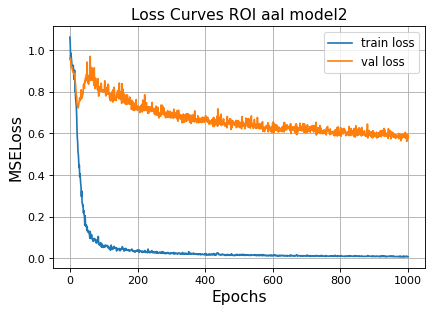

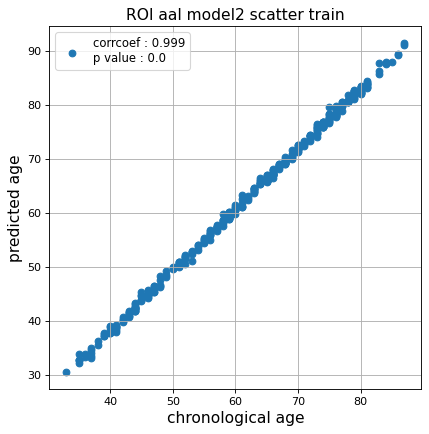

r^2 train data:  0.9787506827918911


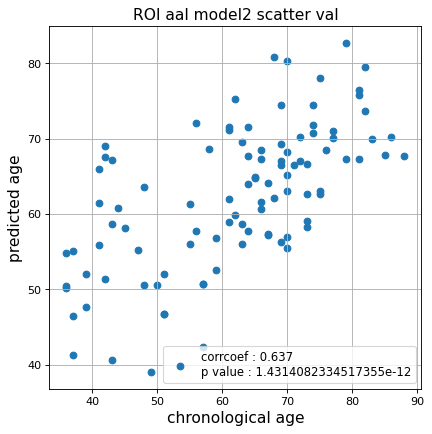

r^2 val data:  0.40127450927521635


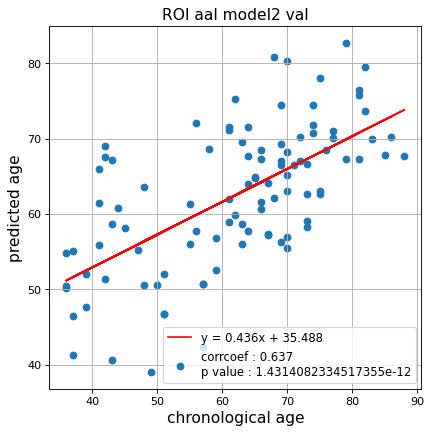

切片: 35.48759476853577
傾き: 0.4355730045574895
Kfold: 2 ::: epoch: 100, loss: 0.06878516378884132, val loss: 0.7148765325546265
Kfold: 2 ::: epoch: 200, loss: 0.036916783366065756, val loss: 0.6348055601119995
Kfold: 2 ::: epoch: 300, loss: 0.024168468152101222, val loss: 0.5736473202705383
Kfold: 2 ::: epoch: 400, loss: 0.01947557431860612, val loss: 0.5406155735254288
Kfold: 2 ::: epoch: 500, loss: 0.015150216766274892, val loss: 0.5184615775942802
Kfold: 2 ::: epoch: 600, loss: 0.01390811034406607, val loss: 0.5412731617689133
Kfold: 2 ::: epoch: 700, loss: 0.012823546233658608, val loss: 0.49384622275829315
Kfold: 2 ::: epoch: 800, loss: 0.00984787020402459, val loss: 0.49784160405397415
Kfold: 2 ::: epoch: 900, loss: 0.009652677529419843, val loss: 0.48357221484184265
Kfold: 2 ::: epoch: 1000, loss: 0.007321332867902059, val loss: 0.4799066111445427
save_epochs:894
best val loss:0.4662567228078842


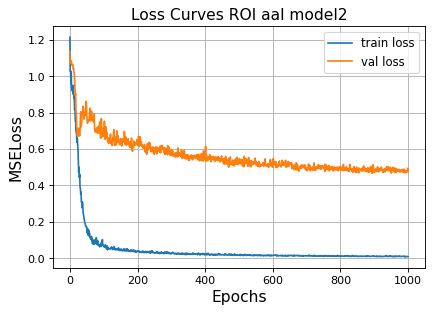

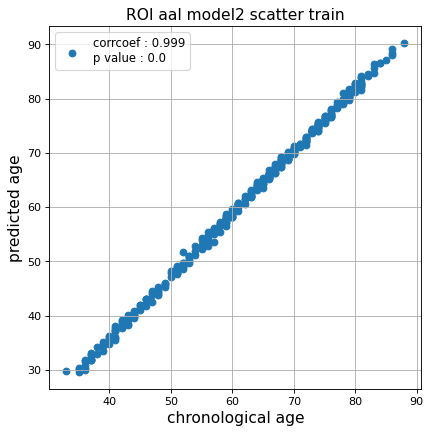

r^2 train data:  0.971353679768256


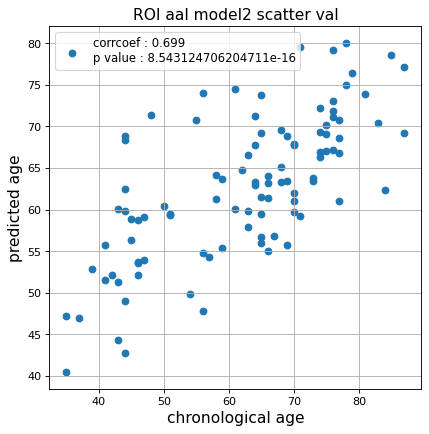

r^2 val data:  0.4821167328077255


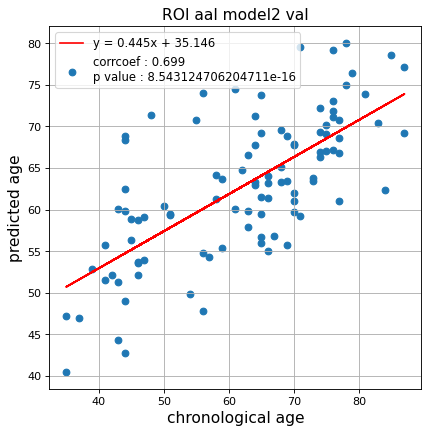

切片: 35.14561189852111
傾き: 0.4453660082679124
Kfold: 3 ::: epoch: 100, loss: 0.07235484684889133, val loss: 0.6875108331441879
Kfold: 3 ::: epoch: 200, loss: 0.03571329122552505, val loss: 0.5879931002855301
Kfold: 3 ::: epoch: 300, loss: 0.02178504991416748, val loss: 0.5660868585109711
Kfold: 3 ::: epoch: 400, loss: 0.015717410554106418, val loss: 0.5548733845353127
Kfold: 3 ::: epoch: 500, loss: 0.015757132321596146, val loss: 0.5548728629946709
Kfold: 3 ::: epoch: 600, loss: 0.011442710896237539, val loss: 0.5350327417254448
Kfold: 3 ::: epoch: 700, loss: 0.01193822085714111, val loss: 0.5138970166444778
Kfold: 3 ::: epoch: 800, loss: 0.014268055343284057, val loss: 0.5245520174503326
Kfold: 3 ::: epoch: 900, loss: 0.00828640628606081, val loss: 0.5068200826644897
Kfold: 3 ::: epoch: 1000, loss: 0.007776038040621922, val loss: 0.5125720202922821
save_epochs:905
best val loss:0.4952829033136368


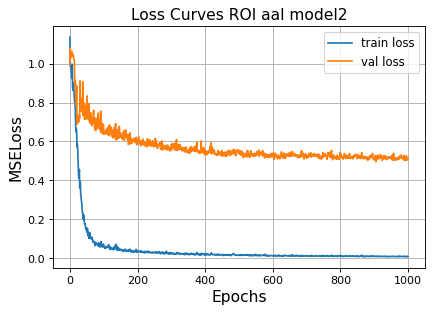

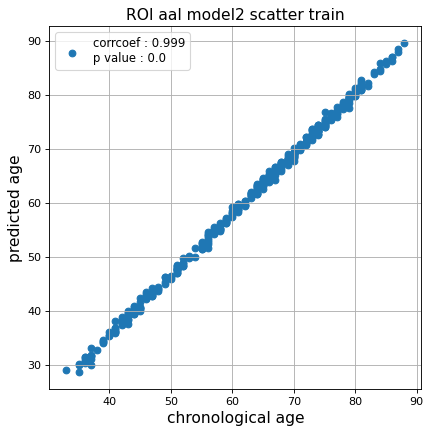

r^2 train data:  0.9654064079768909


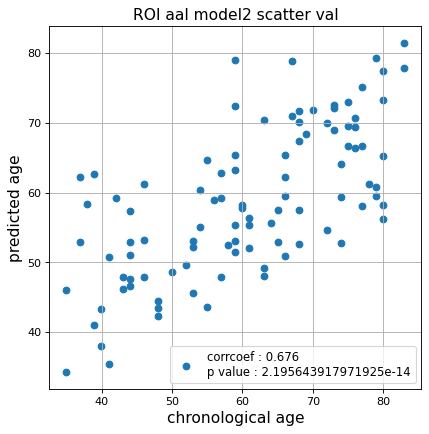

r^2 val data:  0.42664988251882197


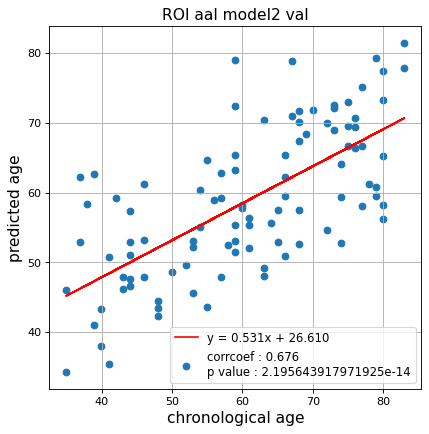

切片: 26.610071070557723
傾き: 0.5307724734176986
Kfold: 4 ::: epoch: 100, loss: 0.05709145991848065, val loss: 1.0717237889766693
Kfold: 4 ::: epoch: 200, loss: 0.0324371587485075, val loss: 1.0146545320749283
Kfold: 4 ::: epoch: 300, loss: 0.027182404811565693, val loss: 1.0757982283830643
Kfold: 4 ::: epoch: 400, loss: 0.021344931366351936, val loss: 1.0180080235004425
Kfold: 4 ::: epoch: 500, loss: 0.014027250644106131, val loss: 1.0064662247896194
Kfold: 4 ::: epoch: 600, loss: 0.012773511286538381, val loss: 1.0068456679582596
Kfold: 4 ::: epoch: 700, loss: 0.010916607275318641, val loss: 1.0555749237537384
early stopping
save_epochs:563
best val loss:0.9784120470285416


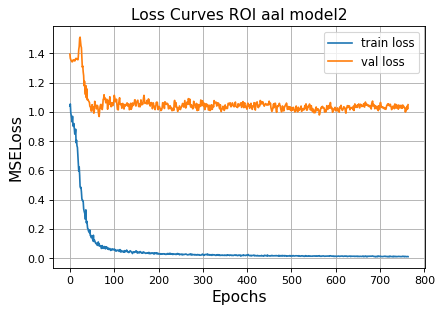

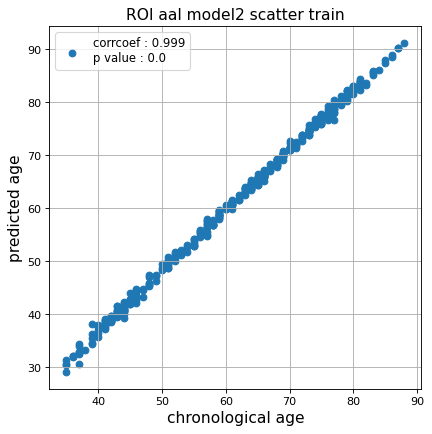

r^2 train data:  0.977614959512658


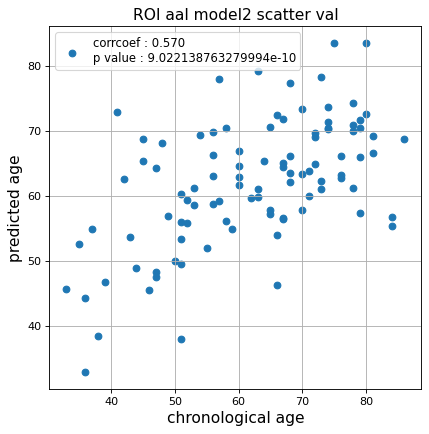

r^2 val data:  0.2999448603654413


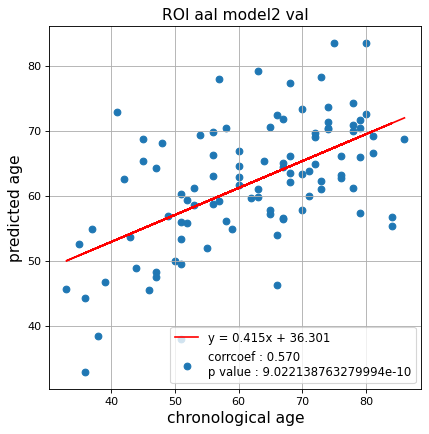

切片: 36.301315141744794
傾き: 0.4148865072394613
Kfold: 5 ::: epoch: 100, loss: 0.05683326148069822, val loss: 0.8605813235044479
Kfold: 5 ::: epoch: 200, loss: 0.04016656815432585, val loss: 0.8137915134429932
Kfold: 5 ::: epoch: 300, loss: 0.026903434943121213, val loss: 0.7313420474529266
Kfold: 5 ::: epoch: 400, loss: 0.02024165655557926, val loss: 0.7387294620275497
Kfold: 5 ::: epoch: 500, loss: 0.015145072140372716, val loss: 0.7074097692966461
Kfold: 5 ::: epoch: 600, loss: 0.01207721193965811, val loss: 0.695018470287323
Kfold: 5 ::: epoch: 700, loss: 0.01203183256662809, val loss: 0.686923623085022
Kfold: 5 ::: epoch: 800, loss: 0.009351466782391071, val loss: 0.6974523067474365
Kfold: 5 ::: epoch: 900, loss: 0.007927567984622259, val loss: 0.6785188987851143
Kfold: 5 ::: epoch: 1000, loss: 0.010256190426074542, val loss: 0.6795879006385803
save_epochs:930
best val loss:0.6666873246431351


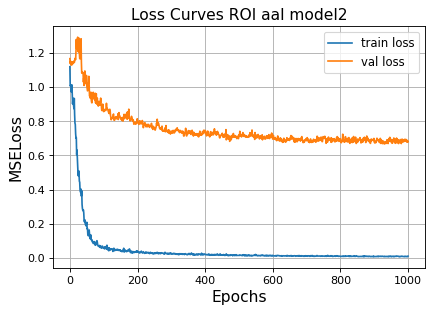

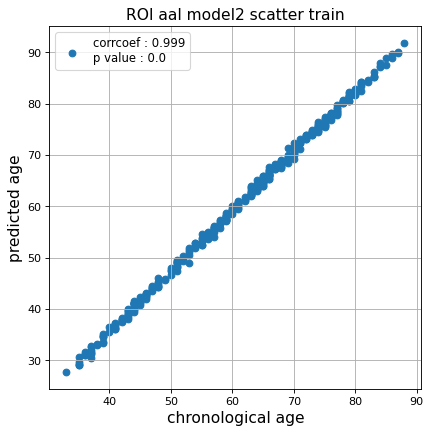

r^2 train data:  0.9673333226312266


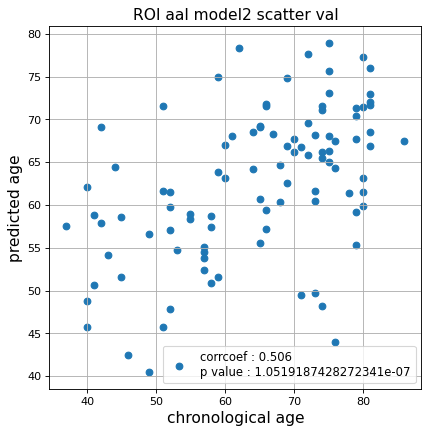

r^2 val data:  0.19950621654534062


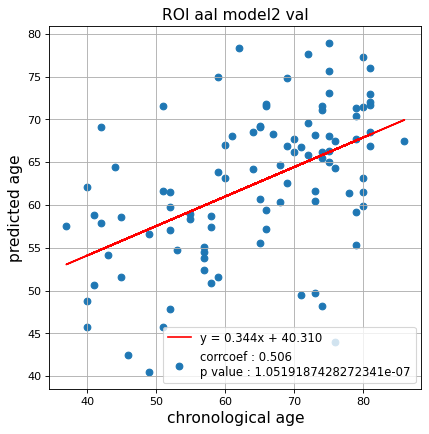

切片: 40.30972473653105
傾き: 0.3444468569609186
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.05454574124171184, val loss: 0.6711268275976181
Kfold: 1 ::: epoch: 200, loss: 0.03783953591034962, val loss: 0.6631005555391312
Kfold: 1 ::: epoch: 300, loss: 0.025347345436994847, val loss: 0.6281077042222023
Kfold: 1 ::: epoch: 400, loss: 0.02140211435751273, val loss: 0.6051838546991348
Kfold: 1 ::: epoch: 500, loss: 0.015451934331884751, val loss: 0.618778869509697
Kfold: 1 ::: epoch: 600, loss: 0.010652854537161497, val loss: 0.6165001839399338
Kfold: 1 ::: epoch: 700, loss: 0.011261454281898646, val loss: 0.5893499255180359
Kfold: 1 ::: epoch: 800, loss: 0.01045535347209527, val loss: 0.6061866283416748
early stopping
save_epochs:651
best val loss:0.5738066285848618


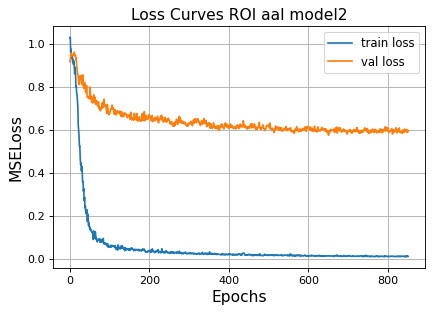

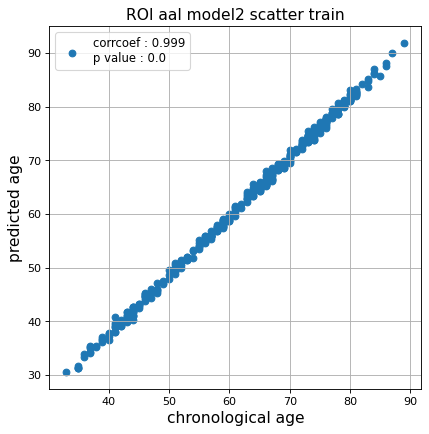

r^2 train data:  0.9877479580688763


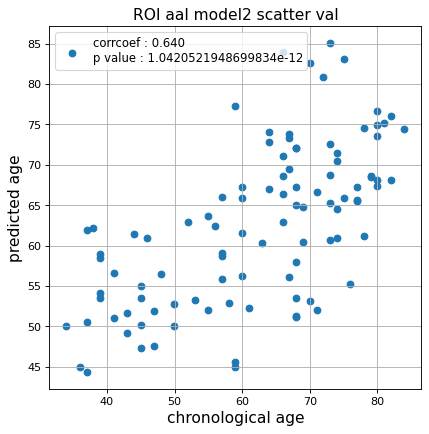

r^2 val data:  0.40199507820127756


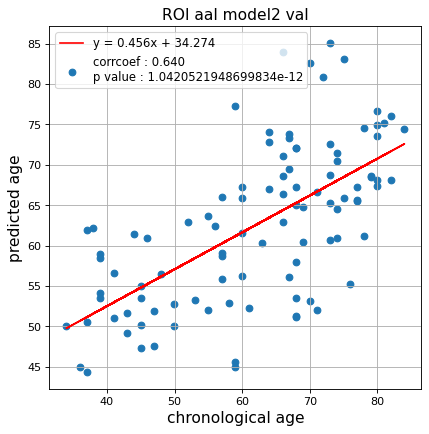

切片: 34.27376960252433
傾き: 0.4561000477793652
Kfold: 2 ::: epoch: 100, loss: 0.06568366461075269, val loss: 0.8829208761453629
Kfold: 2 ::: epoch: 200, loss: 0.03714180551469326, val loss: 0.7852427735924721
Kfold: 2 ::: epoch: 300, loss: 0.024457770471389476, val loss: 0.7461653724312782
Kfold: 2 ::: epoch: 400, loss: 0.022331000305712223, val loss: 0.7090433239936829
Kfold: 2 ::: epoch: 500, loss: 0.01649566195332087, val loss: 0.6515612900257111
Kfold: 2 ::: epoch: 600, loss: 0.013998646253290085, val loss: 0.6306017190217972
Kfold: 2 ::: epoch: 700, loss: 0.011815852915438322, val loss: 0.5952685624361038
Kfold: 2 ::: epoch: 800, loss: 0.013373836230200071, val loss: 0.5830580070614815
Kfold: 2 ::: epoch: 900, loss: 0.008627274073660374, val loss: 0.573663130402565
Kfold: 2 ::: epoch: 1000, loss: 0.009412898288036767, val loss: 0.573334738612175
save_epochs:929
best val loss:0.5534638315439224


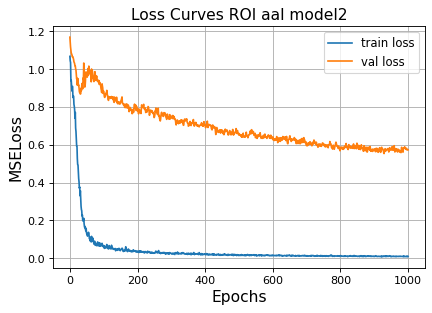

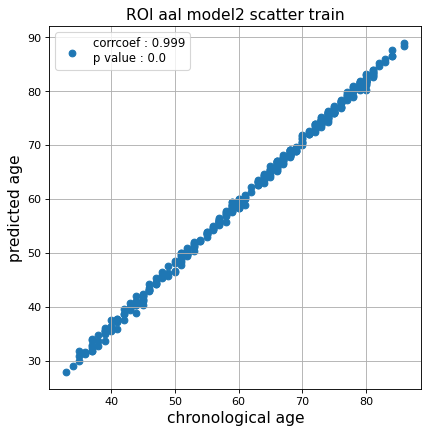

r^2 train data:  0.9748565947395522


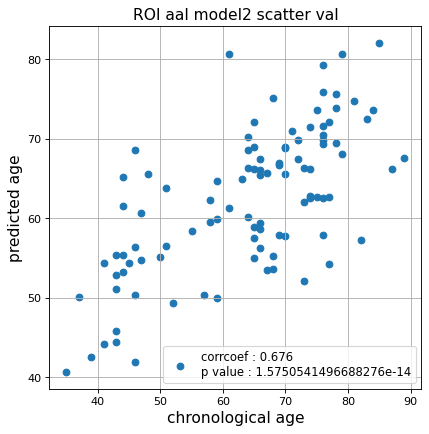

r^2 val data:  0.44582821510625514


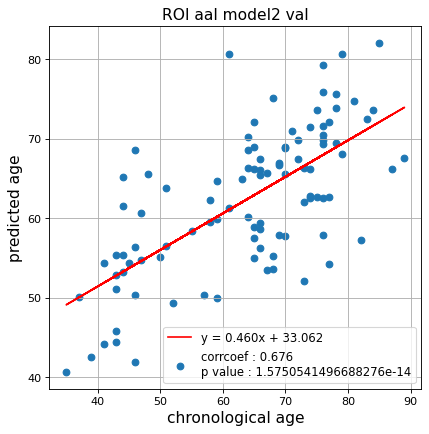

切片: 33.06209415646049
傾き: 0.4595534469970577
Kfold: 3 ::: epoch: 100, loss: 0.052935533225536346, val loss: 0.5758981630206108
Kfold: 3 ::: epoch: 200, loss: 0.03279387076886801, val loss: 0.5695134401321411
Kfold: 3 ::: epoch: 300, loss: 0.020914308440226775, val loss: 0.5629281550645828
Kfold: 3 ::: epoch: 400, loss: 0.015526691953150125, val loss: 0.6122657805681229
early stopping
save_epochs:262
best val loss:0.5488385856151581


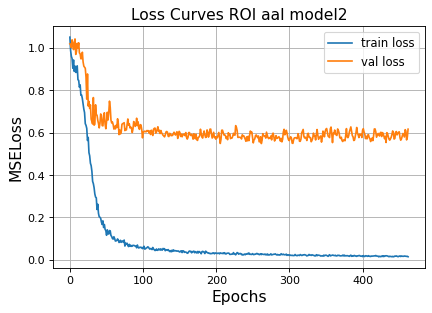

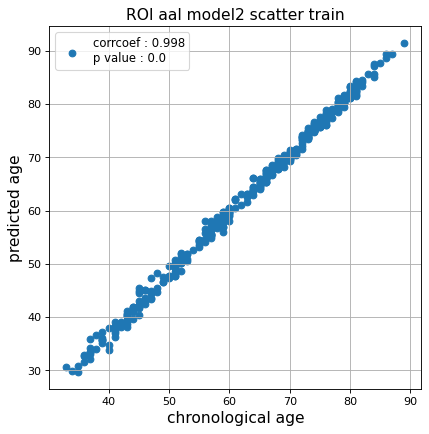

r^2 train data:  0.9792255417443176


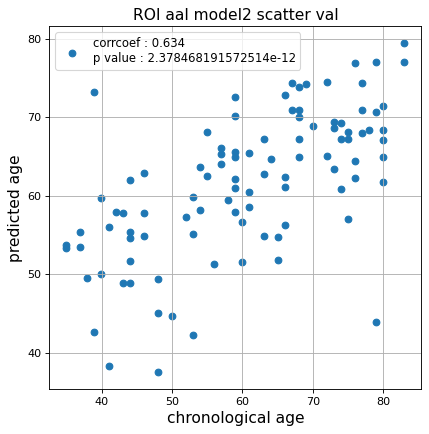

r^2 val data:  0.39557997788177046


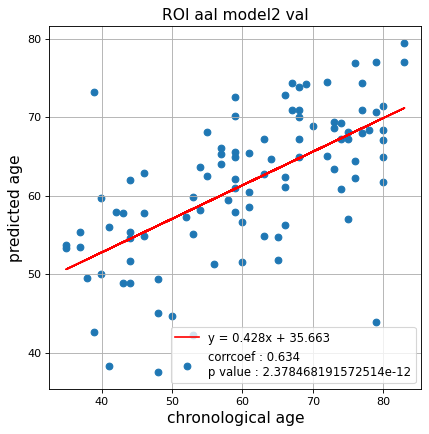

切片: 35.6629866909548
傾き: 0.42756086784940744
Kfold: 4 ::: epoch: 100, loss: 0.05697184313948338, val loss: 1.1234424859285355
Kfold: 4 ::: epoch: 200, loss: 0.031050159237705745, val loss: 1.1182573586702347
Kfold: 4 ::: epoch: 300, loss: 0.022293737158179283, val loss: 1.1396617144346237
Kfold: 4 ::: epoch: 400, loss: 0.016147184758805312, val loss: 1.086134523153305
Kfold: 4 ::: epoch: 500, loss: 0.015765339637605045, val loss: 1.1096915304660797
Kfold: 4 ::: epoch: 600, loss: 0.013523375902038354, val loss: 1.1433261036872864
early stopping
save_epochs:415
best val loss:1.0673505067825317


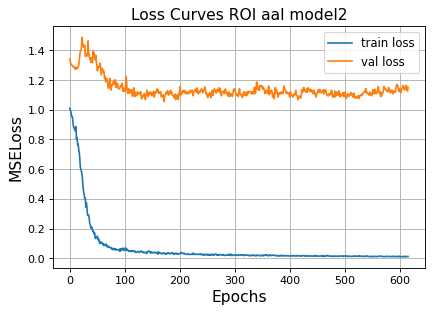

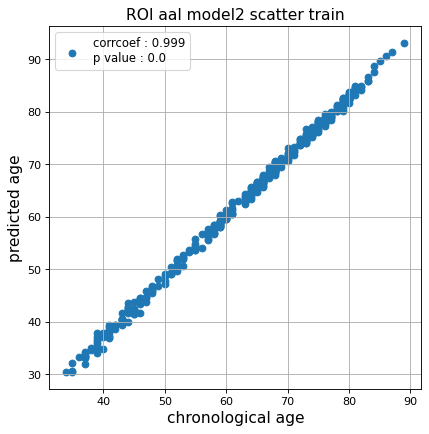

r^2 train data:  0.9735762016103361


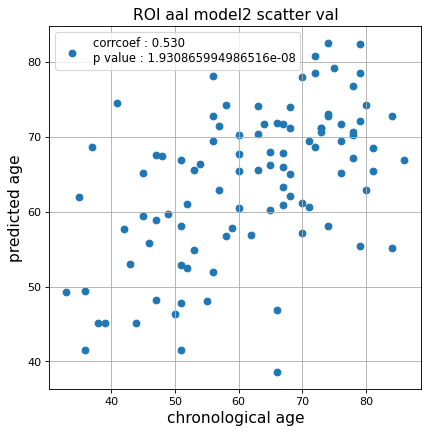

r^2 val data:  0.21298315033627002


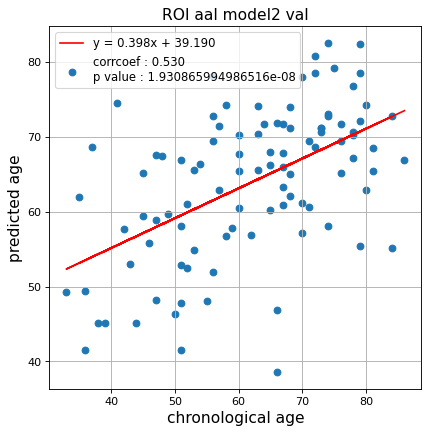

切片: 39.19020916635394
傾き: 0.39844121633783086
Kfold: 5 ::: epoch: 100, loss: 0.05436942267876405, val loss: 0.9029128402471542
Kfold: 5 ::: epoch: 200, loss: 0.032295855621878915, val loss: 0.8232724331319332
Kfold: 5 ::: epoch: 300, loss: 0.02703869056243163, val loss: 0.76911935582757
Kfold: 5 ::: epoch: 400, loss: 0.021779869503986377, val loss: 0.7170789167284966
Kfold: 5 ::: epoch: 500, loss: 0.016651348139231022, val loss: 0.6881222426891327
Kfold: 5 ::: epoch: 600, loss: 0.014479526855911199, val loss: 0.7134223729372025
Kfold: 5 ::: epoch: 700, loss: 0.012117659386533957, val loss: 0.6929301172494888
Kfold: 5 ::: epoch: 800, loss: 0.009782283925093137, val loss: 0.679237138479948
Kfold: 5 ::: epoch: 900, loss: 0.00891344528645277, val loss: 0.686256255954504
Kfold: 5 ::: epoch: 1000, loss: 0.009729621036408039, val loss: 0.6934257596731186
save_epochs:823
best val loss:0.6541696712374687


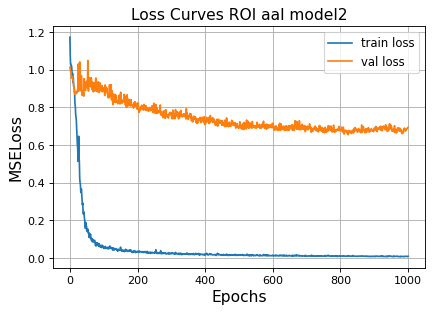

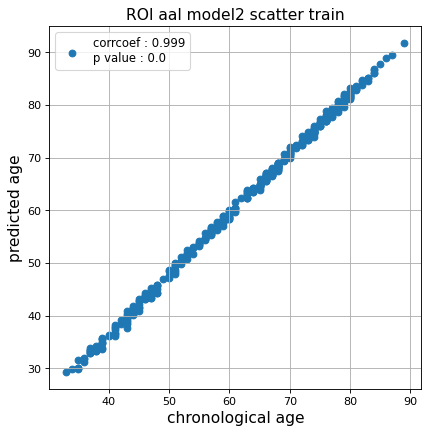

r^2 train data:  0.9773962468211735


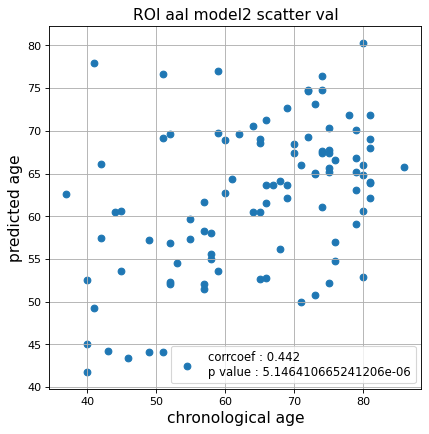

r^2 val data:  0.10899701828399178


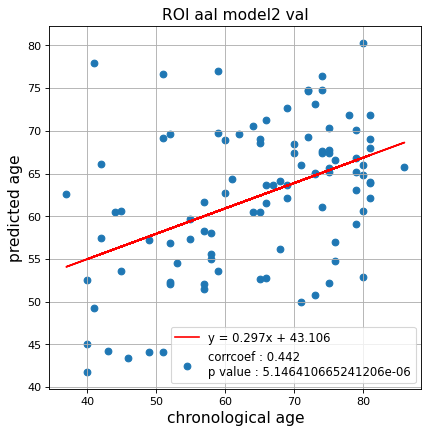

切片: 43.105716300538454
傾き: 0.2968066281457391
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.055396598477203116, val loss: 0.7398585788905621
Kfold: 1 ::: epoch: 200, loss: 0.03984517389192031, val loss: 0.6982469335198402
Kfold: 1 ::: epoch: 300, loss: 0.028861315204547003, val loss: 0.6764716431498528
Kfold: 1 ::: epoch: 400, loss: 0.021284414383654412, val loss: 0.6410066932439804
Kfold: 1 ::: epoch: 500, loss: 0.01699494205128688, val loss: 0.6423098742961884
Kfold: 1 ::: epoch: 600, loss: 0.012091391504957126, val loss: 0.6287752315402031
Kfold: 1 ::: epoch: 700, loss: 0.010314941549530396, val loss: 0.6245180070400238
Kfold: 1 ::: epoch: 800, loss: 0.010413926345511125, val loss: 0.6261733919382095
Kfold: 1 ::: epoch: 900, loss: 0.009084408852056814, val loss: 0.612820453941822
Kfold: 1 ::: epoch: 1000, loss: 0.010541154573170038, val loss: 0.6167387664318085
save_epochs:896
best val loss:0.5956517159938812


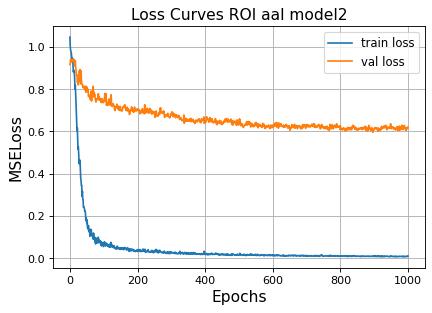

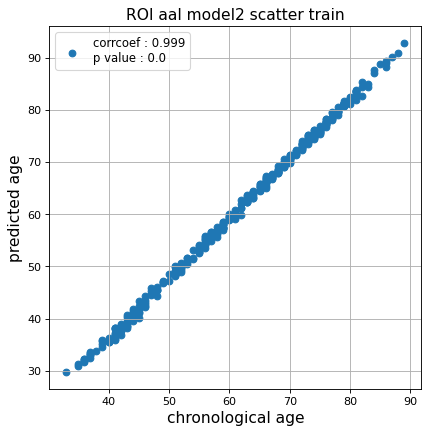

r^2 train data:  0.9758126329764546


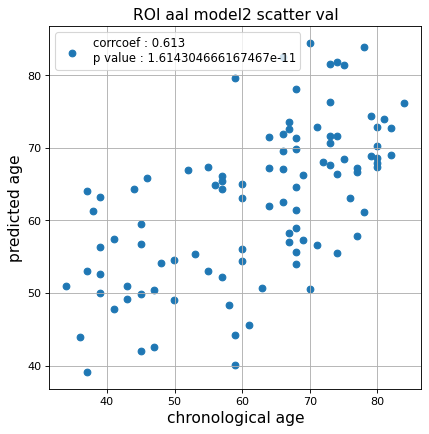

r^2 val data:  0.34827520953587476


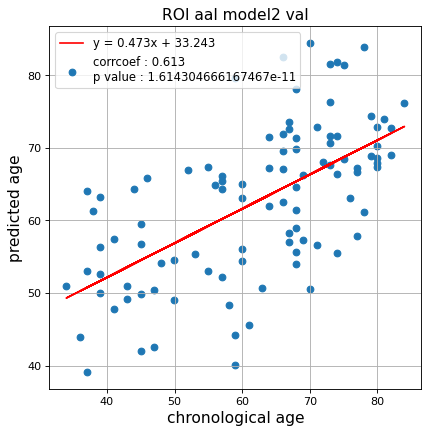

切片: 33.24338872896371
傾き: 0.47266469299747993
Kfold: 2 ::: epoch: 100, loss: 0.061238982069950834, val loss: 0.8550995141267776
Kfold: 2 ::: epoch: 200, loss: 0.03413318728025143, val loss: 0.7281753122806549
Kfold: 2 ::: epoch: 300, loss: 0.024271524869478665, val loss: 0.6885848045349121
Kfold: 2 ::: epoch: 400, loss: 0.01980108294922572, val loss: 0.6583689525723457
Kfold: 2 ::: epoch: 500, loss: 0.015948818495067265, val loss: 0.638639971613884
Kfold: 2 ::: epoch: 600, loss: 0.015538627783266397, val loss: 0.642484039068222
Kfold: 2 ::: epoch: 700, loss: 0.012241128402260633, val loss: 0.6296409368515015
Kfold: 2 ::: epoch: 800, loss: 0.010287961815125667, val loss: 0.6133827269077301
Kfold: 2 ::: epoch: 900, loss: 0.008877431257412983, val loss: 0.6109159290790558
Kfold: 2 ::: epoch: 1000, loss: 0.00877981109974476, val loss: 0.60423394292593
save_epochs:864
best val loss:0.593458503484726


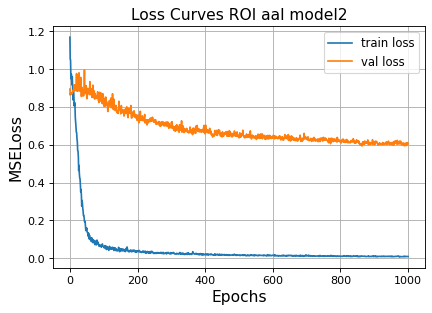

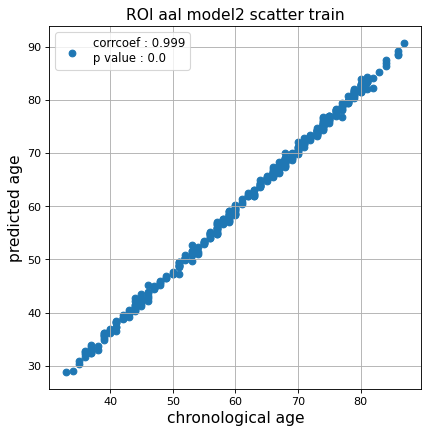

r^2 train data:  0.9776687511576808


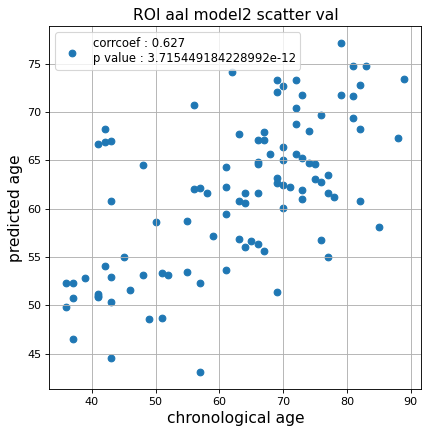

r^2 val data:  0.38031253262277


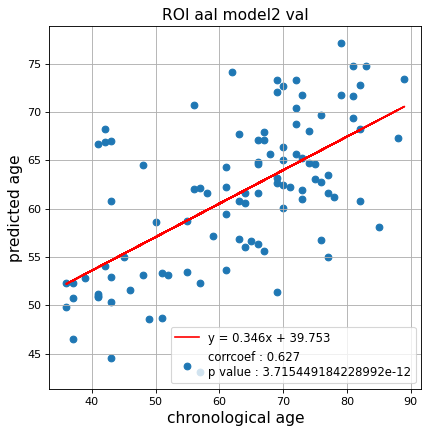

切片: 39.75276285686505
傾き: 0.3459795663834293
Kfold: 3 ::: epoch: 100, loss: 0.06918879741659531, val loss: 0.911787286400795
Kfold: 3 ::: epoch: 200, loss: 0.03219269359341034, val loss: 0.8264997154474258
Kfold: 3 ::: epoch: 300, loss: 0.02091523539274931, val loss: 0.8477289229631424
Kfold: 3 ::: epoch: 400, loss: 0.018574868328869343, val loss: 0.7633703500032425
Kfold: 3 ::: epoch: 500, loss: 0.016444983104100593, val loss: 0.7592171132564545
early stopping
save_epochs:326
best val loss:0.7417287081480026


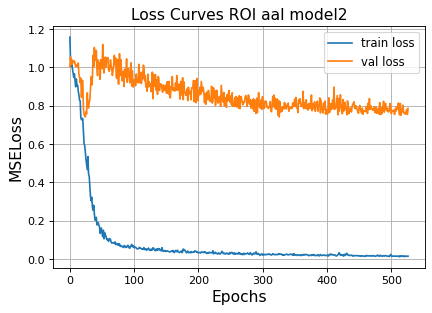

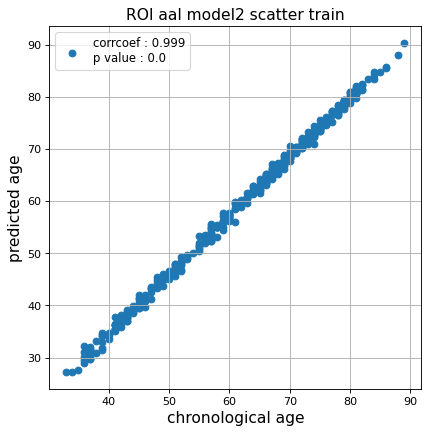

r^2 train data:  0.9499160882881817


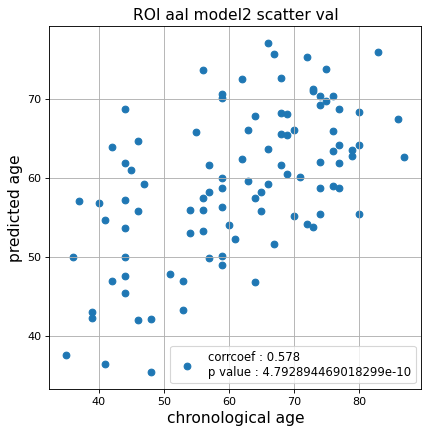

r^2 val data:  0.29032912702867986


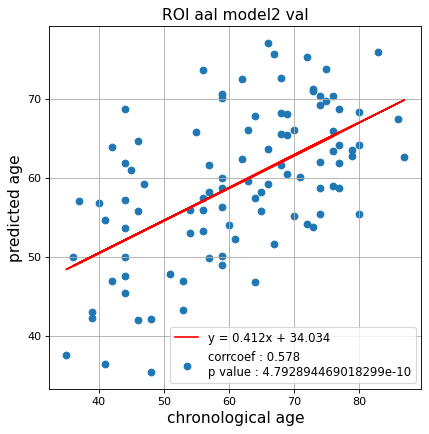

切片: 34.03373676305952
傾き: 0.41193496112962447
Kfold: 4 ::: epoch: 100, loss: 0.05661277616253266, val loss: 1.891624540090561
Kfold: 4 ::: epoch: 200, loss: 0.02785461352994809, val loss: 1.5939451307058334
Kfold: 4 ::: epoch: 300, loss: 0.02318271636389769, val loss: 1.4252626299858093
Kfold: 4 ::: epoch: 400, loss: 0.019546253535036858, val loss: 1.3371028304100037
Kfold: 4 ::: epoch: 500, loss: 0.017234920953901913, val loss: 1.22545325756073
Kfold: 4 ::: epoch: 600, loss: 0.01503401120694784, val loss: 1.1391761302947998
Kfold: 4 ::: epoch: 700, loss: 0.010240733444404144, val loss: 1.1188780069351196
Kfold: 4 ::: epoch: 800, loss: 0.009054108558652492, val loss: 1.0569618791341782
Kfold: 4 ::: epoch: 900, loss: 0.009384387065298282, val loss: 1.0877171456813812
Kfold: 4 ::: epoch: 1000, loss: 0.007584187345435986, val loss: 1.0518244802951813
save_epochs:972
best val loss:1.0354139357805252


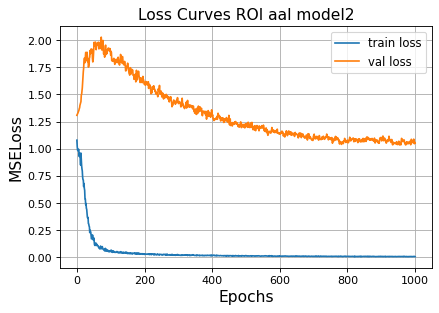

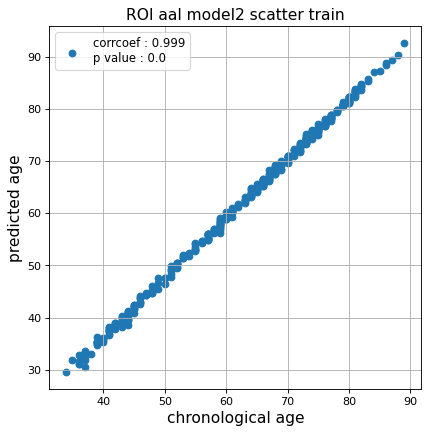

r^2 train data:  0.9763603558073449


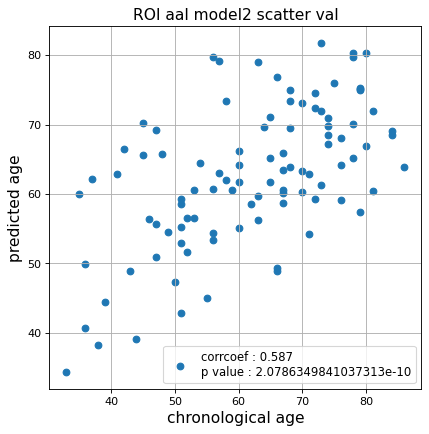

r^2 val data:  0.3114635854317642


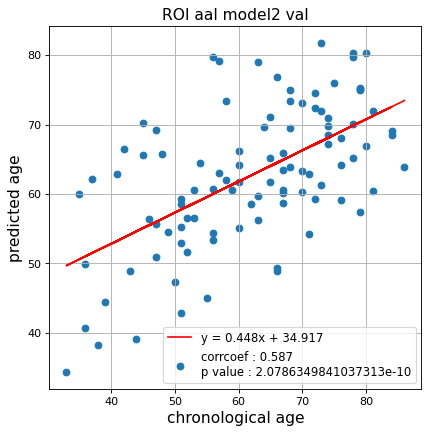

切片: 34.9174554003473
傾き: 0.44795945289848227
Kfold: 5 ::: epoch: 100, loss: 0.07251371099398686, val loss: 1.186070904135704
Kfold: 5 ::: epoch: 200, loss: 0.03559368189710837, val loss: 1.078066423535347
Kfold: 5 ::: epoch: 300, loss: 0.025713807974870388, val loss: 1.0376974940299988
Kfold: 5 ::: epoch: 400, loss: 0.017693510207419213, val loss: 0.9828125536441803
Kfold: 5 ::: epoch: 500, loss: 0.01794043820924484, val loss: 0.9239225089550018
Kfold: 5 ::: epoch: 600, loss: 0.011097150460745279, val loss: 0.8953268527984619
Kfold: 5 ::: epoch: 700, loss: 0.01394894217642454, val loss: 0.9079659581184387
Kfold: 5 ::: epoch: 800, loss: 0.01052637083026079, val loss: 0.8644555956125259
Kfold: 5 ::: epoch: 900, loss: 0.008445991919590877, val loss: 0.8365698456764221
Kfold: 5 ::: epoch: 1000, loss: 0.007847400131420447, val loss: 0.8141775876283646
save_epochs:971
best val loss:0.8062660545110703


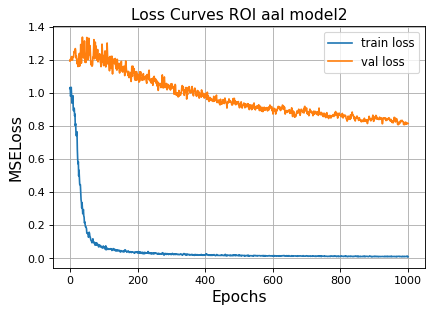

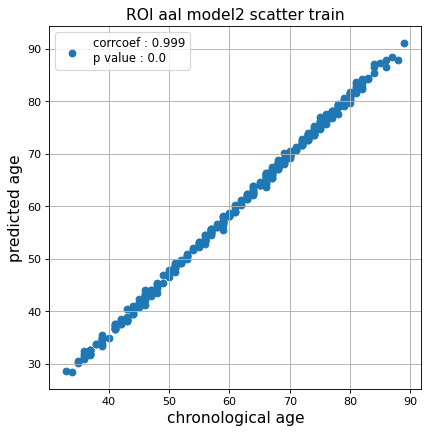

r^2 train data:  0.9720942727360156


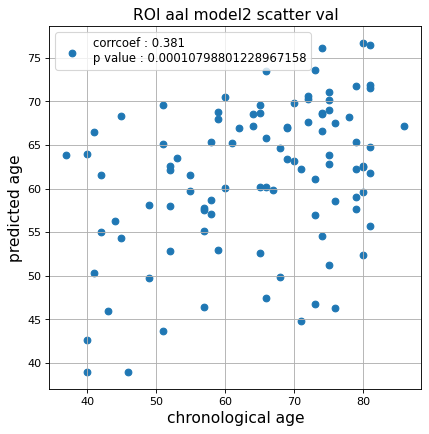

r^2 val data:  0.0004178824519225355


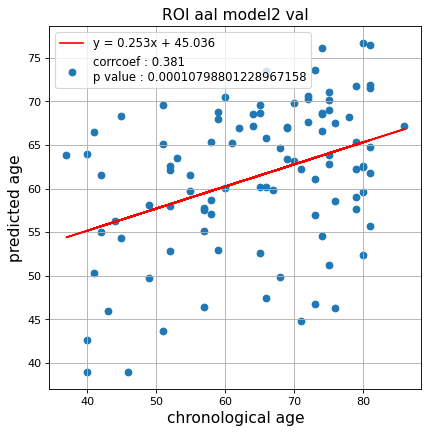

切片: 45.035771592224535
傾き: 0.253292410577973
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.06556808375395261, val loss: 0.8063506335020065
Kfold: 1 ::: epoch: 200, loss: 0.0349403999459285, val loss: 0.7482424229383469
Kfold: 1 ::: epoch: 300, loss: 0.029996072157071188, val loss: 0.6839864104986191
Kfold: 1 ::: epoch: 400, loss: 0.022538710887042377, val loss: 0.6526920795440674
Kfold: 1 ::: epoch: 500, loss: 0.014884925304123988, val loss: 0.6065021827816963
Kfold: 1 ::: epoch: 600, loss: 0.011915300327997942, val loss: 0.6181578114628792
Kfold: 1 ::: epoch: 700, loss: 0.010462174836832743, val loss: 0.61925008893013
Kfold: 1 ::: epoch: 800, loss: 0.010234561963723255, val loss: 0.6265787482261658
Kfold: 1 ::: epoch: 900, loss: 0.008899567254747335, val loss: 0.6012845635414124
Kfold: 1 ::: epoch: 1000, loss: 0.009218097700235935, val loss: 0.6061683595180511
save_epochs:911
best val loss:0.5721446722745895


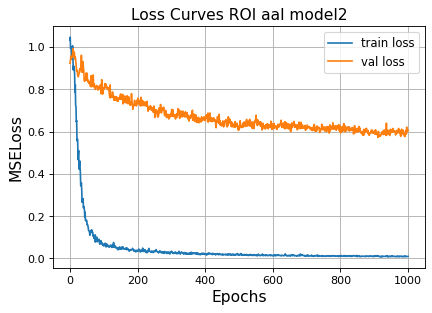

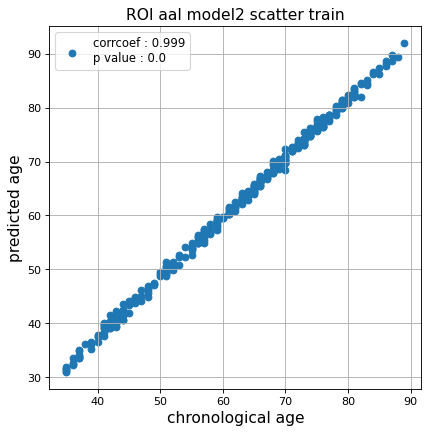

r^2 train data:  0.9867223613375351


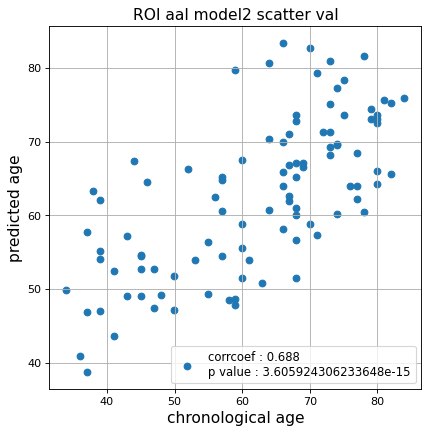

r^2 val data:  0.466648939888743


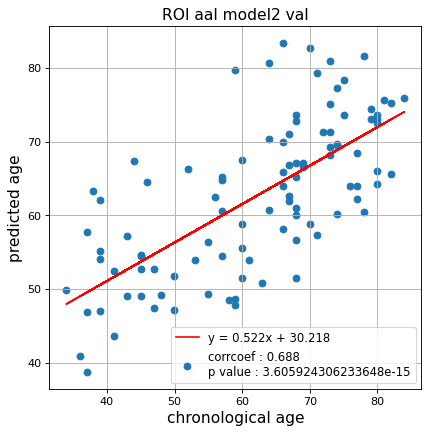

切片: 30.21835310303191
傾き: 0.5220064131697276
Kfold: 2 ::: epoch: 100, loss: 0.05972165327805739, val loss: 0.8542091995477676
Kfold: 2 ::: epoch: 200, loss: 0.03393435120009459, val loss: 0.7620449662208557
Kfold: 2 ::: epoch: 300, loss: 0.027461458427401688, val loss: 0.7544613033533096
Kfold: 2 ::: epoch: 400, loss: 0.019428157677444127, val loss: 0.7251956313848495
Kfold: 2 ::: epoch: 500, loss: 0.01707964211415786, val loss: 0.7092992812395096
Kfold: 2 ::: epoch: 600, loss: 0.015300023942612685, val loss: 0.706607848405838
Kfold: 2 ::: epoch: 700, loss: 0.014919988667735687, val loss: 0.6924377679824829
Kfold: 2 ::: epoch: 800, loss: 0.009618327057418915, val loss: 0.67950040102005
Kfold: 2 ::: epoch: 900, loss: 0.00950435957369896, val loss: 0.6693308800458908
Kfold: 2 ::: epoch: 1000, loss: 0.009361317954384364, val loss: 0.6656080931425095
save_epochs:946
best val loss:0.6497768014669418


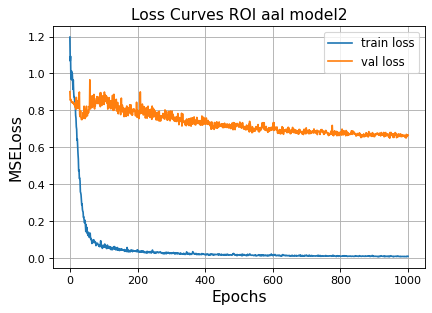

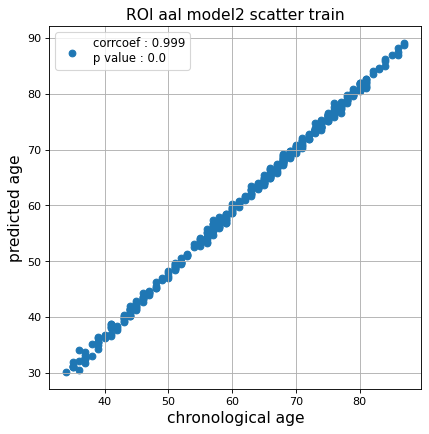

r^2 train data:  0.9820221891651132


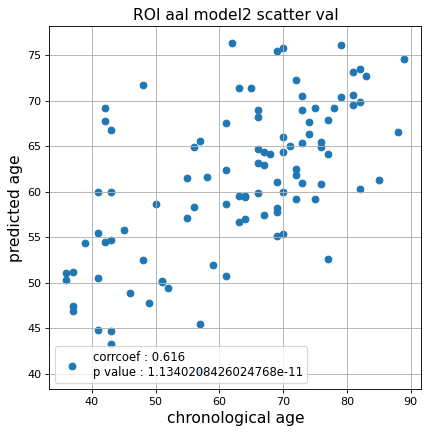

r^2 val data:  0.36739618120320705


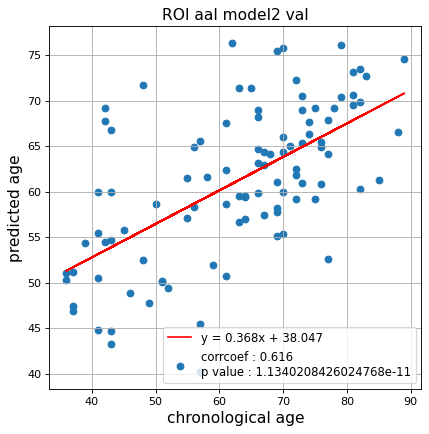

切片: 38.0470908981686
傾き: 0.36814554236014146
Kfold: 3 ::: epoch: 100, loss: 0.06710198177741124, val loss: 0.5692726150155067
Kfold: 3 ::: epoch: 200, loss: 0.03645274243675745, val loss: 0.566402442753315
Kfold: 3 ::: epoch: 300, loss: 0.023101025762466285, val loss: 0.5583135262131691
Kfold: 3 ::: epoch: 400, loss: 0.021872067609085485, val loss: 0.5441022887825966
Kfold: 3 ::: epoch: 500, loss: 0.0161548164458229, val loss: 0.5261462032794952
Kfold: 3 ::: epoch: 600, loss: 0.013448101826585256, val loss: 0.5319132059812546
Kfold: 3 ::: epoch: 700, loss: 0.011480728594156412, val loss: 0.5251960009336472
Kfold: 3 ::: epoch: 800, loss: 0.010899174313705701, val loss: 0.510220855474472
Kfold: 3 ::: epoch: 900, loss: 0.00974272943746585, val loss: 0.4994945526123047
Kfold: 3 ::: epoch: 1000, loss: 0.009982162011930576, val loss: 0.4971719831228256
save_epochs:975
best val loss:0.4849650226533413


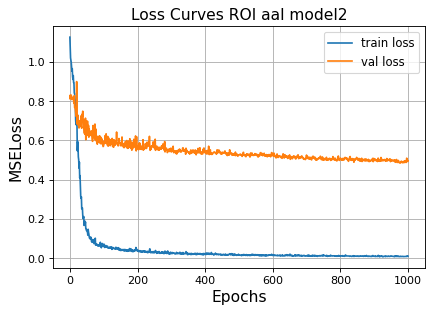

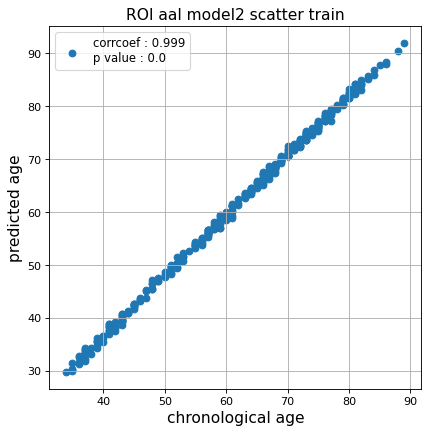

r^2 train data:  0.9791490447328611


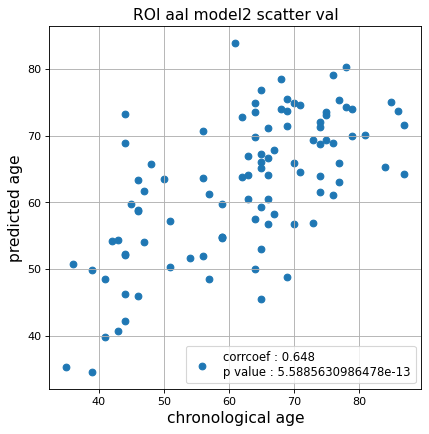

r^2 val data:  0.3962722823315308


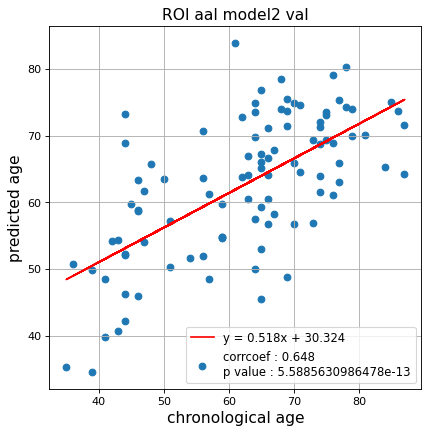

切片: 30.323818240118122
傾き: 0.5181790454093796
Kfold: 4 ::: epoch: 100, loss: 0.06022413246906721, val loss: 0.9575979858636856
Kfold: 4 ::: epoch: 200, loss: 0.03744062881630201, val loss: 0.911431223154068
Kfold: 4 ::: epoch: 300, loss: 0.0211313426351318, val loss: 0.9151540994644165
Kfold: 4 ::: epoch: 400, loss: 0.01825776158903654, val loss: 0.9100083783268929
Kfold: 4 ::: epoch: 500, loss: 0.015846273217063684, val loss: 0.9088633805513382
early stopping
save_epochs:397
best val loss:0.8809113204479218


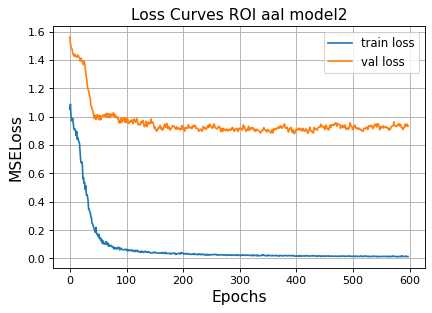

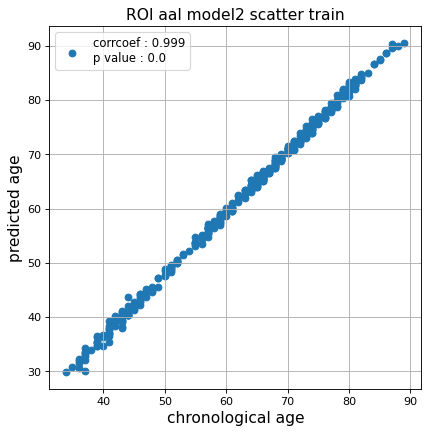

r^2 train data:  0.9782291866070976


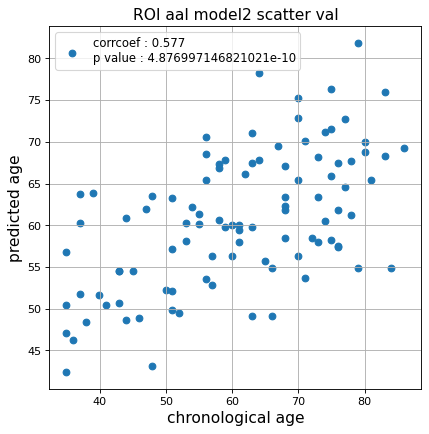

r^2 val data:  0.3332300479214516


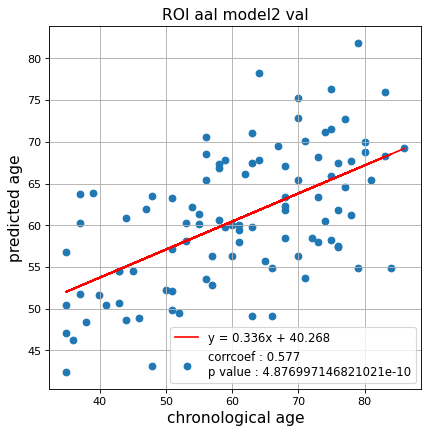

切片: 40.26829101129455
傾き: 0.3363093249155645
Kfold: 5 ::: epoch: 100, loss: 0.056989163446884886, val loss: 0.9026293568313122
Kfold: 5 ::: epoch: 200, loss: 0.03418278880417347, val loss: 0.8644045181572437
Kfold: 5 ::: epoch: 300, loss: 0.02580900898633095, val loss: 0.8426269367337227
Kfold: 5 ::: epoch: 400, loss: 0.018334180259933837, val loss: 0.8178510367870331
Kfold: 5 ::: epoch: 500, loss: 0.015274336704841027, val loss: 0.8026347160339355
Kfold: 5 ::: epoch: 600, loss: 0.012843520738757573, val loss: 0.7921266257762909
Kfold: 5 ::: epoch: 700, loss: 0.010882331524044275, val loss: 0.7668519169092178
Kfold: 5 ::: epoch: 800, loss: 0.014172019078754462, val loss: 0.7750806733965874
Kfold: 5 ::: epoch: 900, loss: 0.010157577890472917, val loss: 0.7489681020379066
Kfold: 5 ::: epoch: 1000, loss: 0.007971347023088198, val loss: 0.7689617350697517
save_epochs:832
best val loss:0.7364012449979782


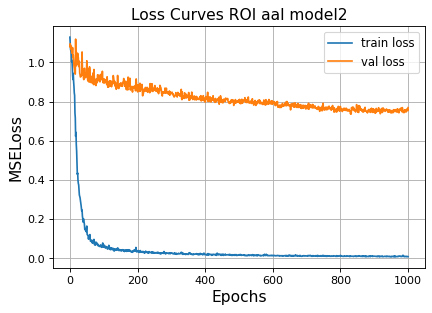

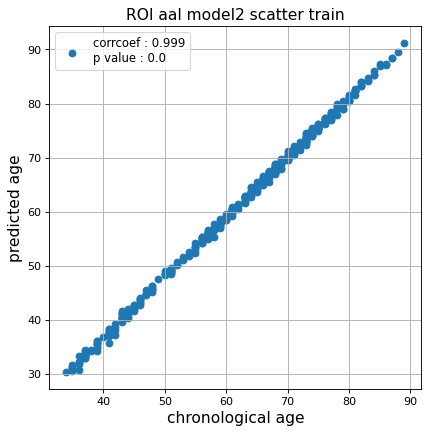

r^2 train data:  0.9839842925773413


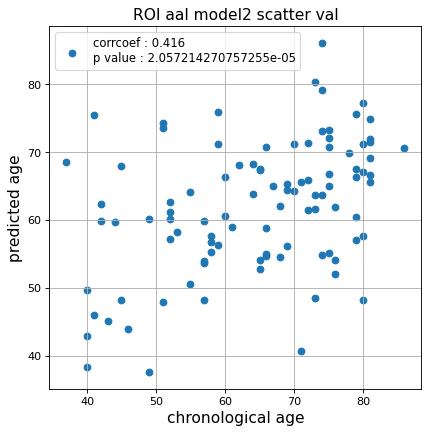

r^2 val data:  0.009872572170958382


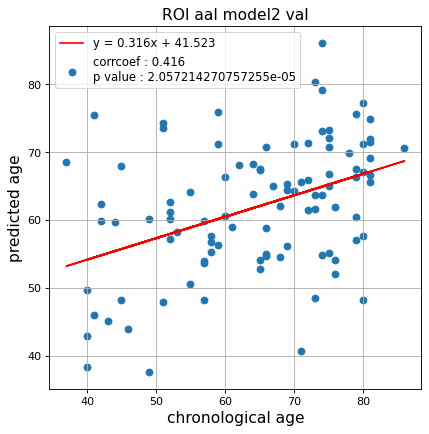

切片: 41.522776597834905
傾き: 0.3160328837542251
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.05204892846254202, val loss: 0.6253834441304207
Kfold: 1 ::: epoch: 200, loss: 0.029975194627275832, val loss: 0.5737691819667816
Kfold: 1 ::: epoch: 300, loss: 0.025094360256424315, val loss: 0.5397685281932354
Kfold: 1 ::: epoch: 400, loss: 0.021016193983646538, val loss: 0.5485337637364864
Kfold: 1 ::: epoch: 500, loss: 0.014248739856366929, val loss: 0.5115880779922009
Kfold: 1 ::: epoch: 600, loss: 0.01473936689301179, val loss: 0.5142467394471169
Kfold: 1 ::: epoch: 700, loss: 0.011613041556511935, val loss: 0.5152764990925789
early stopping
save_epochs:593
best val loss:0.5020488016307354


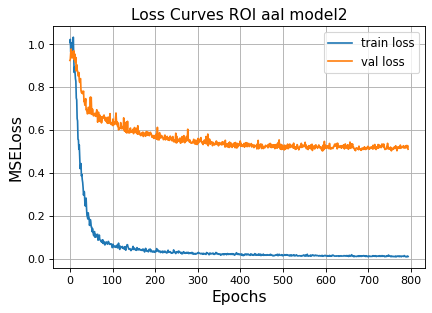

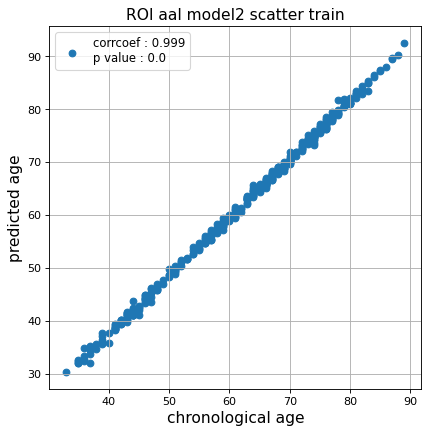

r^2 train data:  0.987133984261973


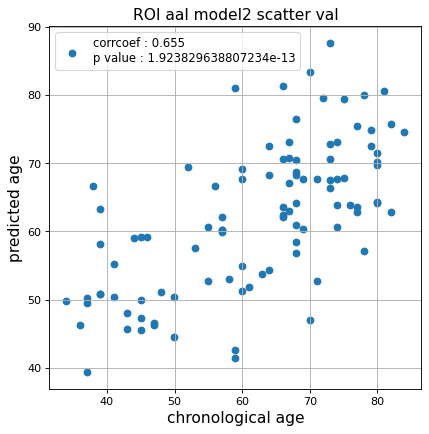

r^2 val data:  0.4131575006003906


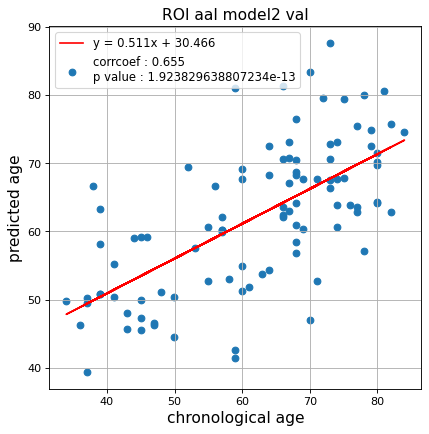

切片: 30.46571426167965
傾き: 0.5109998811083057
Kfold: 2 ::: epoch: 100, loss: 0.05047122503702457, val loss: 0.7023032754659653
Kfold: 2 ::: epoch: 200, loss: 0.035612234559196695, val loss: 0.6474699340760708
Kfold: 2 ::: epoch: 300, loss: 0.021481703966856003, val loss: 0.630194790661335
Kfold: 2 ::: epoch: 400, loss: 0.017867441862248458, val loss: 0.6021015625447035
Kfold: 2 ::: epoch: 500, loss: 0.017635071005385656, val loss: 0.6027636211365461
Kfold: 2 ::: epoch: 600, loss: 0.012132039616027704, val loss: 0.5902615077793598
Kfold: 2 ::: epoch: 700, loss: 0.010656975066432586, val loss: 0.5904726125299931
Kfold: 2 ::: epoch: 800, loss: 0.008709985619554153, val loss: 0.5790127664804459
Kfold: 2 ::: epoch: 900, loss: 0.007423182161381612, val loss: 0.573554240167141
Kfold: 2 ::: epoch: 1000, loss: 0.0077343529376846095, val loss: 0.5695340484380722
save_epochs:935
best val loss:0.5605765283107758


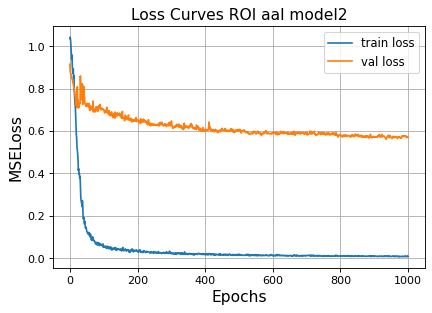

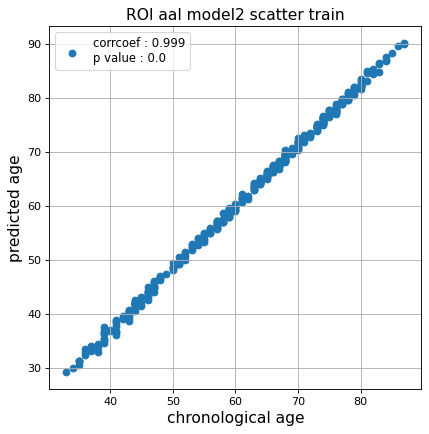

r^2 train data:  0.9787283556212953


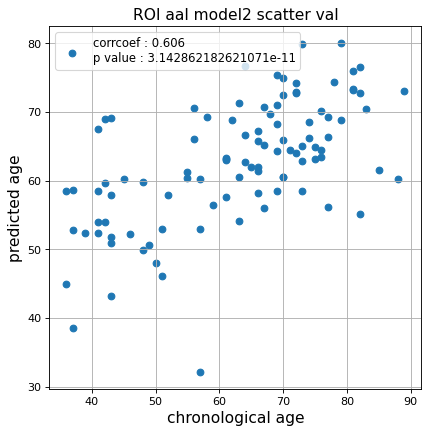

r^2 val data:  0.36572952958636495


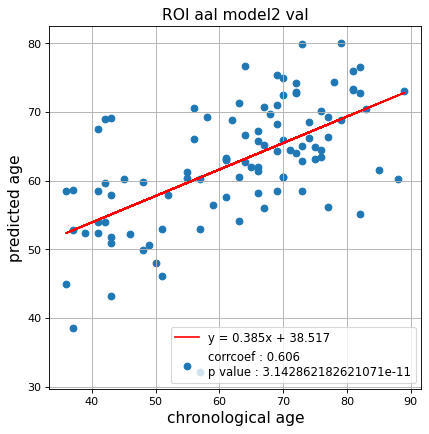

切片: 38.51684691466137
傾き: 0.3851583156496981
Kfold: 3 ::: epoch: 100, loss: 0.0570707254541608, val loss: 0.4847821705043316
Kfold: 3 ::: epoch: 200, loss: 0.03555415395217446, val loss: 0.43530119117349386
Kfold: 3 ::: epoch: 300, loss: 0.0219283474322695, val loss: 0.4411183288320899
Kfold: 3 ::: epoch: 400, loss: 0.01995296088548807, val loss: 0.4067337417509407
Kfold: 3 ::: epoch: 500, loss: 0.016187868654154815, val loss: 0.41435901913791895
Kfold: 3 ::: epoch: 600, loss: 0.012818942276331095, val loss: 0.4014908682438545
Kfold: 3 ::: epoch: 700, loss: 0.014367753281616248, val loss: 0.40802345669362694
Kfold: 3 ::: epoch: 800, loss: 0.01050341734662652, val loss: 0.3910828467924148
Kfold: 3 ::: epoch: 900, loss: 0.009877377189695835, val loss: 0.40898475708672777
Kfold: 3 ::: epoch: 1000, loss: 0.009291692601087002, val loss: 0.4006704626372084
save_epochs:800
best val loss:0.3910828467924148


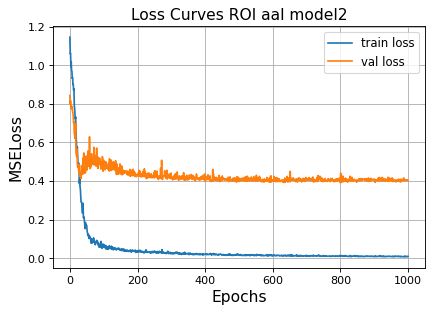

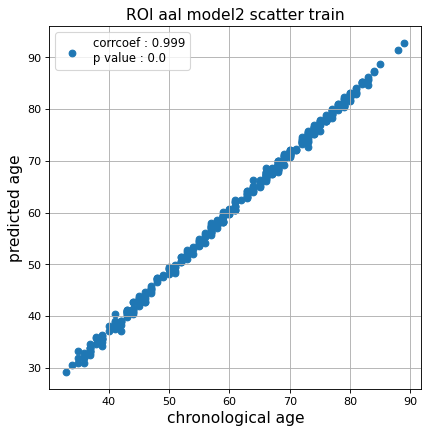

r^2 train data:  0.9784536211411364


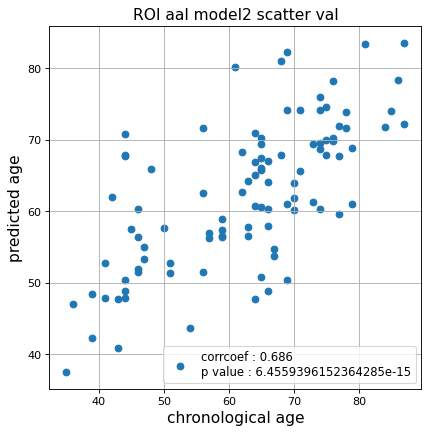

r^2 val data:  0.4632794412155624


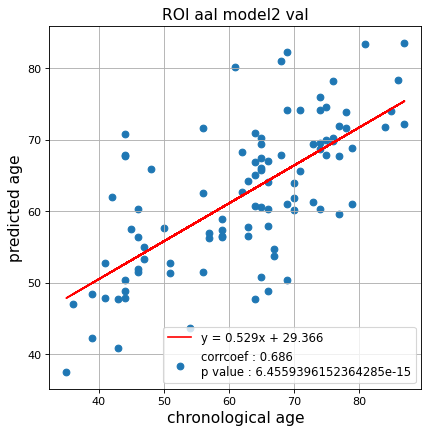

切片: 29.36640716089277
傾き: 0.529302800477896
Kfold: 4 ::: epoch: 100, loss: 0.07403393806173252, val loss: 0.7853998616337776
Kfold: 4 ::: epoch: 200, loss: 0.039074767094392046, val loss: 0.7411788105964661
Kfold: 4 ::: epoch: 300, loss: 0.027490654243872717, val loss: 0.728564940392971
Kfold: 4 ::: epoch: 400, loss: 0.019771065634603683, val loss: 0.6955290287733078
Kfold: 4 ::: epoch: 500, loss: 0.015784796972114306, val loss: 0.6868131756782532
Kfold: 4 ::: epoch: 600, loss: 0.015443206263276247, val loss: 0.672253780066967
Kfold: 4 ::: epoch: 700, loss: 0.012816873307411488, val loss: 0.6577432751655579
Kfold: 4 ::: epoch: 800, loss: 0.010502091394020962, val loss: 0.6543298363685608
Kfold: 4 ::: epoch: 900, loss: 0.010453727490340289, val loss: 0.6408222615718842
Kfold: 4 ::: epoch: 1000, loss: 0.010416716122283386, val loss: 0.6233972907066345
save_epochs:994
best val loss:0.6112091243267059


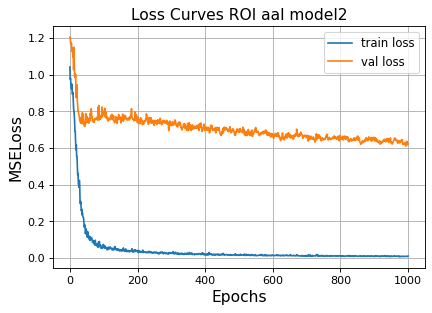

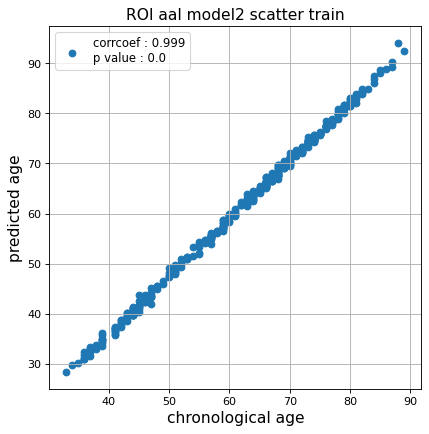

r^2 train data:  0.9719613080513646


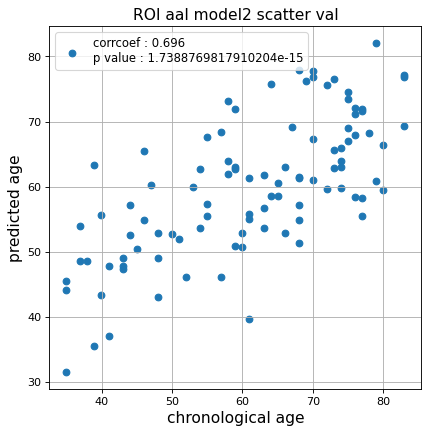

r^2 val data:  0.4703612202601316


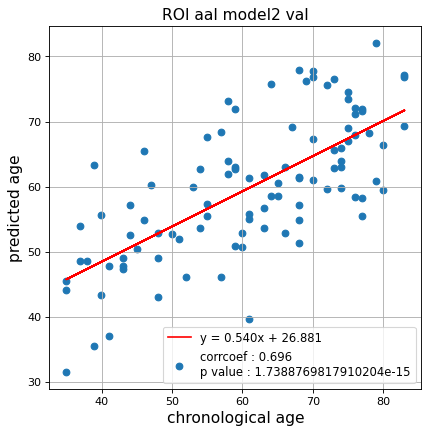

切片: 26.88123269378618
傾き: 0.5402005599646889
Kfold: 5 ::: epoch: 100, loss: 0.06894370053823178, val loss: 0.7938140332698822
Kfold: 5 ::: epoch: 200, loss: 0.030911632168751497, val loss: 0.7700378596782684
Kfold: 5 ::: epoch: 300, loss: 0.02249383940719641, val loss: 0.7616181671619415
Kfold: 5 ::: epoch: 400, loss: 0.02129667904227972, val loss: 0.7627332657575607
Kfold: 5 ::: epoch: 500, loss: 0.014246256377261419, val loss: 0.77778759598732
Kfold: 5 ::: epoch: 600, loss: 0.011414954546265878, val loss: 0.7415719032287598
Kfold: 5 ::: epoch: 700, loss: 0.011620381847023964, val loss: 0.7427509427070618
Kfold: 5 ::: epoch: 800, loss: 0.011507058301224159, val loss: 0.7140843570232391
early stopping
save_epochs:602
best val loss:0.692129373550415


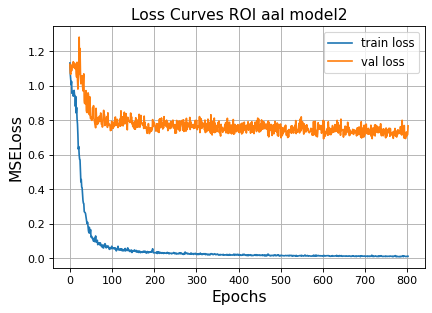

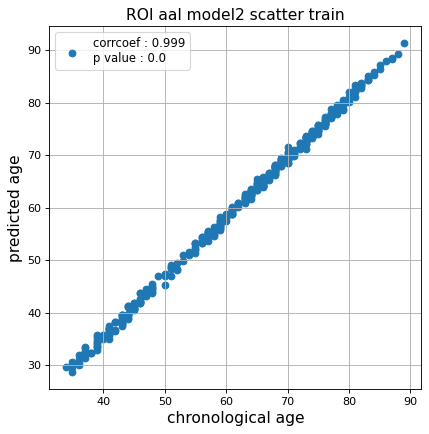

r^2 train data:  0.966551761863394


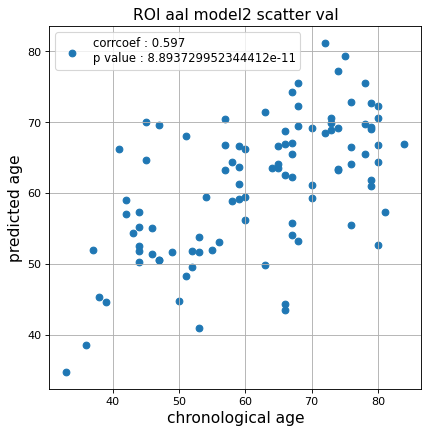

r^2 val data:  0.3377757887411382


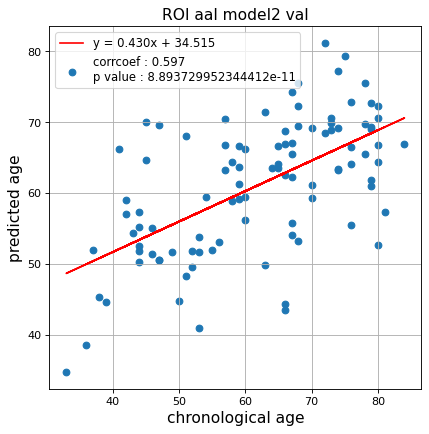

切片: 34.51483533986233
傾き: 0.4295216338367503
CPU times: user 1h 30min 22s, sys: 9min 16s, total: 1h 39min 38s
Wall time: 1h 39min 38s


In [17]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_2  = []
test_pred_aal_corrected_2  = []
test_label_aal_2 = []
test_idx_aal_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model2'
                                                          )
    
    test_pred_aal_2.append(test_pred)
    test_pred_aal_corrected_2.append(test_pred_corrected)
    test_label_aal_2.append(test_label)
    test_idx_aal_2.append(test_idx)

### データ保存

In [ ]:
!python GPU.py Transformer_ROI_AAL

In [18]:
test_pred_aal_1 = np.array(test_pred_aal_1, dtype=object)
test_pred_aal_corrected_1 = np.array(test_pred_aal_corrected_1, dtype=object)

test_pred_aal_2 = np.array(test_pred_aal_2, dtype=object)
test_pred_aal_corrected_2 = np.array(test_pred_aal_corrected_2, dtype=object)

In [19]:
np.savez('../02_data_analysis/temp/aal_1',
         test_pred_aal_1,
         test_pred_aal_corrected_1,
         test_label_aal_1,
         test_idx_aal_1)
np.savez('../02_data_analysis/temp/aal_2',
         test_pred_aal_2,
         test_pred_aal_corrected_2,
         test_label_aal_2,
         test_idx_aal_2)

### Data定義(dynamic FC)

In [16]:
%%time
df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
data_dynamic_aal = make_data(df_dynamic_aal)
print(data_dynamic_aal.shape)

(615, 123, 6670)
CPU times: user 3min 8s, sys: 5.46 s, total: 3min 13s
Wall time: 3min 13s


### Dynamic FC 1

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.038891818231114976, val loss: 0.4476317688822746
Kfold: 1 ::: epoch: 200, loss: 0.01929588458285882, val loss: 0.46328994259238243
Kfold: 1 ::: epoch: 300, loss: 0.015380689157889439, val loss: 0.45084527134895325
Kfold: 1 ::: epoch: 400, loss: 0.01062825508415699, val loss: 0.4651017617434263
early stopping
save_epochs:252
best val loss:0.43680954724550247


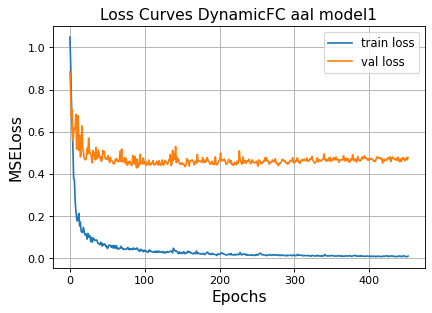

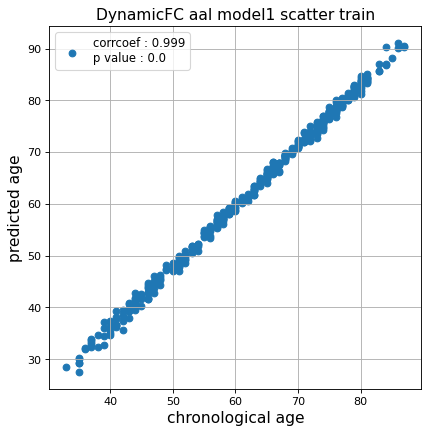

r^2 train data:  0.9659332467117708


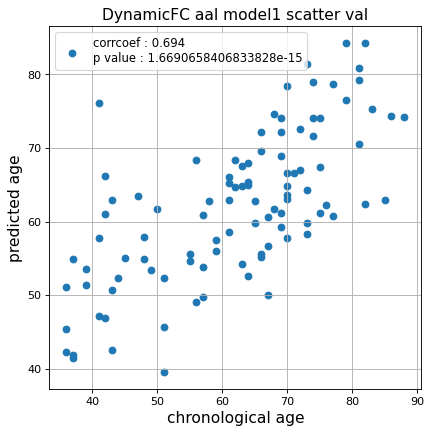

r^2 val data:  0.4790861974536824


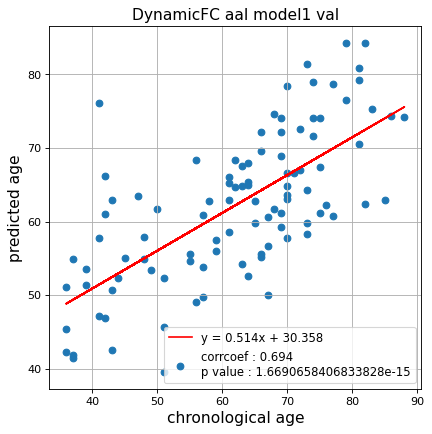

切片: 30.358044654559976
傾き: 0.5138070691110337
Kfold: 2 ::: epoch: 100, loss: 0.0398657860664221, val loss: 0.5590579807758331
Kfold: 2 ::: epoch: 200, loss: 0.028114602542840518, val loss: 0.4982515871524811
Kfold: 2 ::: epoch: 300, loss: 0.01437198811282332, val loss: 0.49187326431274414
Kfold: 2 ::: epoch: 400, loss: 0.010485330775666695, val loss: 0.4701257050037384
Kfold: 2 ::: epoch: 500, loss: 0.011517570354044437, val loss: 0.4959995746612549
Kfold: 2 ::: epoch: 600, loss: 0.009746788212886224, val loss: 0.5170973762869835
early stopping
save_epochs:460
best val loss:0.46060286462306976


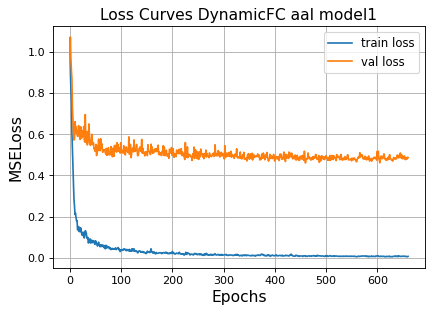

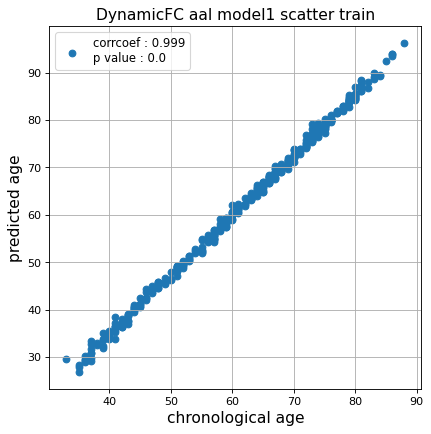

r^2 train data:  0.9255886962340758


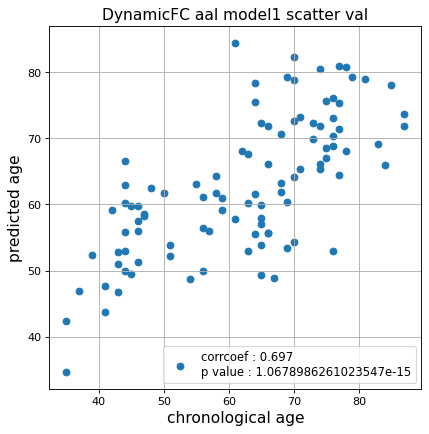

r^2 val data:  0.4785956972513363


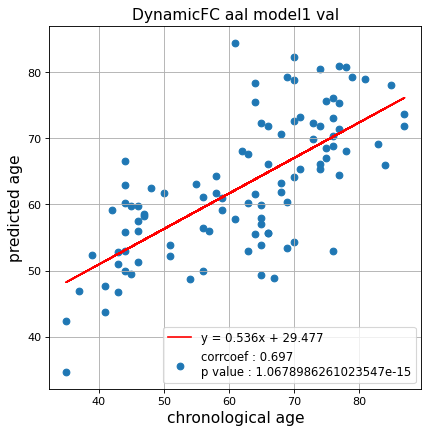

切片: 29.47677983134725
傾き: 0.5363587785308519
Kfold: 3 ::: epoch: 100, loss: 0.04491258097382692, val loss: 0.7714190483093262
Kfold: 3 ::: epoch: 200, loss: 0.025102025614334986, val loss: 0.6768227368593216
Kfold: 3 ::: epoch: 300, loss: 0.012867277917953638, val loss: 0.6289479285478592
Kfold: 3 ::: epoch: 400, loss: 0.012672584575529281, val loss: 0.6101316772401333
Kfold: 3 ::: epoch: 500, loss: 0.010379991923960356, val loss: 0.5770564302802086
Kfold: 3 ::: epoch: 600, loss: 0.011396661078414092, val loss: 0.5486467070877552
Kfold: 3 ::: epoch: 700, loss: 0.0066516665974631906, val loss: 0.5328965932130814
save_epochs:691
best val loss:0.5287565588951111


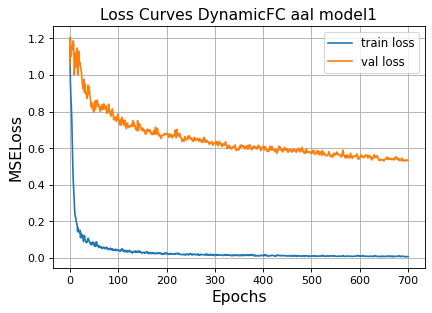

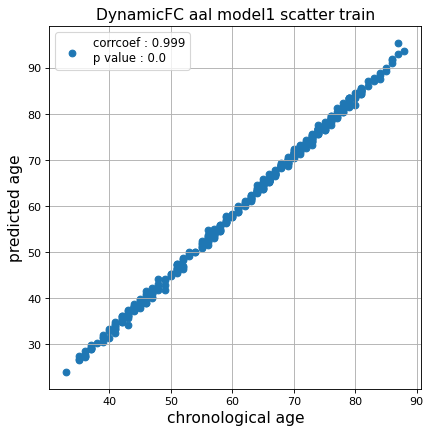

r^2 train data:  0.9125739444432209


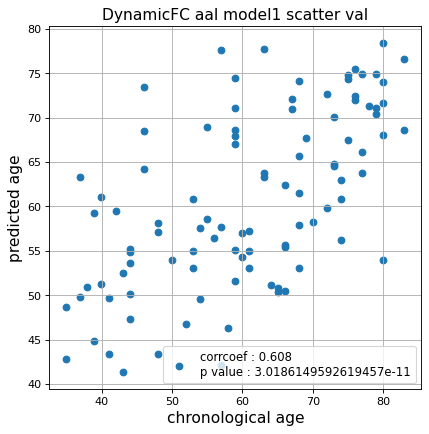

r^2 val data:  0.3575694731983541


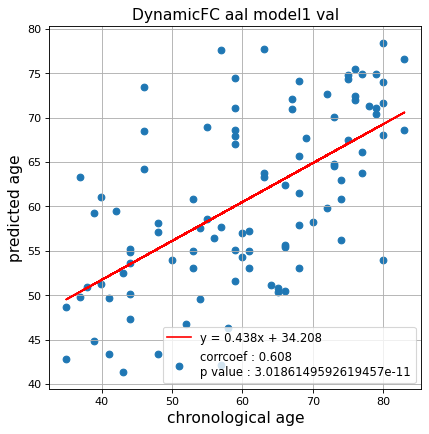

切片: 34.20800518040677
傾き: 0.438263497732249
Kfold: 4 ::: epoch: 100, loss: 0.03239653288171841, val loss: 0.81243896484375
Kfold: 4 ::: epoch: 200, loss: 0.01724645230346001, val loss: 0.8075846880674362
Kfold: 4 ::: epoch: 300, loss: 0.014794604208033819, val loss: 0.7551928609609604
Kfold: 4 ::: epoch: 400, loss: 0.009105120212412797, val loss: 0.7641901671886444
Kfold: 4 ::: epoch: 500, loss: 0.01007552555977152, val loss: 0.7899360060691833
early stopping
save_epochs:355
best val loss:0.693080946803093


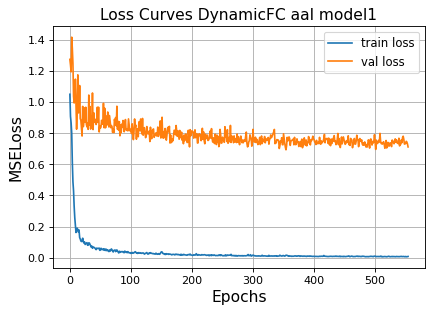

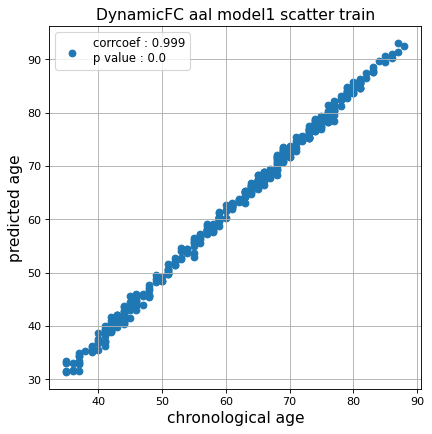

r^2 train data:  0.9535301730527317


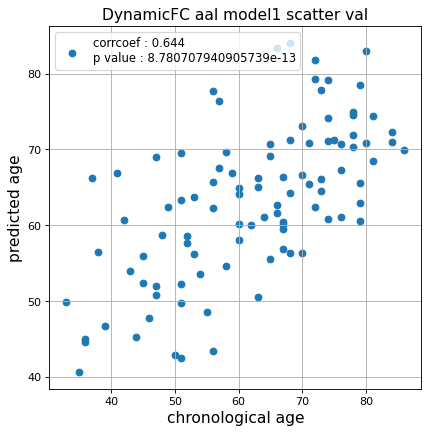

r^2 val data:  0.3950580699835473


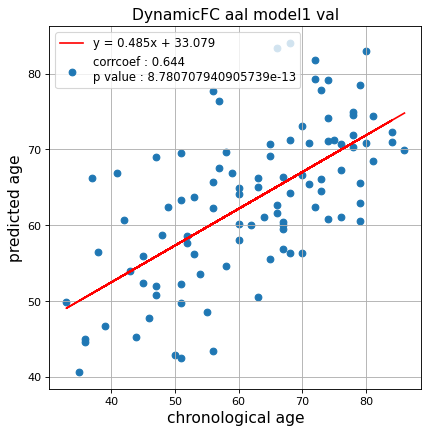

切片: 33.07907507015443
傾き: 0.4849835614971737
Kfold: 5 ::: epoch: 100, loss: 0.04055700580087992, val loss: 0.9413986280560493
Kfold: 5 ::: epoch: 200, loss: 0.022616039531735275, val loss: 0.9117499683052301
Kfold: 5 ::: epoch: 300, loss: 0.016097905257573493, val loss: 0.8833833634853363
Kfold: 5 ::: epoch: 400, loss: 0.013001897014104404, val loss: 0.8558689747005701
Kfold: 5 ::: epoch: 500, loss: 0.011593018730099384, val loss: 0.8295809179544449
Kfold: 5 ::: epoch: 600, loss: 0.009221753069701103, val loss: 0.8406502977013588
Kfold: 5 ::: epoch: 700, loss: 0.009545561463500444, val loss: 0.8367366902530193
save_epochs:608
best val loss:0.8162580393254757


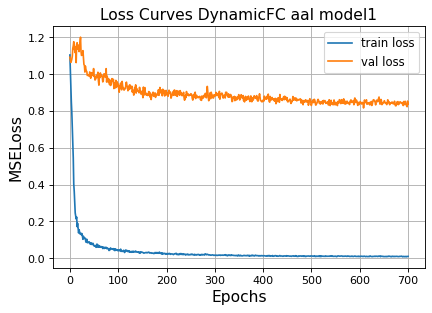

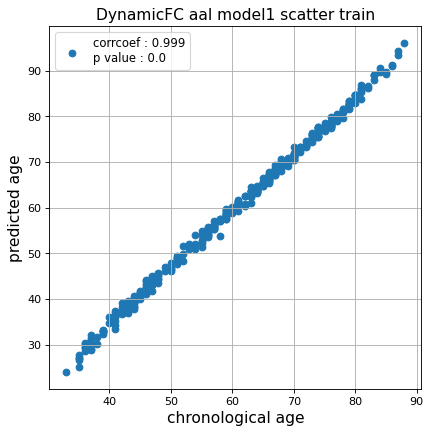

r^2 train data:  0.9409508656506147


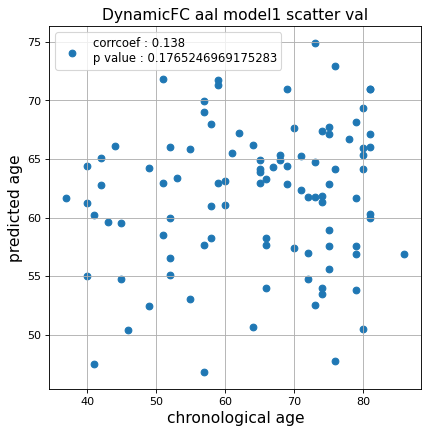

r^2 val data:  -0.14362309340266255


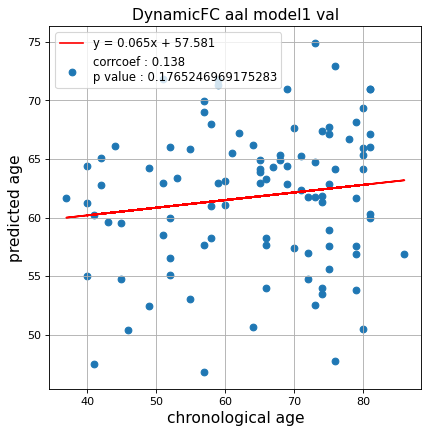

切片: 57.58149975334233
傾き: 0.06505041093631483
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.03962583653628826, val loss: 0.6554824411869049
Kfold: 1 ::: epoch: 200, loss: 0.01876228854346734, val loss: 0.6771956086158752
Kfold: 1 ::: epoch: 300, loss: 0.01358413527934597, val loss: 0.6865602731704712
Kfold: 1 ::: epoch: 400, loss: 0.010807381548847143, val loss: 0.6945240646600723
early stopping
save_epochs:233
best val loss:0.656292200088501


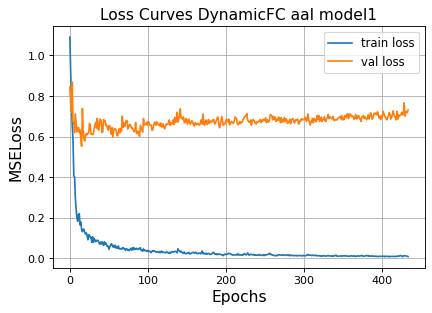

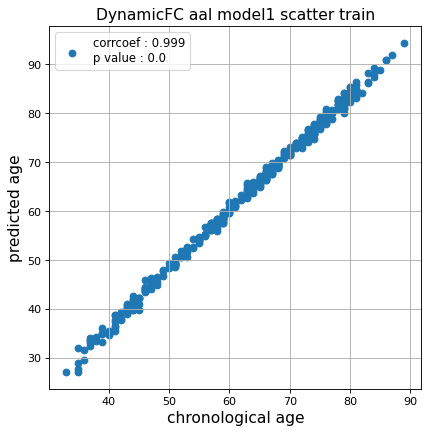

r^2 train data:  0.957948620949344


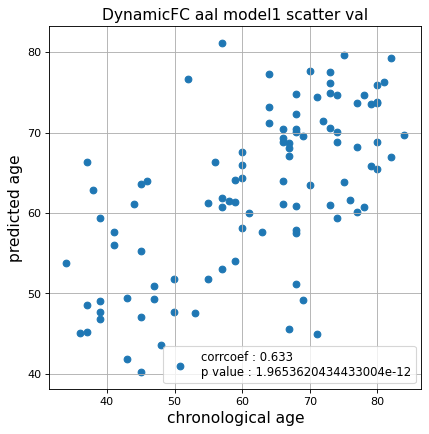

r^2 val data:  0.3857353275942842


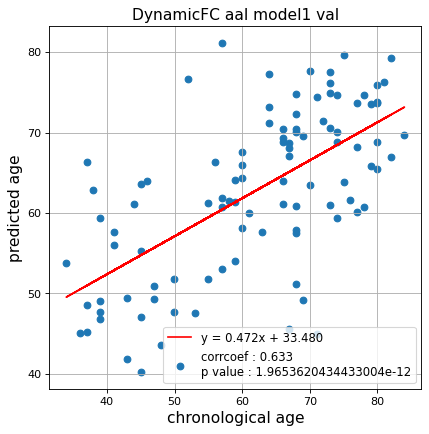

切片: 33.48003330866989
傾き: 0.47230208765681503
Kfold: 2 ::: epoch: 100, loss: 0.03444446408404754, val loss: 0.7190795466303825
Kfold: 2 ::: epoch: 200, loss: 0.016178990427691203, val loss: 0.6627575010061264
Kfold: 2 ::: epoch: 300, loss: 0.013206881542618457, val loss: 0.6606717854738235
Kfold: 2 ::: epoch: 400, loss: 0.010728283713643368, val loss: 0.6586316153407097
early stopping
save_epochs:285
best val loss:0.6115236505866051


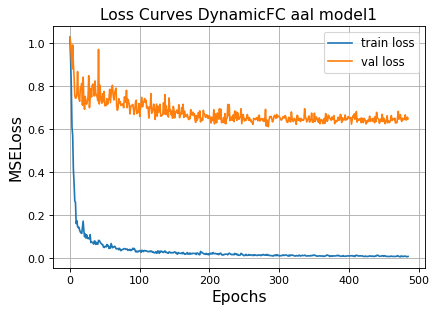

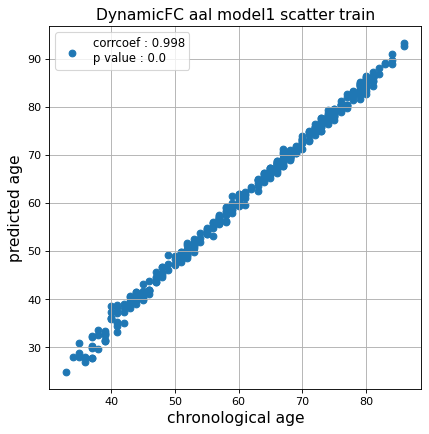

r^2 train data:  0.927494429111695


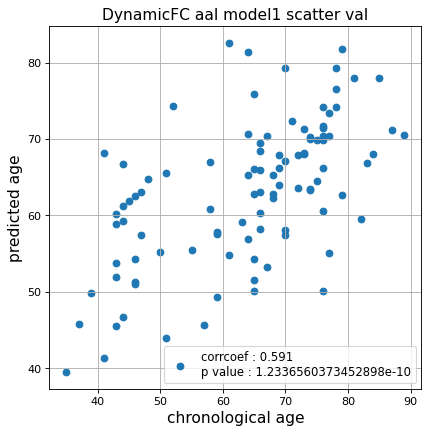

r^2 val data:  0.3333553692566975


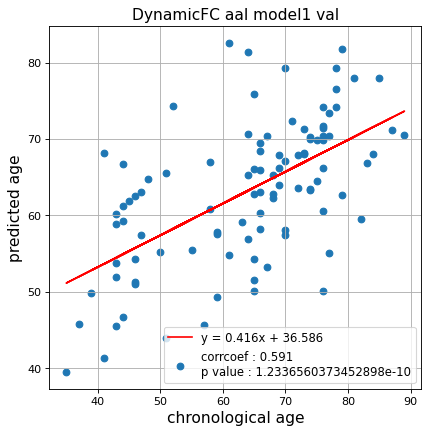

切片: 36.58618087260691
傾き: 0.41641804827723344
Kfold: 3 ::: epoch: 100, loss: 0.04419341253546568, val loss: 0.5357689633965492
Kfold: 3 ::: epoch: 200, loss: 0.030802852402512845, val loss: 0.5094391033053398
Kfold: 3 ::: epoch: 300, loss: 0.01707188641795745, val loss: 0.5148132368922234
Kfold: 3 ::: epoch: 400, loss: 0.014151559927715706, val loss: 0.5127798840403557
Kfold: 3 ::: epoch: 500, loss: 0.012473476441720357, val loss: 0.48478084057569504
Kfold: 3 ::: epoch: 600, loss: 0.008060532120557932, val loss: 0.4831544980406761
Kfold: 3 ::: epoch: 700, loss: 0.007452820212795184, val loss: 0.5250892862677574
save_epochs:593
best val loss:0.4707707315683365


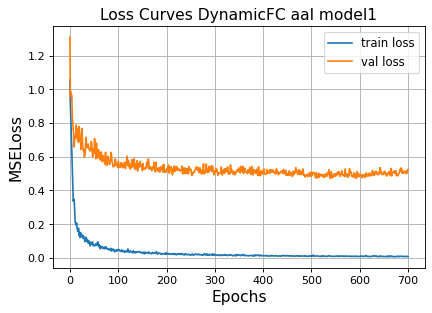

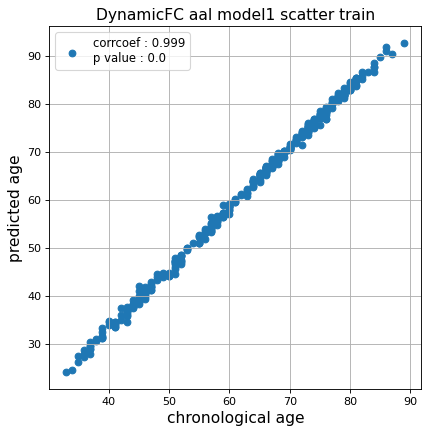

r^2 train data:  0.9247199802438145


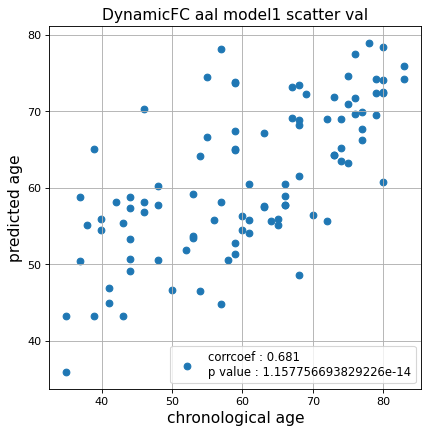

r^2 val data:  0.4610397274113286


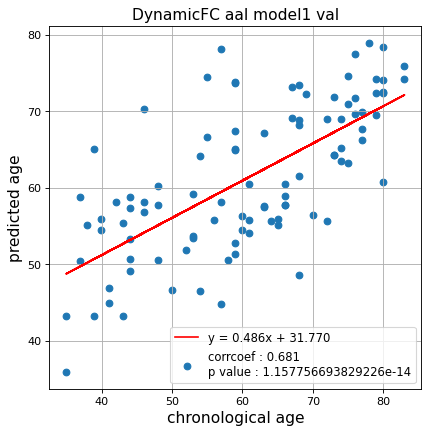

切片: 31.770044375231137
傾き: 0.48624195135694176
Kfold: 4 ::: epoch: 100, loss: 0.03852801239834382, val loss: 0.8324778079986572
Kfold: 4 ::: epoch: 200, loss: 0.019993924320890352, val loss: 0.7979091554880142
Kfold: 4 ::: epoch: 300, loss: 0.022226657503499433, val loss: 0.7964625656604767
Kfold: 4 ::: epoch: 400, loss: 0.008537553035869049, val loss: 0.8618606775999069
early stopping
save_epochs:207
best val loss:0.7547383457422256


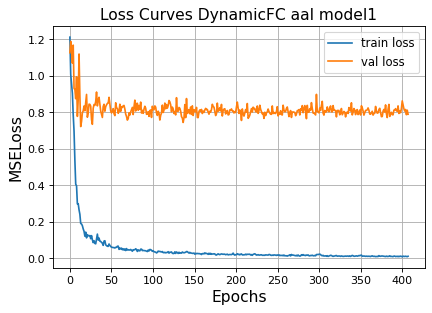

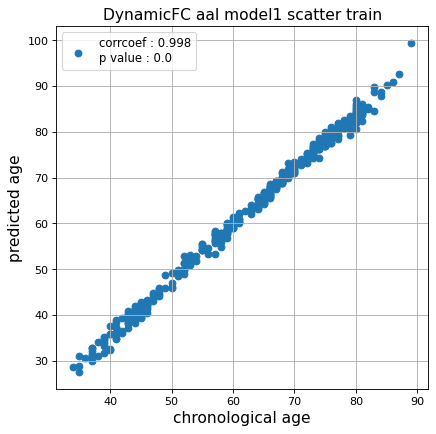

r^2 train data:  0.9463338774041272


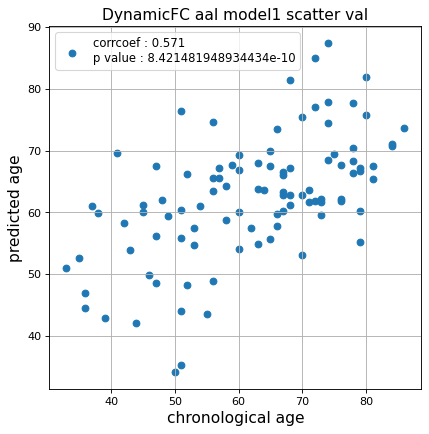

r^2 val data:  0.29272238167412723


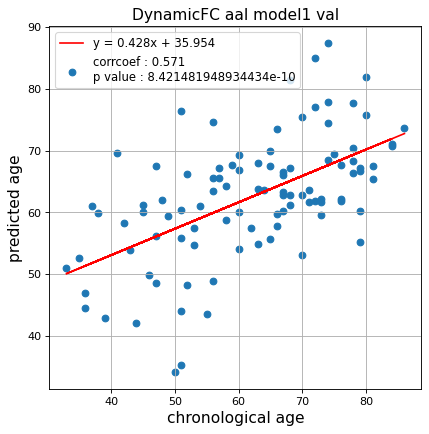

切片: 35.95438476580259
傾き: 0.42782793247457723
Kfold: 5 ::: epoch: 100, loss: 0.03675062094743435, val loss: 0.6988640874624252
Kfold: 5 ::: epoch: 200, loss: 0.023612049766457997, val loss: 0.7844466269016266
Kfold: 5 ::: epoch: 300, loss: 0.014758249386571921, val loss: 0.6984120383858681
Kfold: 5 ::: epoch: 400, loss: 0.0102630233248839, val loss: 0.6856349855661392
Kfold: 5 ::: epoch: 500, loss: 0.007399371001296318, val loss: 0.698352262377739
Kfold: 5 ::: epoch: 600, loss: 0.007567390154760618, val loss: 0.7162434533238411
early stopping
save_epochs:407
best val loss:0.6595813632011414


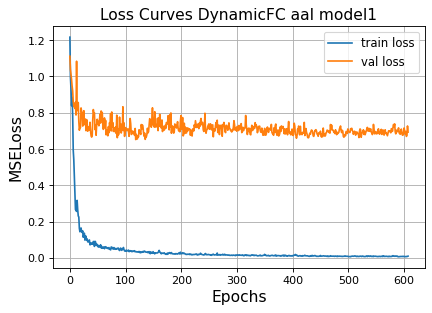

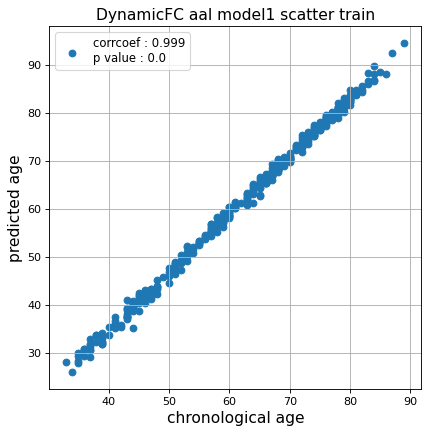

r^2 train data:  0.948212410219556


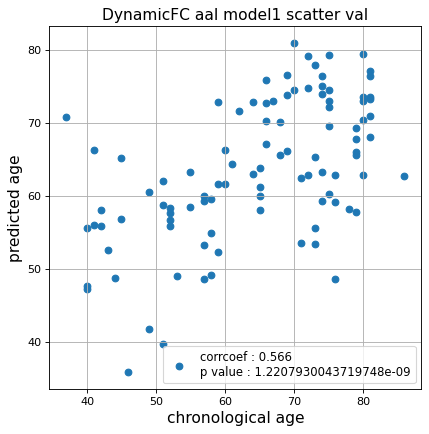

r^2 val data:  0.28054894738421376


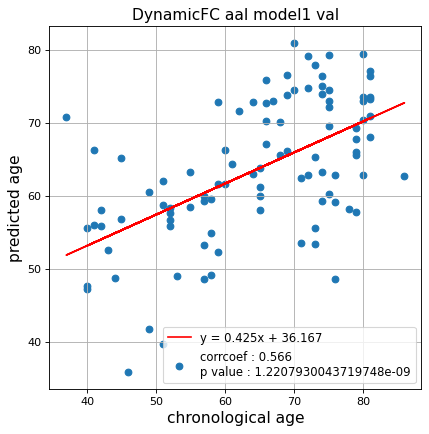

切片: 36.167279754245705
傾き: 0.4248551977860158
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.03638536440065274, val loss: 0.7252317816019058
Kfold: 1 ::: epoch: 200, loss: 0.01909500754509981, val loss: 0.7390817105770111
Kfold: 1 ::: epoch: 300, loss: 0.013285424345387863, val loss: 0.7353847324848175
Kfold: 1 ::: epoch: 400, loss: 0.010366943199187517, val loss: 0.7552930861711502
early stopping
save_epochs:215
best val loss:0.7095584869384766


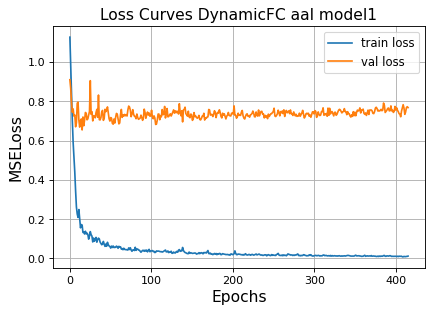

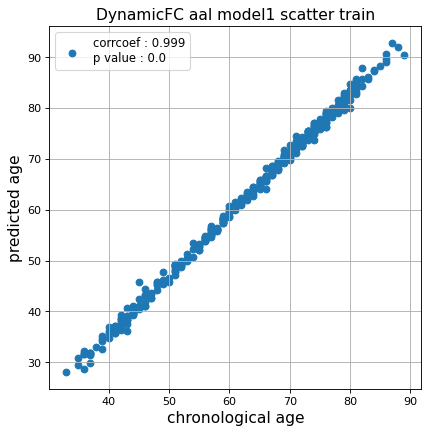

r^2 train data:  0.9606765402120152


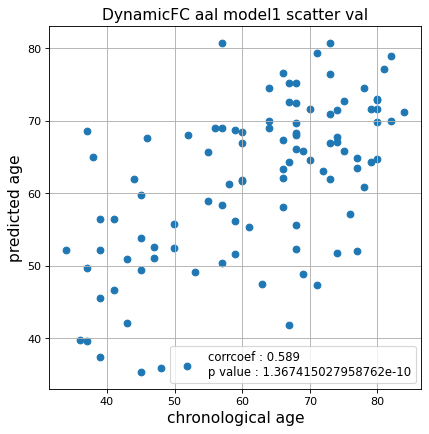

r^2 val data:  0.3081215072742777


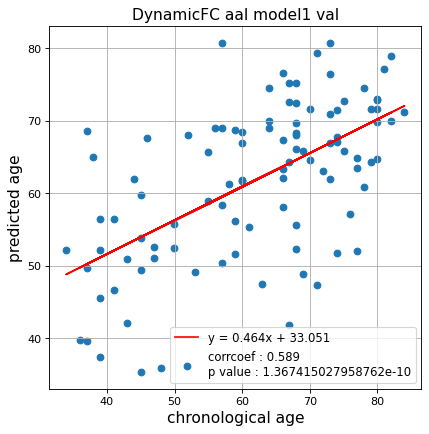

切片: 33.050807372287395
傾き: 0.4642595416774319
Kfold: 2 ::: epoch: 100, loss: 0.039379532234026834, val loss: 0.733118336647749
Kfold: 2 ::: epoch: 200, loss: 0.026578358159615442, val loss: 0.7187048345804214
Kfold: 2 ::: epoch: 300, loss: 0.01637957230783426, val loss: 0.7079995926469564
Kfold: 2 ::: epoch: 400, loss: 0.012328990591833225, val loss: 0.6955044623464346
Kfold: 2 ::: epoch: 500, loss: 0.011282944944328986, val loss: 0.7051854804158211
Kfold: 2 ::: epoch: 600, loss: 0.00897557227514111, val loss: 0.6967837568372488
Kfold: 2 ::: epoch: 700, loss: 0.009107872951202668, val loss: 0.6922644283622503
save_epochs:506
best val loss:0.6764095984399319


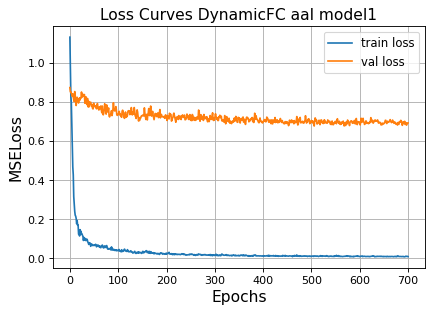

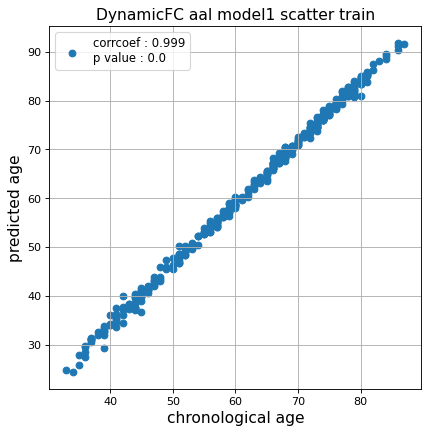

r^2 train data:  0.9333801509065524


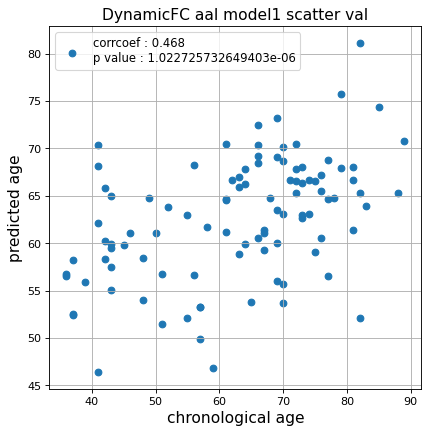

r^2 val data:  0.219093039976882


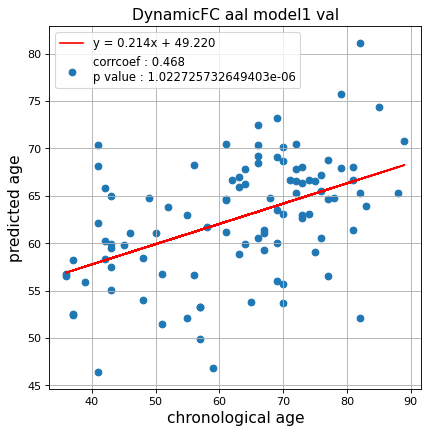

切片: 49.21953089189627
傾き: 0.21373275905123307
Kfold: 3 ::: epoch: 100, loss: 0.04075509954530459, val loss: 0.5587032288312912
Kfold: 3 ::: epoch: 200, loss: 0.020478467528636638, val loss: 0.5547476261854172
Kfold: 3 ::: epoch: 300, loss: 0.014821184512514334, val loss: 0.5452349856495857
Kfold: 3 ::: epoch: 400, loss: 0.011453202262950631, val loss: 0.5542326420545578
early stopping
save_epochs:240
best val loss:0.5254757776856422


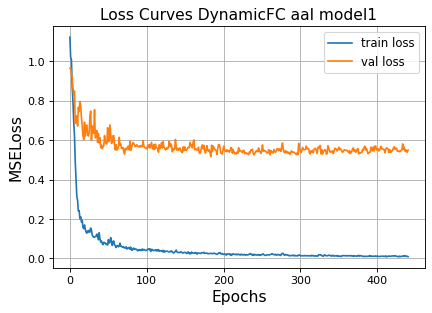

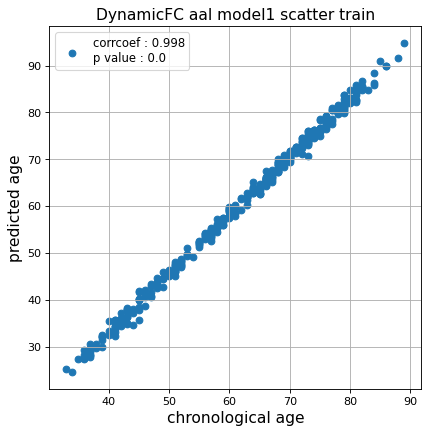

r^2 train data:  0.9271681091194517


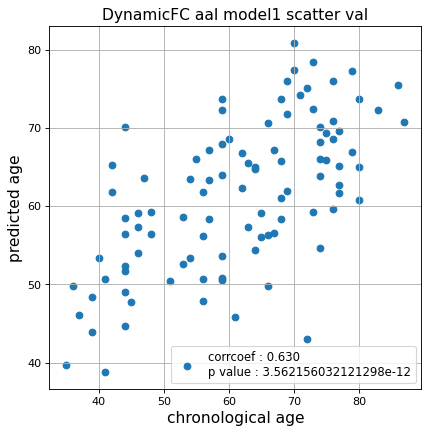

r^2 val data:  0.3887189910369774


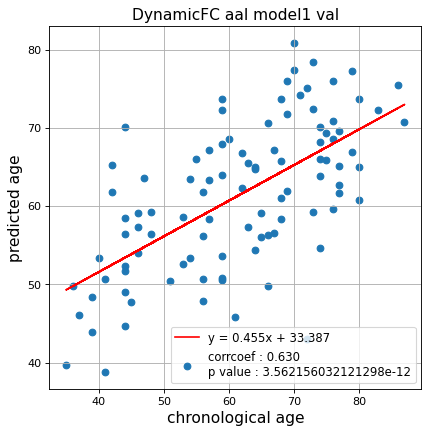

切片: 33.38652584870932
傾き: 0.4551819688360555
Kfold: 4 ::: epoch: 100, loss: 0.047602046066178724, val loss: 1.2122406512498856
Kfold: 4 ::: epoch: 200, loss: 0.02093947707460477, val loss: 1.0532588362693787
Kfold: 4 ::: epoch: 300, loss: 0.013580943636882763, val loss: 1.0372153967618942
Kfold: 4 ::: epoch: 400, loss: 0.014813851135281416, val loss: 1.0309554040431976
Kfold: 4 ::: epoch: 500, loss: 0.007537654636857601, val loss: 1.0382948070764542
Kfold: 4 ::: epoch: 600, loss: 0.008411285431625752, val loss: 1.0171764343976974
early stopping
save_epochs:452
best val loss:0.958341121673584


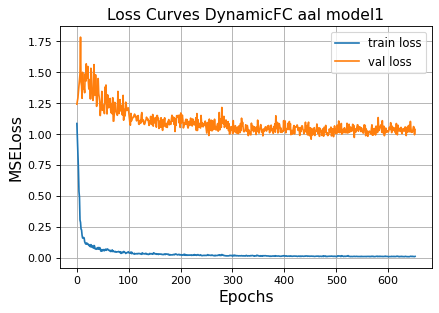

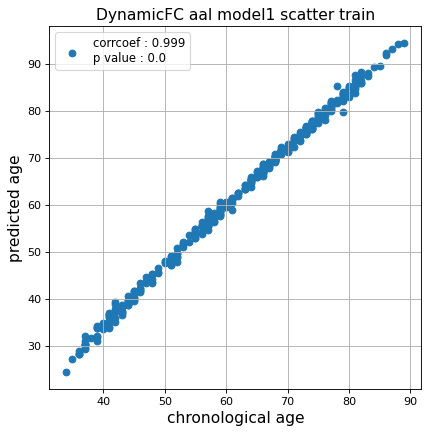

r^2 train data:  0.931858976186599


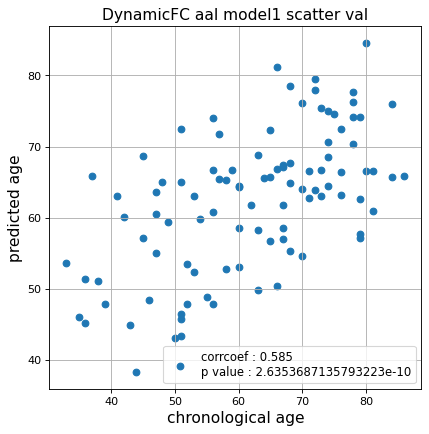

r^2 val data:  0.3180925521293332


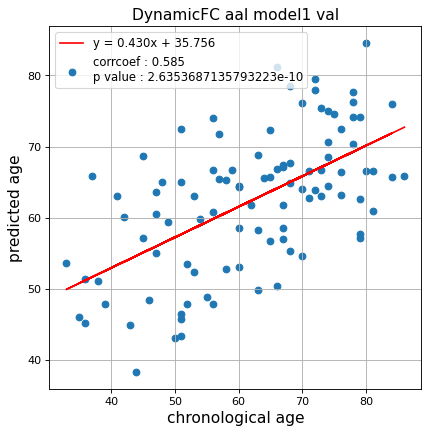

切片: 35.756462538494205
傾き: 0.4297800551865085
Kfold: 5 ::: epoch: 100, loss: 0.0451433127029584, val loss: 0.8188375383615494
Kfold: 5 ::: epoch: 200, loss: 0.02440116382562197, val loss: 0.7426005825400352
Kfold: 5 ::: epoch: 300, loss: 0.016045792314868707, val loss: 0.7346258535981178
Kfold: 5 ::: epoch: 400, loss: 0.015834489299987372, val loss: 0.7539848163723946
Kfold: 5 ::: epoch: 500, loss: 0.012112366429601725, val loss: 0.7339447736740112
Kfold: 5 ::: epoch: 600, loss: 0.010428064610235967, val loss: 0.6870085746049881
Kfold: 5 ::: epoch: 700, loss: 0.009811039763287855, val loss: 0.6520806327462196
save_epochs:675
best val loss:0.6488374844193459


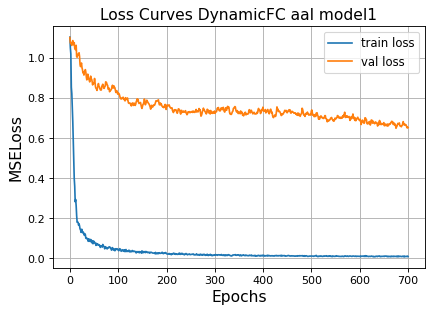

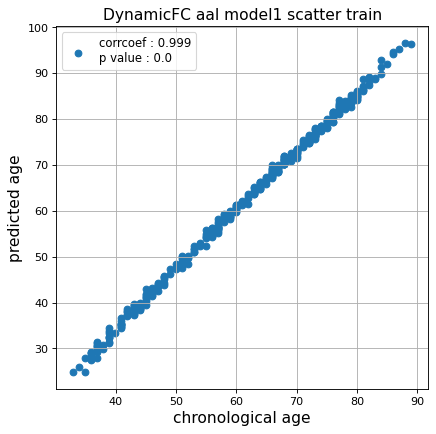

r^2 train data:  0.9107795708967175


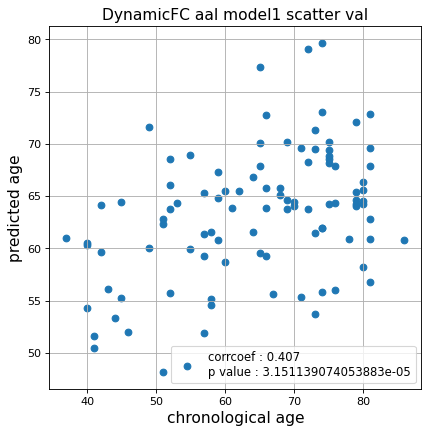

r^2 val data:  0.15118706179463615


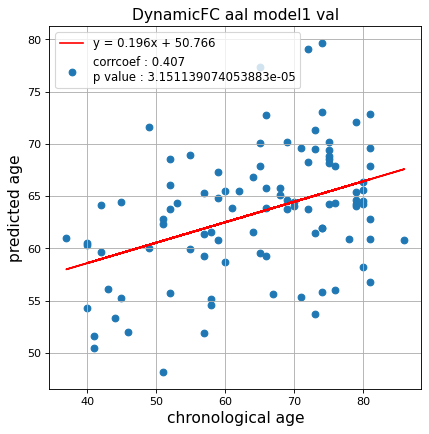

切片: 50.76566874910401
傾き: 0.19562254107628663
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.03955732687161519, val loss: 0.6120701283216476
Kfold: 1 ::: epoch: 200, loss: 0.019229807102909453, val loss: 0.6347700953483582
Kfold: 1 ::: epoch: 300, loss: 0.014356566664691154, val loss: 0.6363885700702667
Kfold: 1 ::: epoch: 400, loss: 0.010434149370457117, val loss: 0.6636615246534348
early stopping
save_epochs:219
best val loss:0.6118416637182236


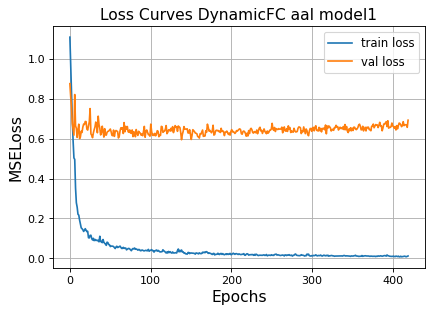

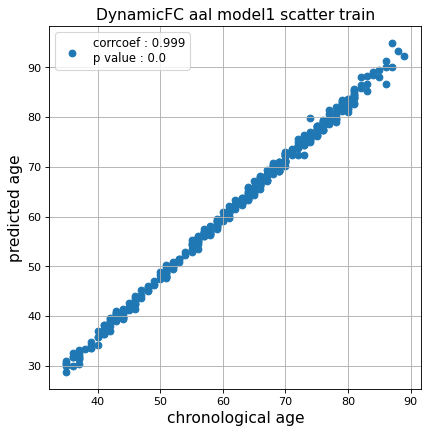

r^2 train data:  0.962830176194505


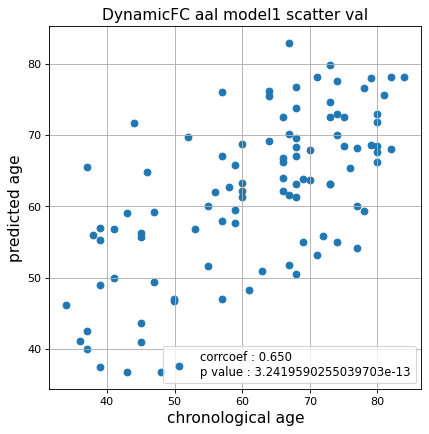

r^2 val data:  0.40183391049450956


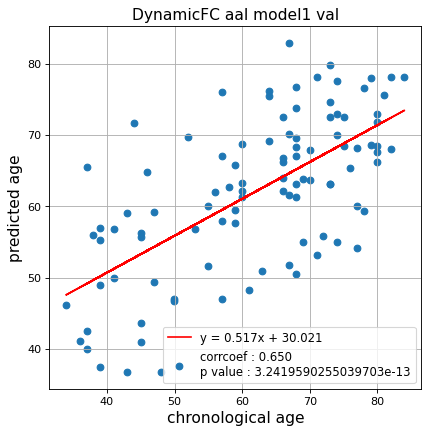

切片: 30.021292577190138
傾き: 0.5170807030568171
Kfold: 2 ::: epoch: 100, loss: 0.04548634316485662, val loss: 0.786177858710289
Kfold: 2 ::: epoch: 200, loss: 0.020152391865849495, val loss: 0.6678862795233727
Kfold: 2 ::: epoch: 300, loss: 0.01770263476870381, val loss: 0.6147138550877571
Kfold: 2 ::: epoch: 400, loss: 0.013975001334284361, val loss: 0.6052498891949654
Kfold: 2 ::: epoch: 500, loss: 0.011453713648594342, val loss: 0.617372453212738
Kfold: 2 ::: epoch: 600, loss: 0.01257395214186265, val loss: 0.6186593323945999
Kfold: 2 ::: epoch: 700, loss: 0.009843388070853857, val loss: 0.6370891183614731
save_epochs:535
best val loss:0.5847982317209244


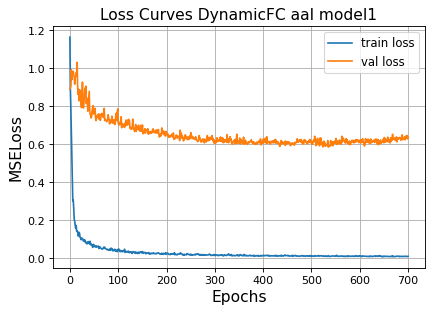

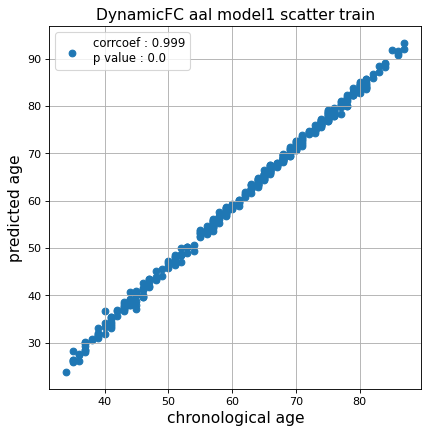

r^2 train data:  0.9247017549305189


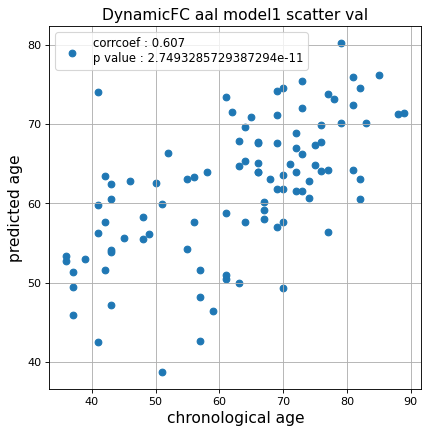

r^2 val data:  0.365780475872558


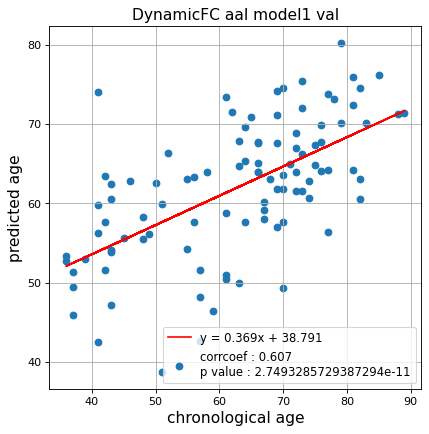

切片: 38.79116723323486
傾き: 0.36927645130572606
Kfold: 3 ::: epoch: 100, loss: 0.03997919378945461, val loss: 0.5747942589223385
Kfold: 3 ::: epoch: 200, loss: 0.02390668082695741, val loss: 0.5654177479445934
Kfold: 3 ::: epoch: 300, loss: 0.01620958924580079, val loss: 0.5369563400745392
Kfold: 3 ::: epoch: 400, loss: 0.013389032692290269, val loss: 0.5277684926986694
Kfold: 3 ::: epoch: 500, loss: 0.011492265316729363, val loss: 0.5174632146954536
Kfold: 3 ::: epoch: 600, loss: 0.009731312461483937, val loss: 0.5009111948311329
Kfold: 3 ::: epoch: 700, loss: 0.007913785986602306, val loss: 0.508584126830101
save_epochs:604
best val loss:0.48146572709083557


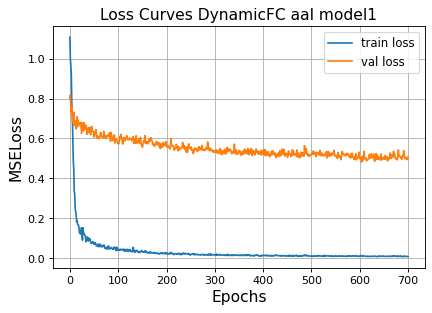

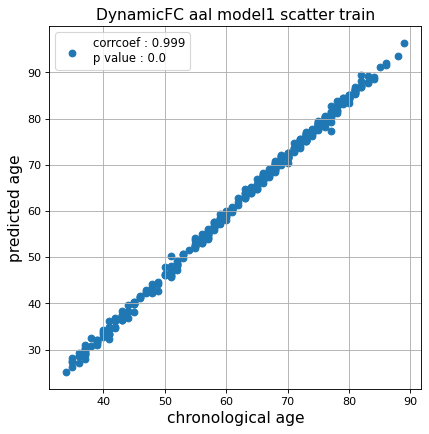

r^2 train data:  0.9131540533198068


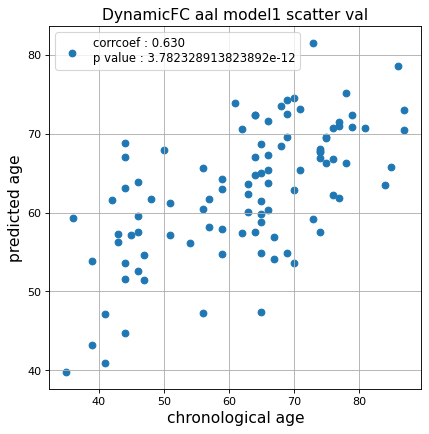

r^2 val data:  0.3959426484364845


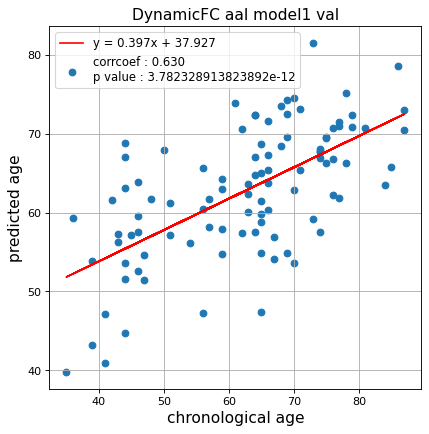

切片: 37.92689214136249
傾き: 0.3973729116316405
Kfold: 4 ::: epoch: 100, loss: 0.0382326553360774, val loss: 0.8024383634328842
Kfold: 4 ::: epoch: 200, loss: 0.02383086558144826, val loss: 0.8692219853401184
Kfold: 4 ::: epoch: 300, loss: 0.013232798960346442, val loss: 0.7976277768611908
Kfold: 4 ::: epoch: 400, loss: 0.01478127626558909, val loss: 0.8214953243732452
early stopping
save_epochs:210
best val loss:0.7492963075637817


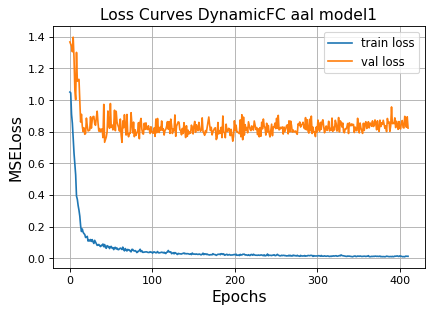

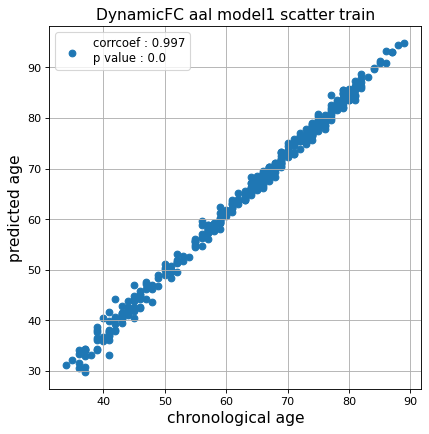

r^2 train data:  0.9432437397140858


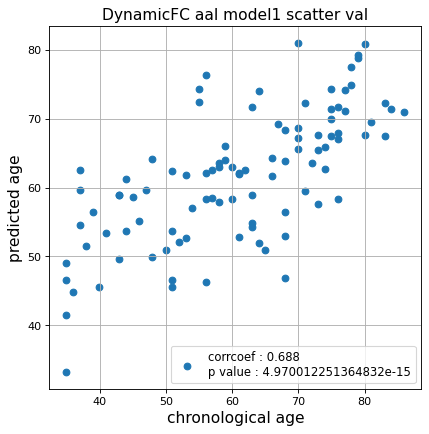

r^2 val data:  0.4700439452776197


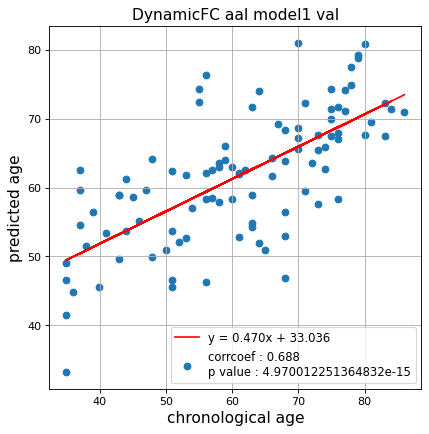

切片: 33.03565933080149
傾き: 0.47018624080667637
Kfold: 5 ::: epoch: 100, loss: 0.04365183155124004, val loss: 0.8691483736038208
Kfold: 5 ::: epoch: 200, loss: 0.021972858490279086, val loss: 0.7776368409395218
Kfold: 5 ::: epoch: 300, loss: 0.018739550661009092, val loss: 0.6647221520543098
Kfold: 5 ::: epoch: 400, loss: 0.010212696443956632, val loss: 0.6217513382434845
Kfold: 5 ::: epoch: 500, loss: 0.010388110047922684, val loss: 0.5661895275115967
Kfold: 5 ::: epoch: 600, loss: 0.008286822014130078, val loss: 0.5776540376245975
Kfold: 5 ::: epoch: 700, loss: 0.006988988544505376, val loss: 0.5502205304801464
save_epochs:659
best val loss:0.5317816734313965


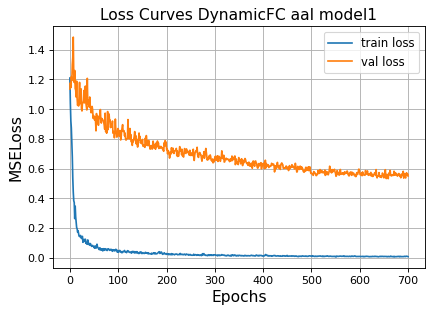

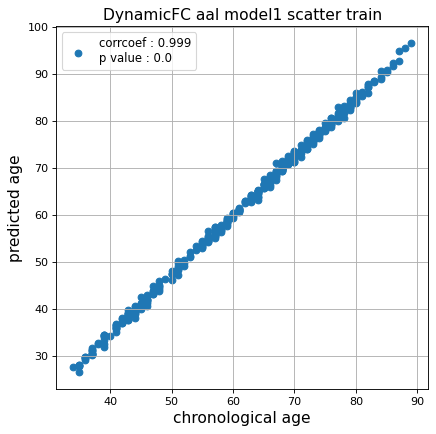

r^2 train data:  0.9349867761417874


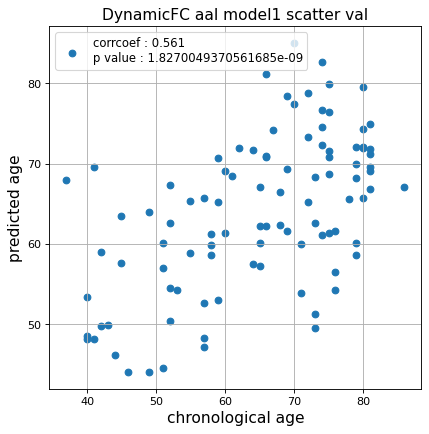

r^2 val data:  0.2745234870045933


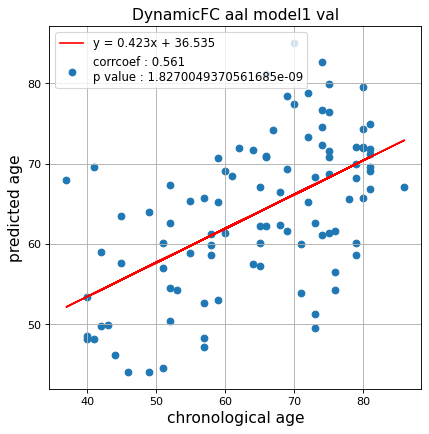

切片: 36.534801623569265
傾き: 0.4229746776057896
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.0374057639676791, val loss: 0.6706471741199493
Kfold: 1 ::: epoch: 200, loss: 0.02007438686604683, val loss: 0.7253010272979736
Kfold: 1 ::: epoch: 300, loss: 0.01657259206359203, val loss: 0.7117246687412262
Kfold: 1 ::: epoch: 400, loss: 0.009778603015897365, val loss: 0.7900032252073288
early stopping
save_epochs:221
best val loss:0.686698392033577


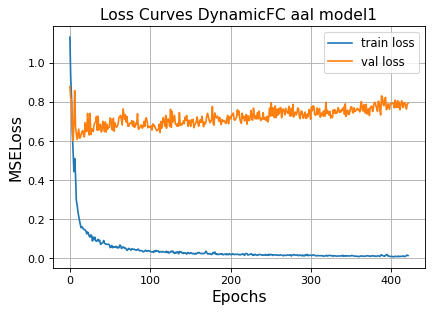

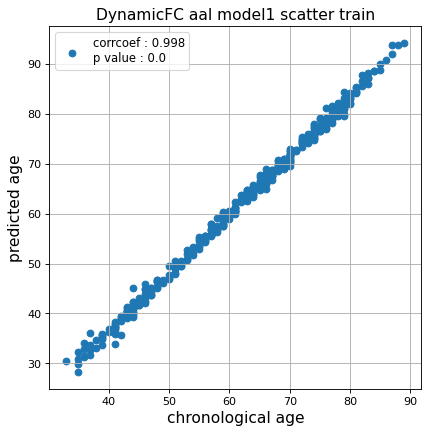

r^2 train data:  0.9647042426498952


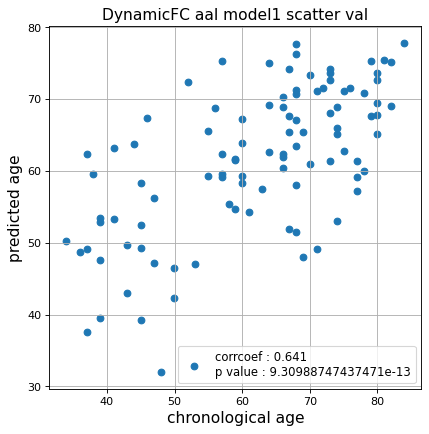

r^2 val data:  0.39978701949237927


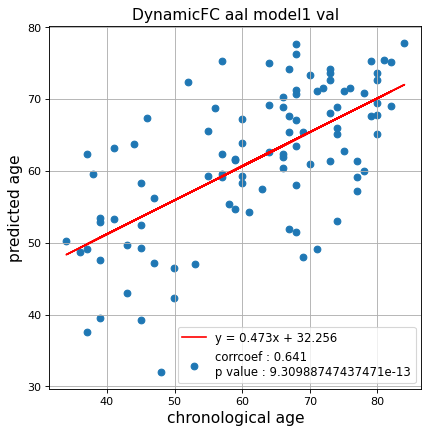

切片: 32.256262651416364
傾き: 0.47317835360347493
Kfold: 2 ::: epoch: 100, loss: 0.041874788844814666, val loss: 0.8282861113548279
Kfold: 2 ::: epoch: 200, loss: 0.02129136534551015, val loss: 0.8000379502773285
Kfold: 2 ::: epoch: 300, loss: 0.015284740079480868, val loss: 0.8256751894950867
Kfold: 2 ::: epoch: 400, loss: 0.0130572382074136, val loss: 0.8385692536830902
early stopping
save_epochs:206
best val loss:0.8123728036880493


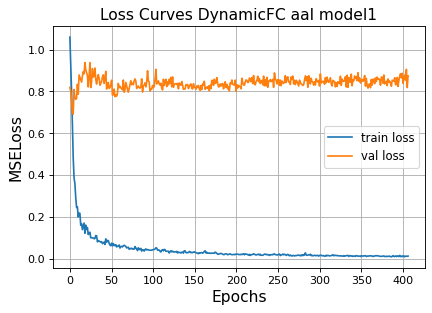

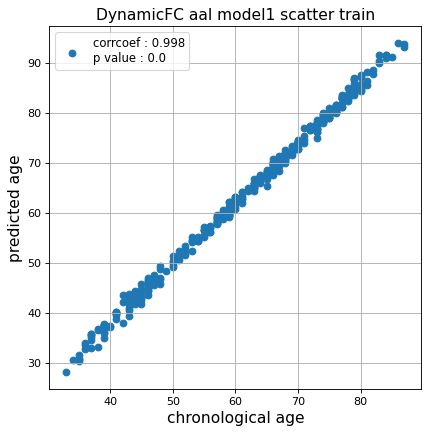

r^2 train data:  0.9290462085878555


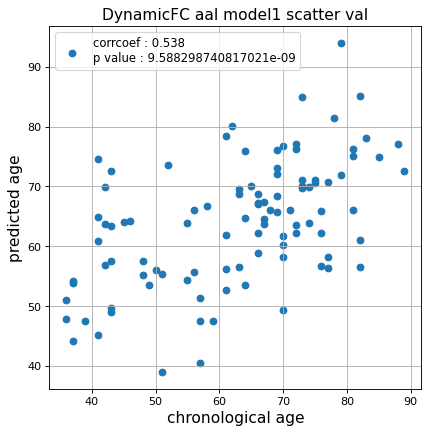

r^2 val data:  0.23989121491448528


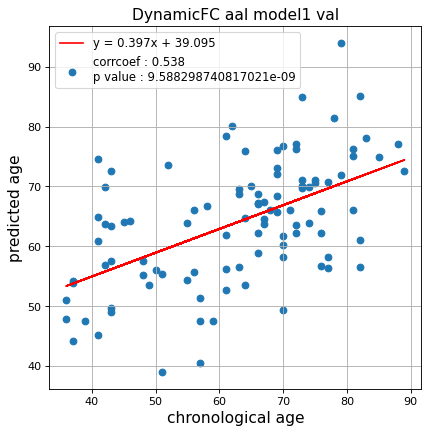

切片: 39.095281656996065
傾き: 0.39692339919358754
Kfold: 3 ::: epoch: 100, loss: 0.04394488538113924, val loss: 0.46856169402599335
Kfold: 3 ::: epoch: 200, loss: 0.02458665706217289, val loss: 0.4411316365003586
Kfold: 3 ::: epoch: 300, loss: 0.017538951638226326, val loss: 0.4401237666606903
Kfold: 3 ::: epoch: 400, loss: 0.01616462986343182, val loss: 0.4460640475153923
Kfold: 3 ::: epoch: 500, loss: 0.011344346289451305, val loss: 0.441744364798069
Kfold: 3 ::: epoch: 600, loss: 0.009531667169470053, val loss: 0.4518106132745743
early stopping
save_epochs:404
best val loss:0.4173160642385483


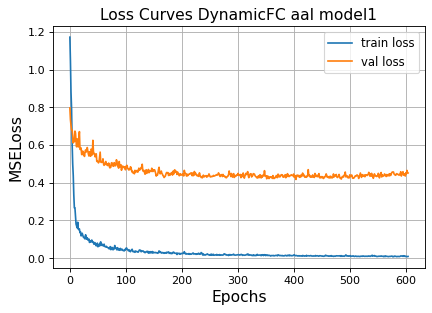

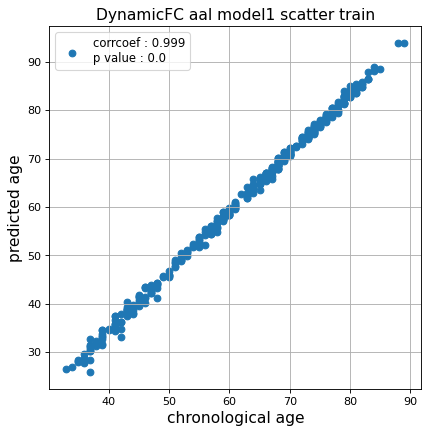

r^2 train data:  0.9431237819116917


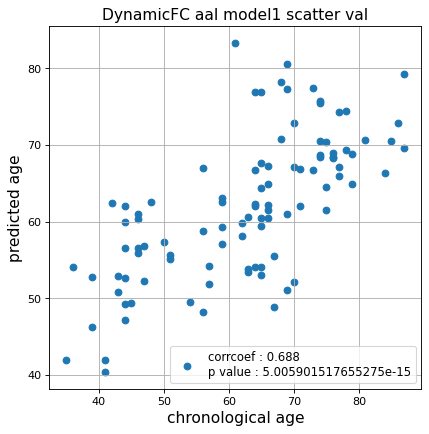

r^2 val data:  0.4717463028731157


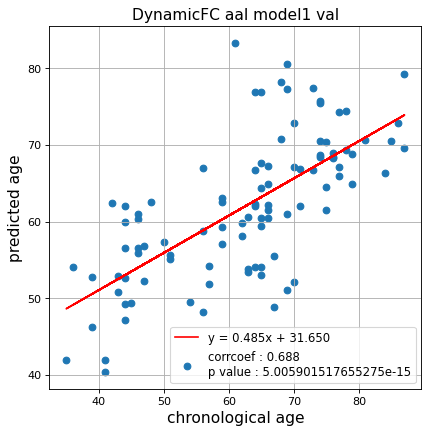

切片: 31.64998835799301
傾き: 0.4854795459907994
Kfold: 4 ::: epoch: 100, loss: 0.04050782093634972, val loss: 0.7007749229669571
Kfold: 4 ::: epoch: 200, loss: 0.02261107672865574, val loss: 0.610793262720108
Kfold: 4 ::: epoch: 300, loss: 0.014343879902018951, val loss: 0.5700300931930542
Kfold: 4 ::: epoch: 400, loss: 0.011112108683356872, val loss: 0.5429159253835678
Kfold: 4 ::: epoch: 500, loss: 0.00919532933487342, val loss: 0.5301167741417885
Kfold: 4 ::: epoch: 600, loss: 0.009882373986049341, val loss: 0.5241107195615768
Kfold: 4 ::: epoch: 700, loss: 0.006632553950811808, val loss: 0.5147563964128494
save_epochs:699
best val loss:0.4988836646080017


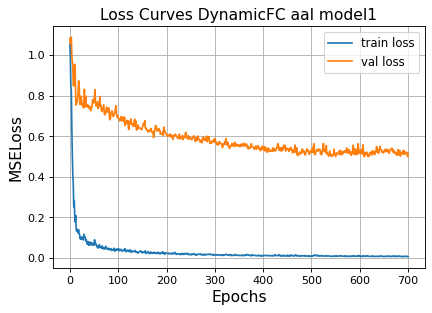

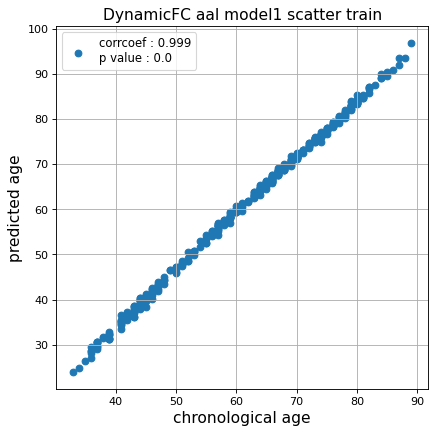

r^2 train data:  0.9333045074141275


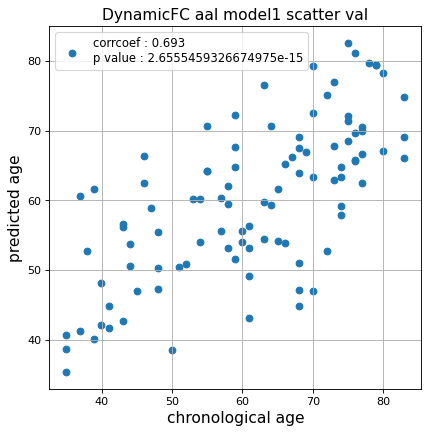

r^2 val data:  0.45768904914566544


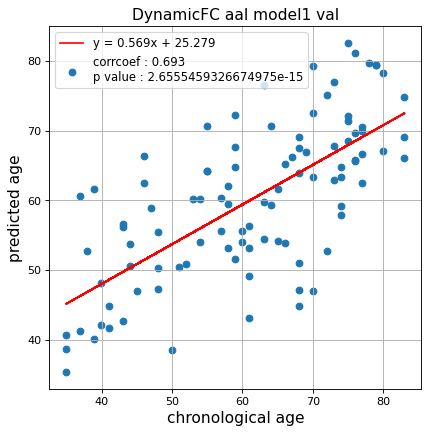

切片: 25.27874636204143
傾き: 0.5689144598625218
Kfold: 5 ::: epoch: 100, loss: 0.031966146583167404, val loss: 0.7529028803110123
Kfold: 5 ::: epoch: 200, loss: 0.01784706301987171, val loss: 0.7517216950654984
Kfold: 5 ::: epoch: 300, loss: 0.0130475780998285, val loss: 0.7877275198698044
Kfold: 5 ::: epoch: 400, loss: 0.00936827865930704, val loss: 0.7694918811321259
early stopping
save_epochs:236
best val loss:0.7134722024202347


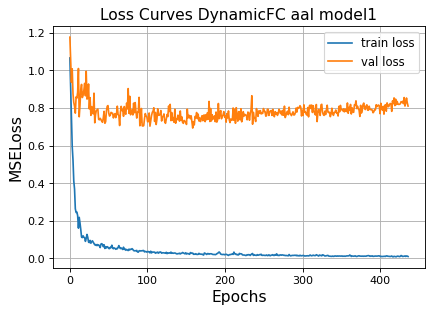

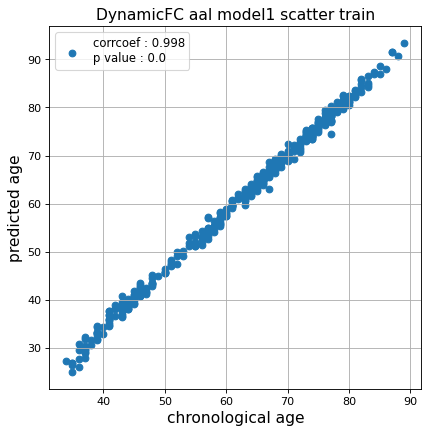

r^2 train data:  0.9453003033483854


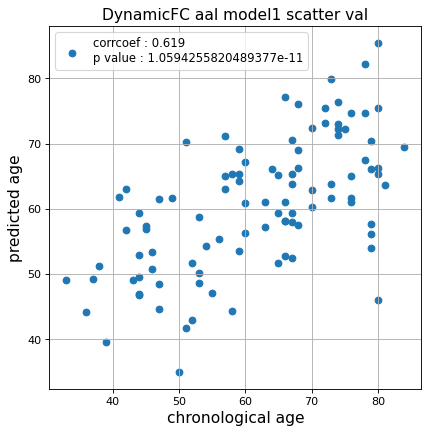

r^2 val data:  0.3522889492924146


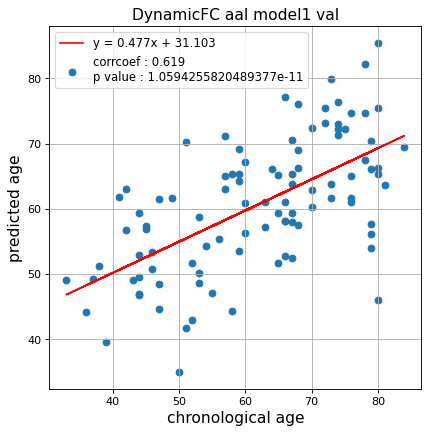

切片: 31.102949374215317
傾き: 0.4772673959111835
CPU times: user 1h 18min 12s, sys: 53min 30s, total: 2h 11min 43s
Wall time: 3h 35min 44s


In [22]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_1  = []
test_pred_aal_dynamic_corrected_1  = []
test_label_aal_dynamic_1 = []
test_idx_aal_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop   = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model1'
                                                          )
    
    test_pred_aal_dynamic_1.append(test_pred)
    test_pred_aal_dynamic_corrected_1.append(test_pred_corrected)
    test_label_aal_dynamic_1.append(test_label)
    test_idx_aal_dynamic_1.append(test_idx)

### Dynamic FC 2

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.03798338813850513, val loss: 0.48302463442087173
Kfold: 1 ::: epoch: 200, loss: 0.019480935154626004, val loss: 0.5146004110574722
Kfold: 1 ::: epoch: 300, loss: 0.015884995102309264, val loss: 0.48753200098872185
Kfold: 1 ::: epoch: 400, loss: 0.011080724760316886, val loss: 0.5034864097833633
early stopping
save_epochs:252
best val loss:0.46399740874767303


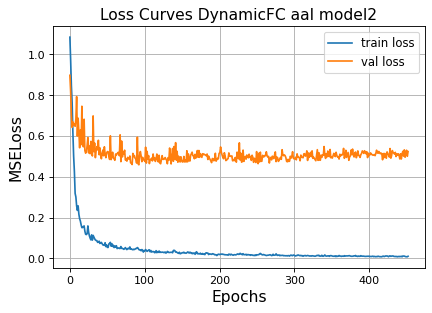

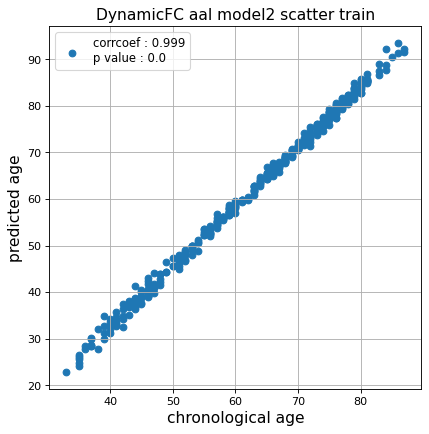

r^2 train data:  0.9114734964054002


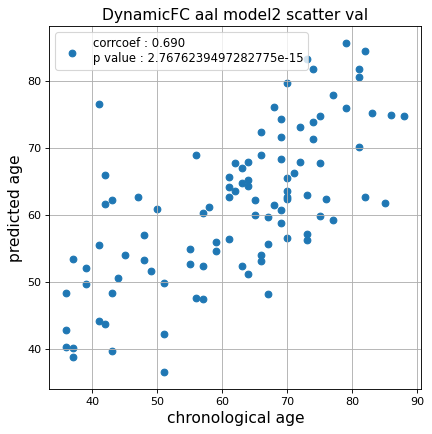

r^2 val data:  0.45939948912821327


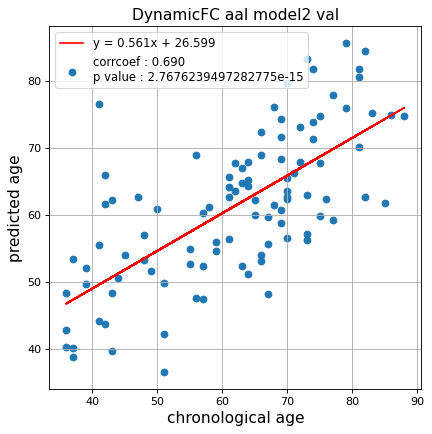

切片: 26.599354551751176
傾き: 0.5611745167541312
Kfold: 2 ::: epoch: 200, loss: 0.02660336266629971, val loss: 0.47517719492316246
Kfold: 2 ::: epoch: 300, loss: 0.0140169863230907, val loss: 0.4926440417766571
Kfold: 2 ::: epoch: 400, loss: 0.010174457377825793, val loss: 0.4718971624970436
early stopping
save_epochs:252
best val loss:0.4561192952096462


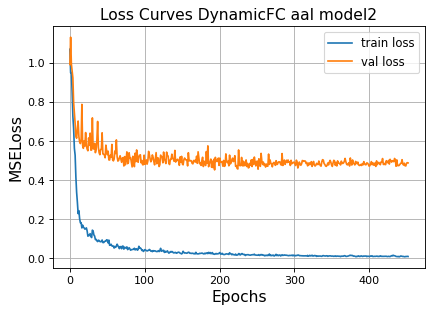

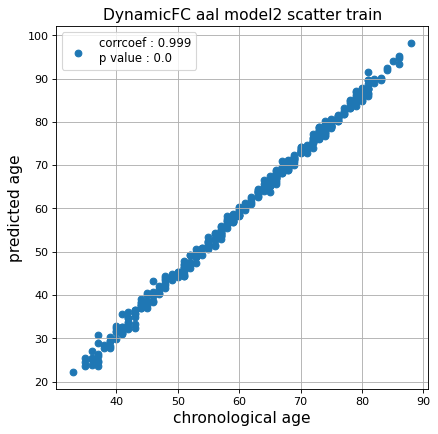

r^2 train data:  0.8451741421391412


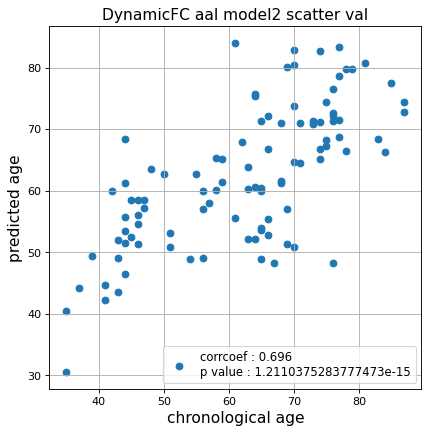

r^2 val data:  0.4657611420408292


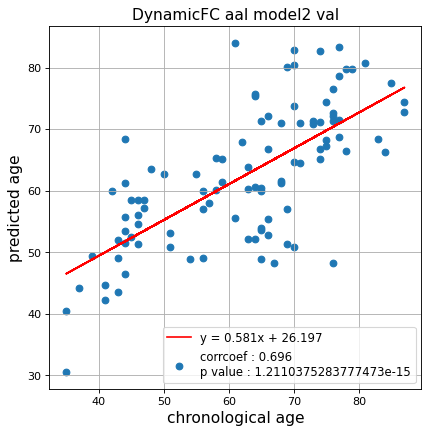

切片: 26.197428032365004
傾き: 0.5811043903788304
Kfold: 3 ::: epoch: 100, loss: 0.04703924862238077, val loss: 0.5355115681886673
Kfold: 3 ::: epoch: 200, loss: 0.0184516696116099, val loss: 0.5192403718829155
Kfold: 3 ::: epoch: 300, loss: 0.013531030263178624, val loss: 0.5397983267903328
Kfold: 3 ::: epoch: 400, loss: 0.01174534409521864, val loss: 0.5126273920759559
early stopping
save_epochs:294
best val loss:0.4810493290424347


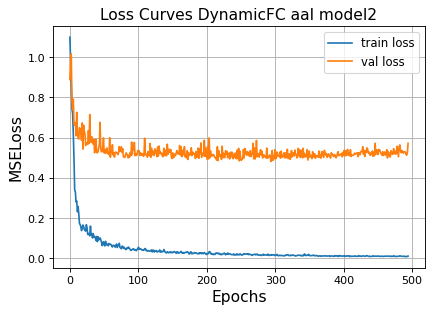

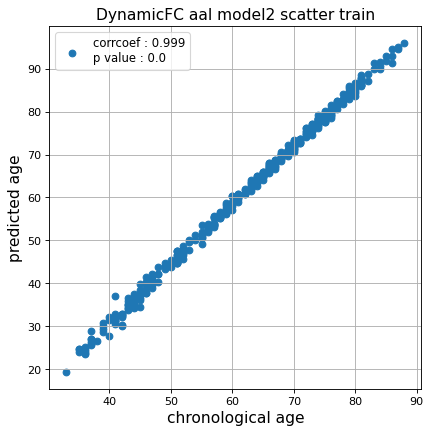

r^2 train data:  0.8515136312714044


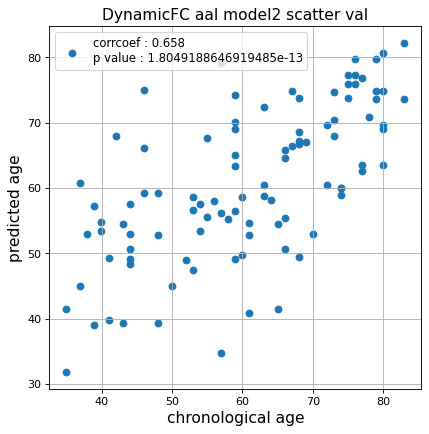

r^2 val data:  0.3912294879245689


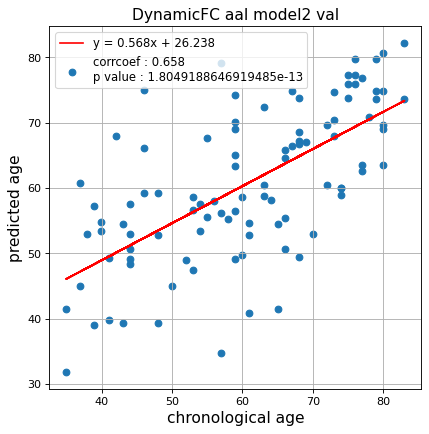

切片: 26.23783560076621
傾き: 0.5675820958844159
Kfold: 4 ::: epoch: 100, loss: 0.03571958367068034, val loss: 0.6594729200005531
Kfold: 4 ::: epoch: 200, loss: 0.01982012638249076, val loss: 0.6363930031657219
Kfold: 4 ::: epoch: 300, loss: 0.01607420016080141, val loss: 0.6450383216142654
Kfold: 4 ::: epoch: 400, loss: 0.010102877500825204, val loss: 0.6370207816362381
Kfold: 4 ::: epoch: 500, loss: 0.009509508659203466, val loss: 0.6626724451780319
Kfold: 4 ::: epoch: 600, loss: 0.0063113071597539466, val loss: 0.649373784661293
early stopping
save_epochs:448
best val loss:0.6046708077192307


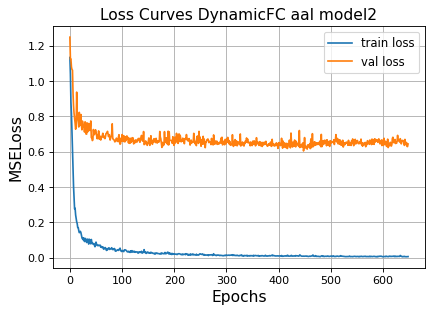

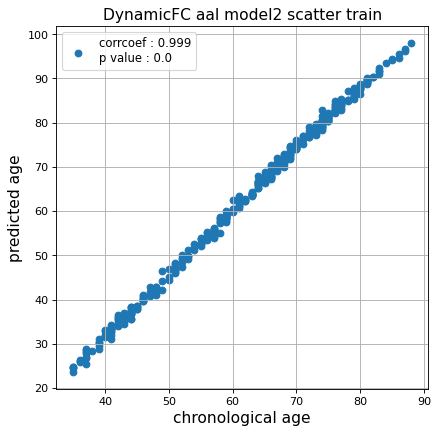

r^2 train data:  0.8177246630829119


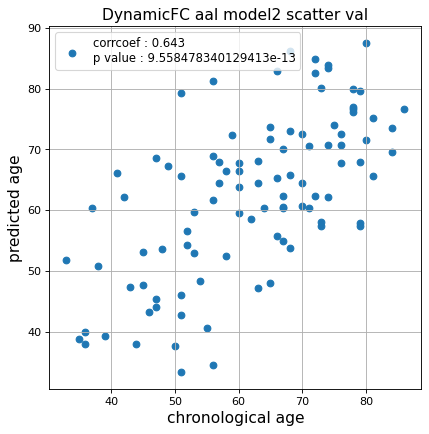

r^2 val data:  0.29492141328482924


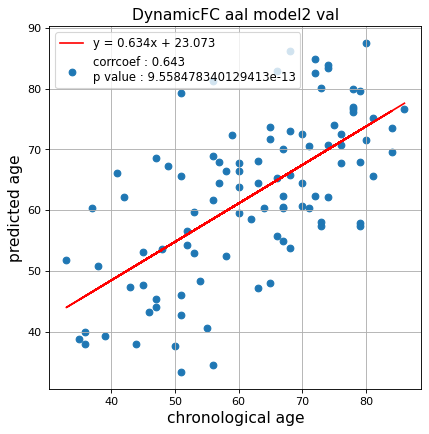

切片: 23.072649881754238
傾き: 0.6337782634338152
Kfold: 5 ::: epoch: 100, loss: 0.04079114860640122, val loss: 0.9171354919672012
Kfold: 5 ::: epoch: 200, loss: 0.02088143676519394, val loss: 0.7584096491336823
Kfold: 5 ::: epoch: 300, loss: 0.014344581617758824, val loss: 0.68488609790802
Kfold: 5 ::: epoch: 400, loss: 0.010267305080420695, val loss: 0.6842005252838135
Kfold: 5 ::: epoch: 500, loss: 0.008247577585279942, val loss: 0.679183728992939
Kfold: 5 ::: epoch: 600, loss: 0.008150173369078683, val loss: 0.6279948353767395
Kfold: 5 ::: epoch: 700, loss: 0.007456287616290725, val loss: 0.6426189169287682
save_epochs:673
best val loss:0.6126896291971207


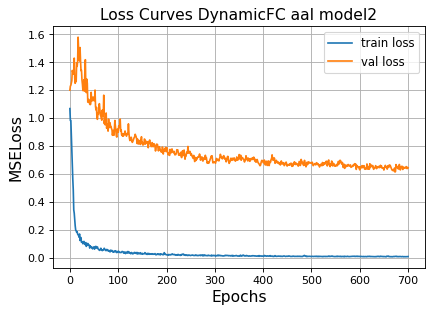

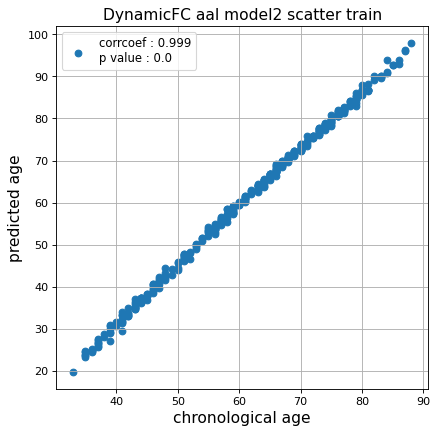

r^2 train data:  0.8519758961149269


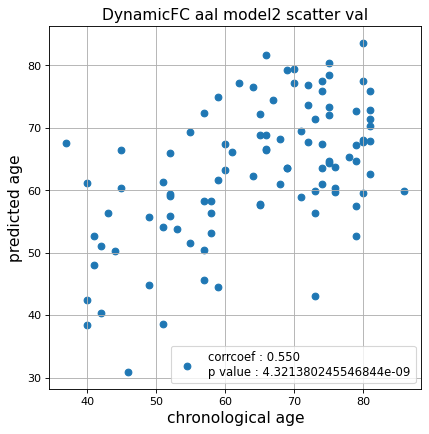

r^2 val data:  0.20462791934866031


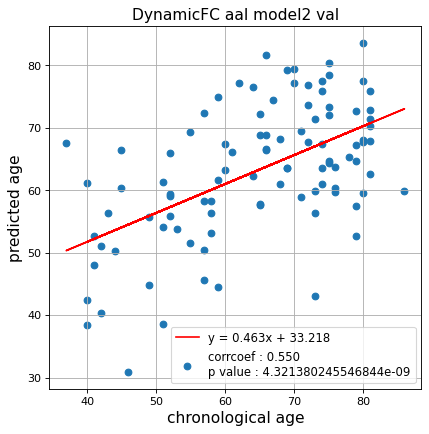

切片: 33.21845086735746
傾き: 0.46299635746205486
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.03788635048728723, val loss: 0.6529965400695801
Kfold: 1 ::: epoch: 200, loss: 0.020349770354536865, val loss: 0.6970956325531006
Kfold: 1 ::: epoch: 300, loss: 0.014550741332081648, val loss: 0.7052341401576996
Kfold: 1 ::: epoch: 400, loss: 0.010956984693900896, val loss: 0.7238851934671402
early stopping
save_epochs:205
best val loss:0.6675253361463547


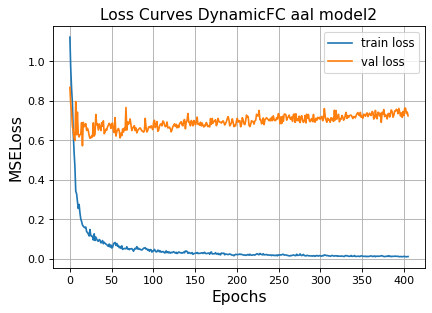

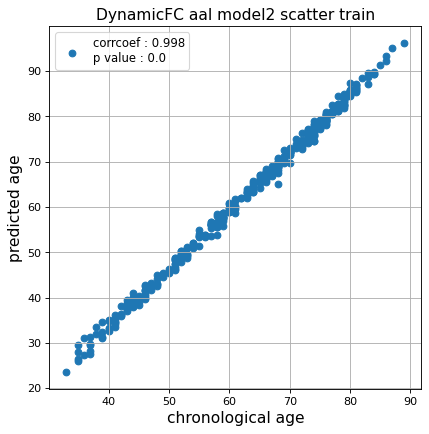

r^2 train data:  0.9189977374436017


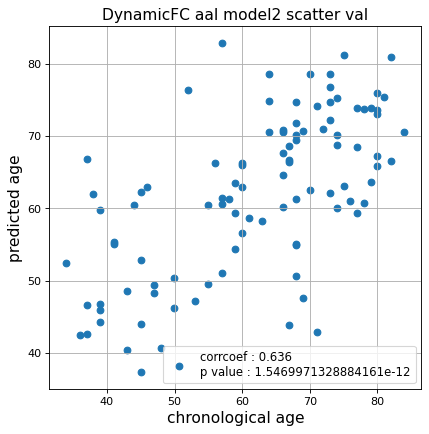

r^2 val data:  0.3747486738768254


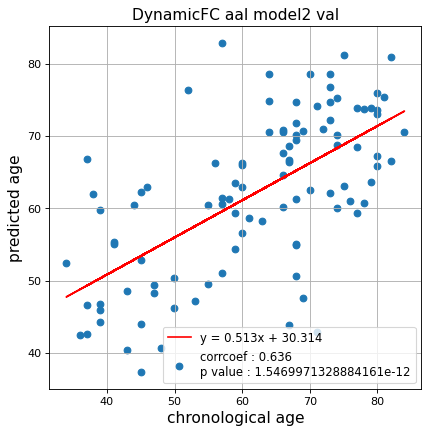

切片: 30.314339277212817
傾き: 0.5132182566507587
Kfold: 2 ::: epoch: 100, loss: 0.04440828914252611, val loss: 0.6321158409118652
Kfold: 2 ::: epoch: 200, loss: 0.018770007989727534, val loss: 0.6106431558728218
Kfold: 2 ::: epoch: 300, loss: 0.014868303918494629, val loss: 0.568379171192646
Kfold: 2 ::: epoch: 400, loss: 0.011300134078527872, val loss: 0.5470488592982292
Kfold: 2 ::: epoch: 500, loss: 0.010125823999540163, val loss: 0.5619007870554924
Kfold: 2 ::: epoch: 600, loss: 0.008701884295218267, val loss: 0.565781943500042
early stopping
save_epochs:399
best val loss:0.5285850539803505


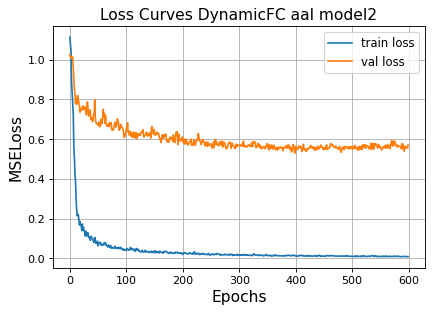

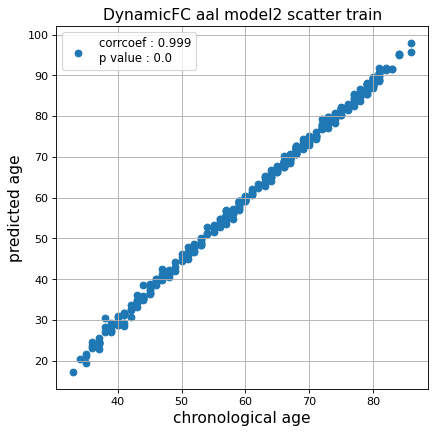

r^2 train data:  0.7763375497426136


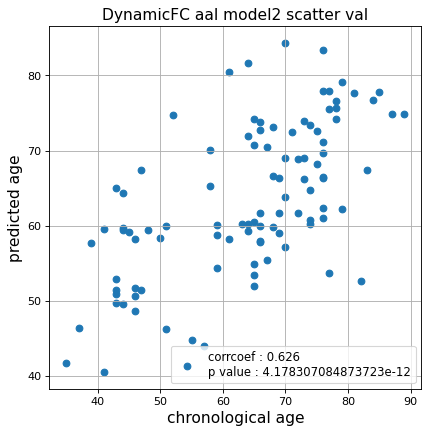

r^2 val data:  0.3763475832751134


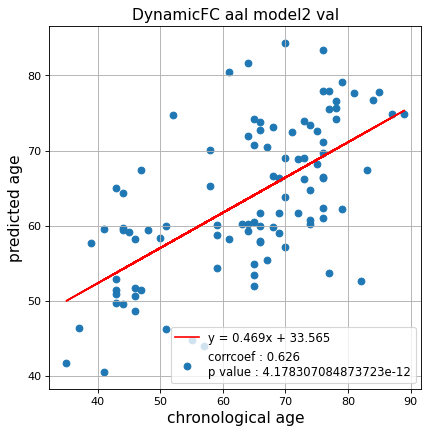

切片: 33.565402390327854
傾き: 0.46927088235448
Kfold: 3 ::: epoch: 100, loss: 0.039227136482413, val loss: 0.45064064813777804
Kfold: 3 ::: epoch: 200, loss: 0.022741294680879667, val loss: 0.43843364529311657
Kfold: 3 ::: epoch: 300, loss: 0.013666135330612842, val loss: 0.4492492377758026
Kfold: 3 ::: epoch: 400, loss: 0.009682291509726873, val loss: 0.4353362210094929
early stopping
save_epochs:229
best val loss:0.4182205442339182


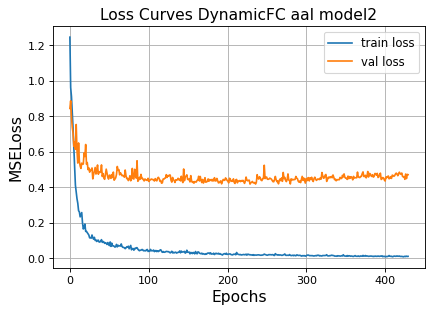

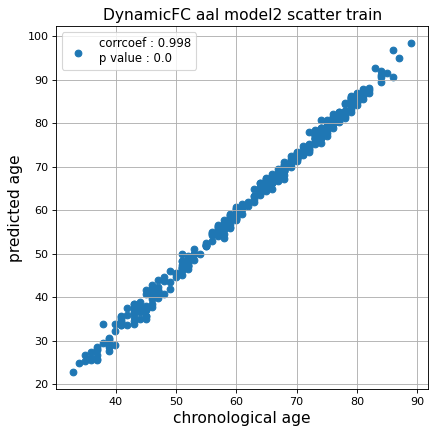

r^2 train data:  0.8755809283856264


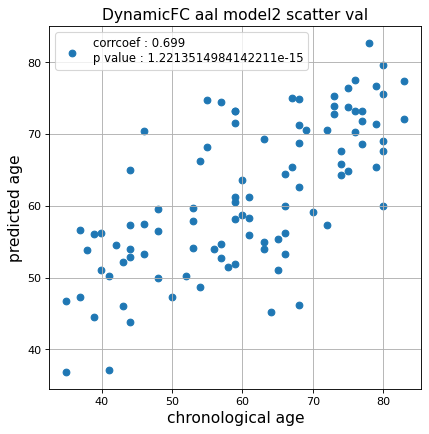

r^2 val data:  0.480610434956264


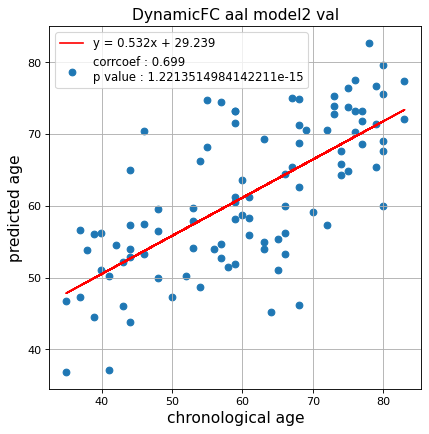

切片: 29.23889762501436
傾き: 0.5318441130492638
Kfold: 4 ::: epoch: 100, loss: 0.04059767651443298, val loss: 1.0194104462862015
Kfold: 4 ::: epoch: 200, loss: 0.022403462073550776, val loss: 0.9686445146799088
Kfold: 4 ::: epoch: 300, loss: 0.016537494742526457, val loss: 0.9551451355218887
Kfold: 4 ::: epoch: 400, loss: 0.01232226465183955, val loss: 0.9447929412126541
Kfold: 4 ::: epoch: 500, loss: 0.008308195473196415, val loss: 0.9468916654586792
early stopping
save_epochs:330
best val loss:0.8986259698867798


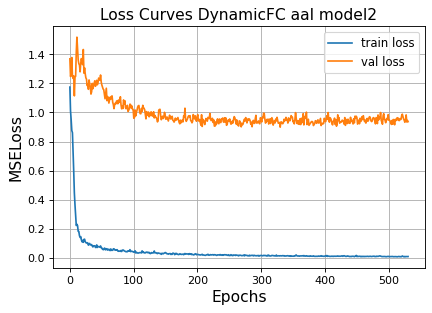

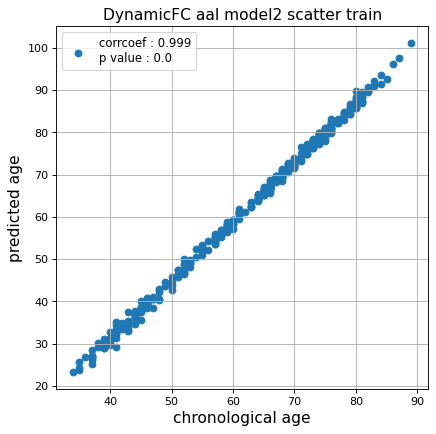

r^2 train data:  0.8382673320044534


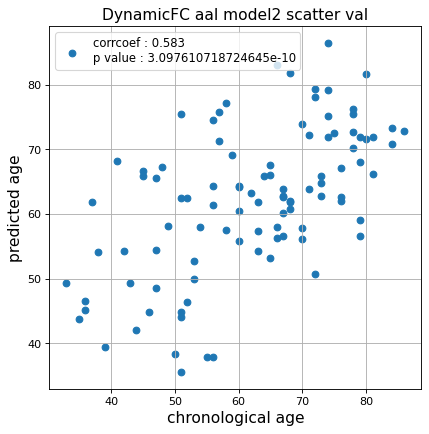

r^2 val data:  0.26945512071365396


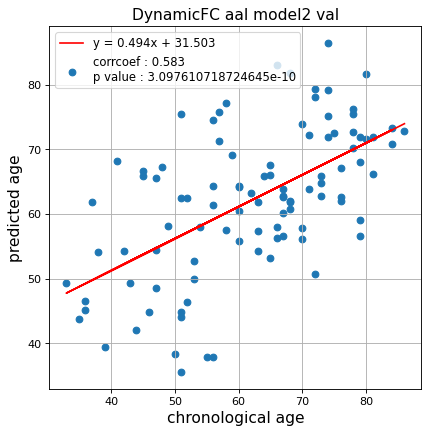

切片: 31.503231685071686
傾き: 0.49358283602321307
Kfold: 5 ::: epoch: 100, loss: 0.04866223925581345, val loss: 0.7651386633515358
Kfold: 5 ::: epoch: 200, loss: 0.021203881057982262, val loss: 0.776757076382637
Kfold: 5 ::: epoch: 300, loss: 0.01108139230368229, val loss: 0.7090706378221512
Kfold: 5 ::: epoch: 400, loss: 0.010729723538343724, val loss: 0.7507008910179138
early stopping
save_epochs:250
best val loss:0.6525922939181328


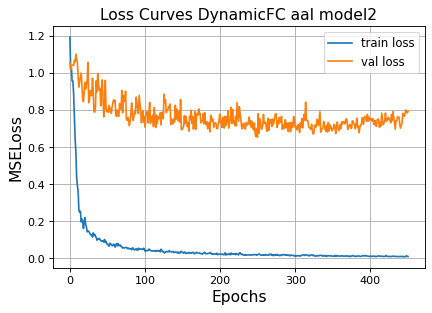

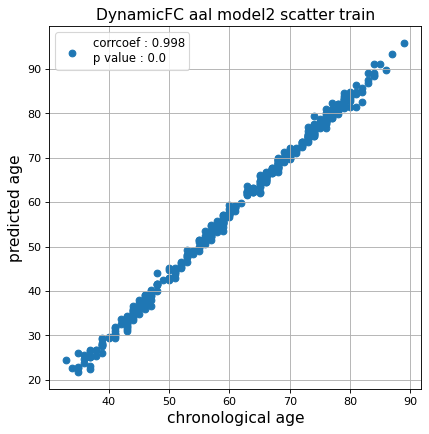

r^2 train data:  0.8370030347171935


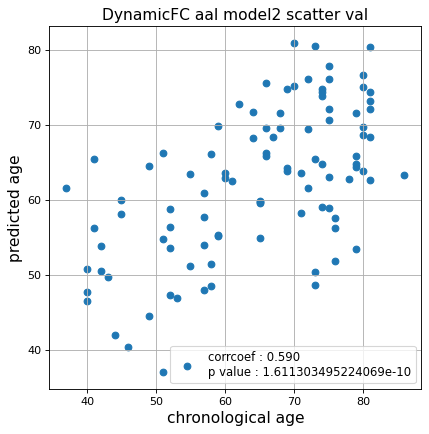

r^2 val data:  0.28510688842054377


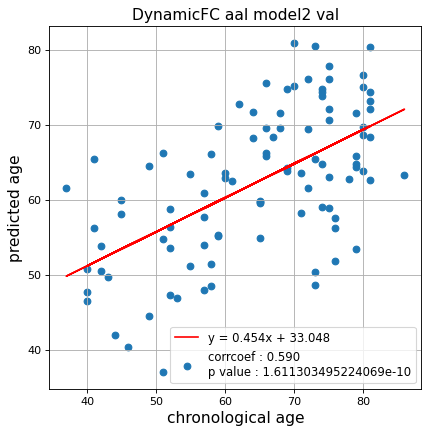

切片: 33.04828403241267
傾き: 0.4541233163566395
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.04228205563357243, val loss: 0.7807774990797043
Kfold: 1 ::: epoch: 200, loss: 0.02013282957845009, val loss: 0.7809701263904572
Kfold: 1 ::: epoch: 300, loss: 0.012818855305130664, val loss: 0.7972375154495239
Kfold: 1 ::: epoch: 400, loss: 0.010934033395292668, val loss: 0.8308121860027313
early stopping
save_epochs:274
best val loss:0.7730790078639984


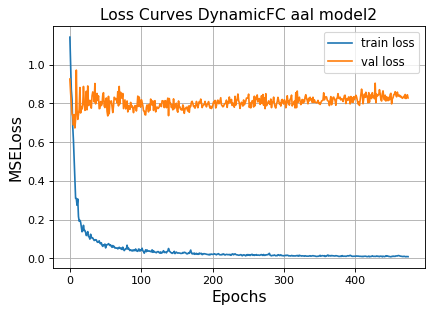

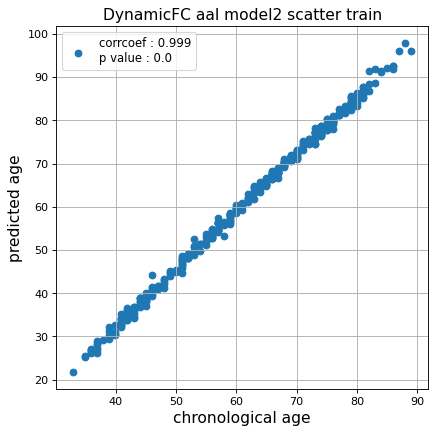

r^2 train data:  0.8838202530286164


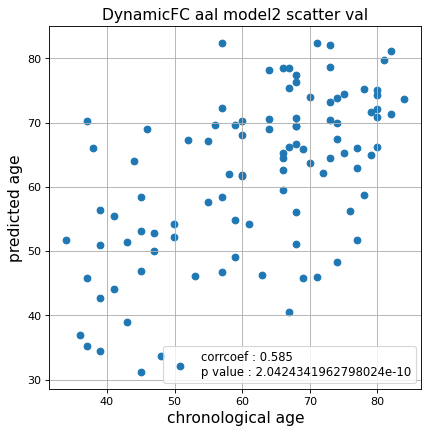

r^2 val data:  0.23705570457509373


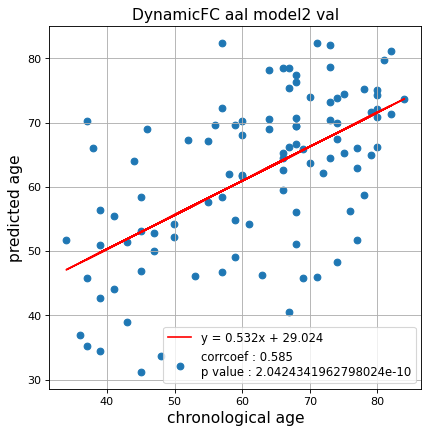

切片: 29.023512181995528
傾き: 0.5318599314211195
Kfold: 2 ::: epoch: 100, loss: 0.03403003714405573, val loss: 0.63312928378582
Kfold: 2 ::: epoch: 200, loss: 0.020318754590474643, val loss: 0.6427973434329033
Kfold: 2 ::: epoch: 300, loss: 0.015825632744683668, val loss: 0.6949150860309601
Kfold: 2 ::: epoch: 400, loss: 0.01227653671342593, val loss: 0.698722168803215
early stopping
save_epochs:231
best val loss:0.6225290596485138


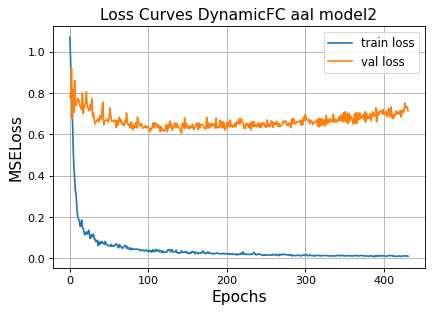

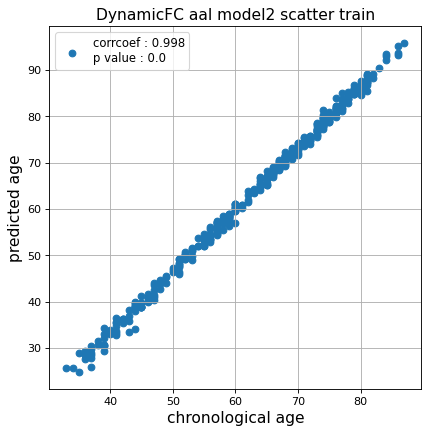

r^2 train data:  0.8801524201916915


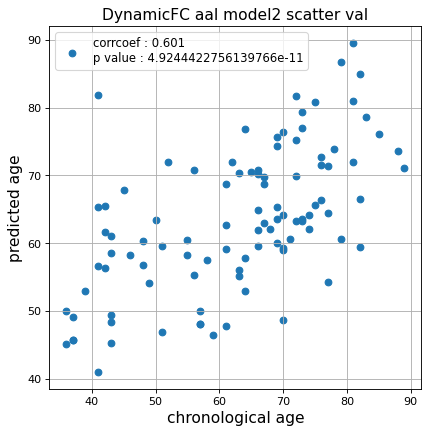

r^2 val data:  0.33448879126986986


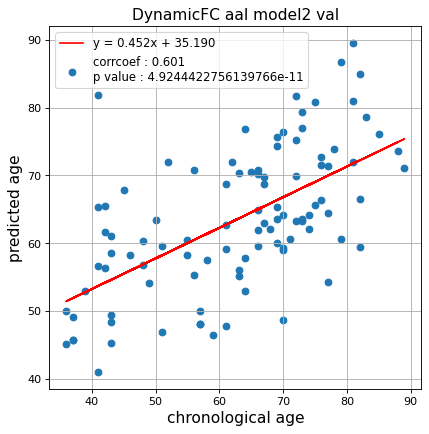

切片: 35.18992146787792
傾き: 0.451590305640102
Kfold: 3 ::: epoch: 100, loss: 0.05043957353784488, val loss: 0.5967557355761528
Kfold: 3 ::: epoch: 200, loss: 0.027212405505661782, val loss: 0.6064148396253586
Kfold: 3 ::: epoch: 300, loss: 0.014968829372754464, val loss: 0.6094047650694847
Kfold: 3 ::: epoch: 400, loss: 0.011932012983239614, val loss: 0.6317067295312881
early stopping
save_epochs:218
best val loss:0.5498291924595833


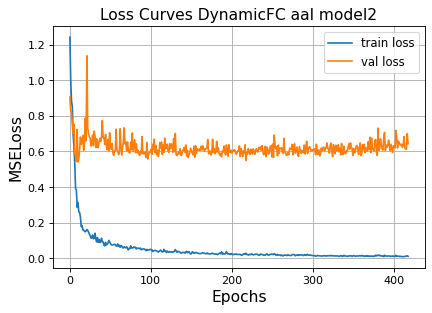

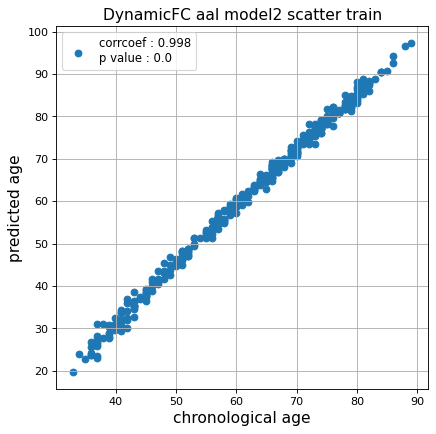

r^2 train data:  0.8654633568263665


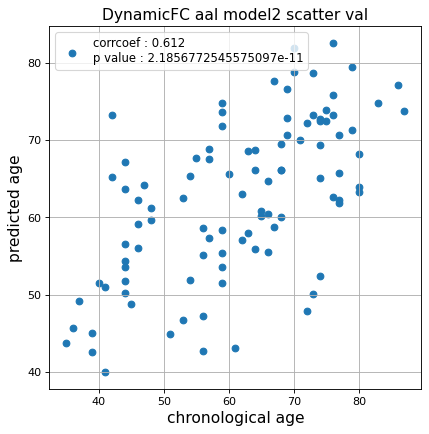

r^2 val data:  0.34060348855087996


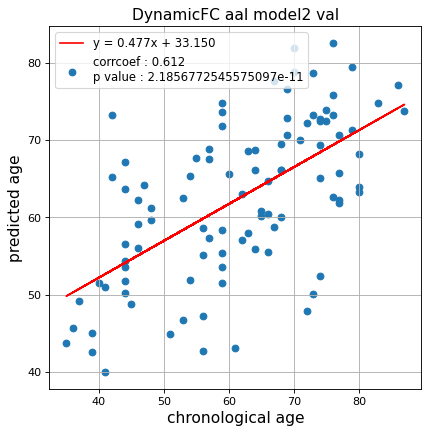

切片: 33.14964754856698
傾き: 0.47658549060742234
Kfold: 4 ::: epoch: 100, loss: 0.06618290265592244, val loss: 1.2731017470359802
Kfold: 4 ::: epoch: 200, loss: 0.01969652701742374, val loss: 1.266068384051323
Kfold: 4 ::: epoch: 300, loss: 0.014347161023089519, val loss: 1.1717488914728165
Kfold: 4 ::: epoch: 400, loss: 0.010080018725532752, val loss: 1.120883285999298
Kfold: 4 ::: epoch: 500, loss: 0.0080774540726382, val loss: 1.1157261282205582
Kfold: 4 ::: epoch: 600, loss: 0.008462648319367033, val loss: 1.045281931757927
Kfold: 4 ::: epoch: 700, loss: 0.0067207330408004615, val loss: 1.0461672991514206
save_epochs:676
best val loss:0.9828158318996429


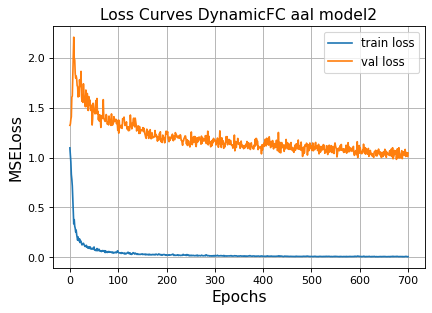

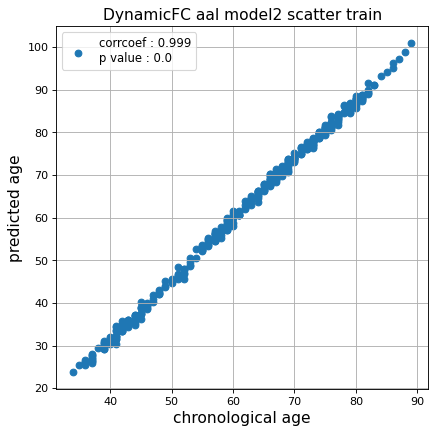

r^2 train data:  0.8288144309551465


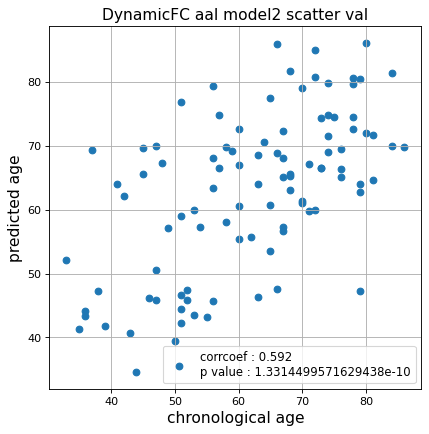

r^2 val data:  0.2312823591695773


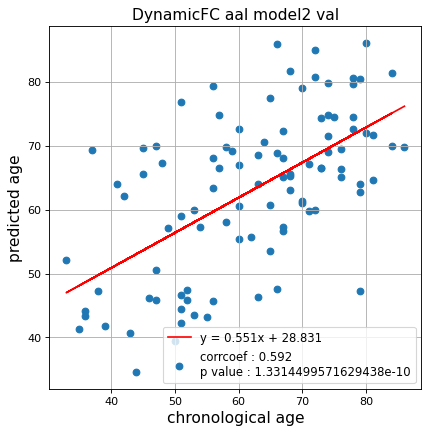

切片: 28.8312232229176
傾き: 0.5509063027998095
Kfold: 5 ::: epoch: 100, loss: 0.041138098073693424, val loss: 0.532185873016715
Kfold: 5 ::: epoch: 200, loss: 0.026769350927609663, val loss: 0.5595089718699455
Kfold: 5 ::: epoch: 300, loss: 0.01452875710450686, val loss: 0.5568204075098038
Kfold: 5 ::: epoch: 400, loss: 0.011918303628380481, val loss: 0.5736612156033516
early stopping
save_epochs:217
best val loss:0.5275739300996065


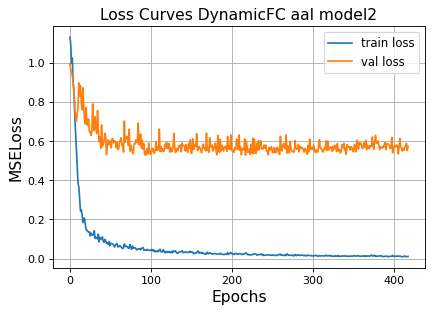

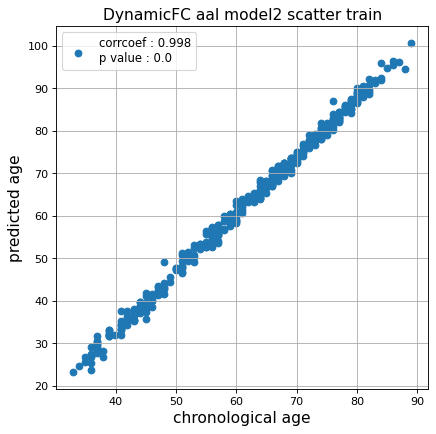

r^2 train data:  0.8485542263466732


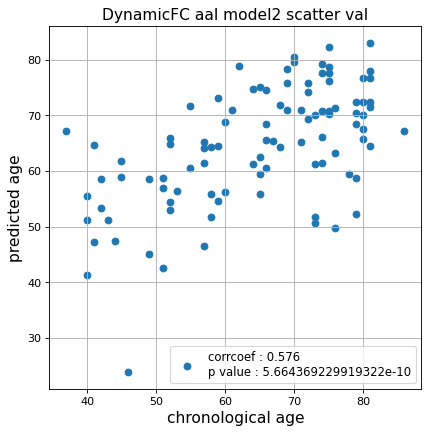

r^2 val data:  0.26807769759579037


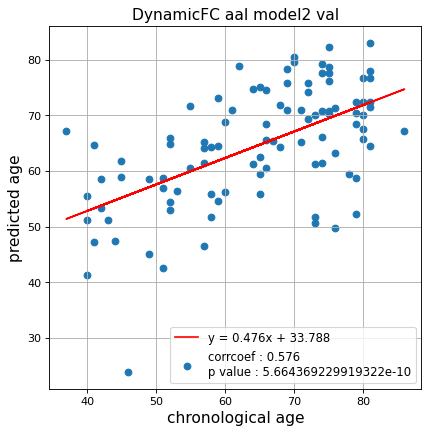

切片: 33.78762669383917
傾き: 0.47588839809353434
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.03960993105115799, val loss: 0.6387250274419785
Kfold: 1 ::: epoch: 200, loss: 0.021381855369187318, val loss: 0.6513965874910355
Kfold: 1 ::: epoch: 300, loss: 0.014414373928537736, val loss: 0.6739805787801743
Kfold: 1 ::: epoch: 400, loss: 0.011096527226842366, val loss: 0.7062326073646545
early stopping
save_epochs:221
best val loss:0.6493508517742157


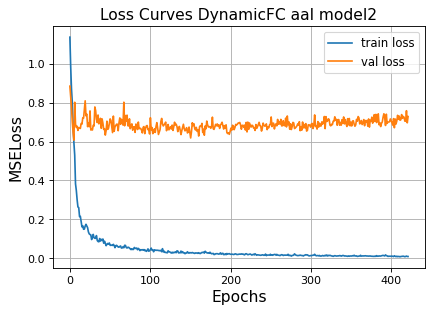

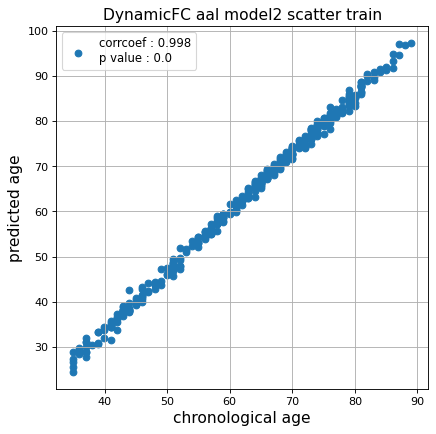

r^2 train data:  0.8950665668740888


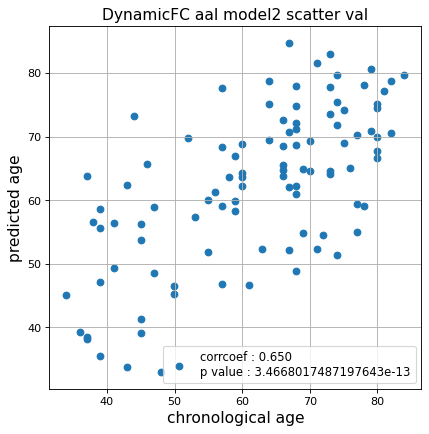

r^2 val data:  0.36452914662498226


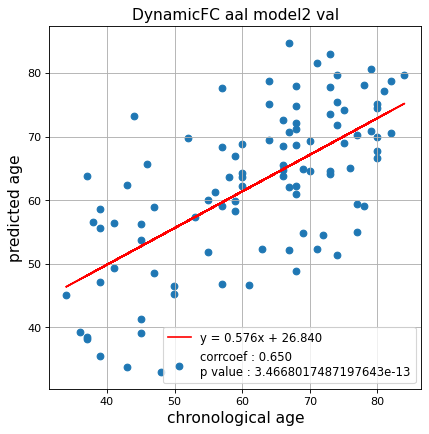

切片: 26.83985792425861
傾き: 0.5758350827969572
Kfold: 2 ::: epoch: 100, loss: 0.053898788845309846, val loss: 0.7455712854862213


In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_2  = []
test_pred_aal_dynamic_corrected_2  = []
test_label_aal_dynamic_2 = []
test_idx_aal_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model2'
                                                          )
    
    test_pred_aal_dynamic_2.append(test_pred)
    test_pred_aal_dynamic_corrected_2.append(test_pred_corrected)
    test_label_aal_dynamic_2.append(test_label)
    test_idx_aal_dynamic_2.append(test_idx)

### データ保存

In [ ]:
!python GPU.py Transformer_dFC_AAL

In [ ]:
test_pred_aal_dynamic_1 = np.array(test_pred_aal_dynamic_1, dtype=object)
test_pred_aal_dynamic_corrected_1 = np.array(test_pred_aal_dynamic_corrected_1, dtype=object)

test_pred_aal_dynamic_2 = np.array(test_pred_aal_dynamic_2, dtype=object)
test_pred_aal_dynamic_corrected_2 = np.array(test_pred_aal_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_aal_1',
         test_pred_aal_dynamic_1,
         test_pred_aal_dynamic_corrected_1,
         test_label_aal_dynamic_1,
         test_idx_aal_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_aal_2',
         test_pred_aal_dynamic_2,
         test_pred_aal_dynamic_corrected_2,
         test_label_aal_dynamic_2,
         test_idx_aal_dynamic_2)

## 学習(Harvard-Oxford)

### ROI 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_1  = []
test_pred_ho_corrected_1  = []
test_label_ho_1 = []
test_idx_ho_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model1'
                                                          )
    
    test_pred_ho_1.append(test_pred)
    test_pred_ho_corrected_1.append(test_pred_corrected)
    test_label_ho_1.append(test_label)
    test_idx_ho_1.append(test_idx)

### ROI 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_2  = []
test_pred_ho_corrected_2  = []
test_label_ho_2 = []
test_idx_ho_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model2'
                                                          )
    
    test_pred_ho_2.append(test_pred)
    test_pred_ho_corrected_2.append(test_pred_corrected)
    test_label_ho_2.append(test_label)
    test_idx_ho_2.append(test_idx)

### データ保存

In [ ]:
!python GPU.py Transformer_ROI_HO

In [ ]:
test_pred_ho_1 = np.array(test_pred_ho_1, dtype=object)
test_pred_ho_corrected_1 = np.array(test_pred_ho_corrected_1, dtype=object)

test_pred_ho_2 = np.array(test_pred_ho_2, dtype=object)
test_pred_ho_corrected_2 = np.array(test_pred_ho_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/ho_1',
         test_pred_ho_1,
         test_pred_ho_corrected_1,
         test_label_ho_1,
         test_idx_ho_1)
np.savez('../02_data_analysis/temp/ho_2',
         test_pred_ho_2,
         test_pred_ho_corrected_2,
         test_label_ho_2,
         test_idx_ho_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')
data_dynamic_ho = make_data(df_dynamic_ho)
print(data_dynamic_ho.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_1  = []
test_pred_ho_dynamic_corrected_1  = []
test_label_ho_dynamic_1 = []
test_idx_ho_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model1'
                                                          )
    
    test_pred_ho_dynamic_1.append(test_pred)
    test_pred_ho_dynamic_corrected_1.append(test_pred_corrected)
    test_label_ho_dynamic_1.append(test_label)
    test_idx_ho_dynamic_1.append(test_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_2  = []
test_pred_ho_dynamic_corrected_2  = []
test_label_ho_dynamic_2 = []
test_idx_ho_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model2'
                                                          )
    
    test_pred_ho_dynamic_2.append(test_pred)
    test_pred_ho_dynamic_corrected_2.append(test_pred_corrected)
    test_label_ho_dynamic_2.append(test_label)
    test_idx_ho_dynamic_2.append(test_idx)

### データ保存

In [ ]:
!python GPU.py Transformer_dFC_HO

In [ ]:
test_pred_ho_dynamic_1 = np.array(test_pred_ho_dynamic_1, dtype=object)
test_pred_ho_dynamic_corrected_1 = np.array(test_pred_ho_dynamic_corrected_1, dtype=object)

test_pred_ho_dynamic_2 = np.array(test_pred_ho_dynamic_2, dtype=object)
test_pred_ho_dynamic_corrected_2 = np.array(test_pred_ho_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_ho_1',
         test_pred_ho_dynamic_1,
         test_pred_ho_dynamic_corrected_1,
         test_label_ho_dynamic_1,
         test_idx_ho_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_ho_2',
         test_pred_ho_dynamic_2,
         test_pred_ho_dynamic_corrected_2,
         test_label_ho_dynamic_2,
         test_idx_ho_dynamic_2)